In [1]:
import os
import sys
from hashlib import sha256
import random

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
from jose.helpers import file_functions
from lared.dataset.example import VideoExample, AudioExample, FullExample
from lared.data_loading.utils import get_video_caps, AudioFiles
from annotation.coco_reader import CocoReader
from lared_laughter.constants import raw_video_path, raw_audio_path, \
    processed_data_path, datasets_path, annot_exp_path as original_exp_path

In [4]:
VideoExample.init_caps(get_video_caps(raw_video_path))
VideoExample.init_camera_annotation(os.path.join(processed_data_path, 'elan_out/camera.txt'))
AudioExample.init_dataset(AudioFiles(raw_audio_path))

In [5]:
# load ELAN annotations
laughter_ann_path = os.path.join(processed_data_path, 'elan_out/laughter.txt')
# path for output images
annot_exp_path = os.path.join(os.environ['PROC_DATA_PATH'], 'lared_laughter', 'annotation_experiment_2')

laughter_ann = pd.read_csv(laughter_ann_path, sep='\t',names=['name','participant','ini','fin','dur','type'],header=None)
df_laughter_by_participant = laughter_ann.groupby('participant')

In [6]:
dfs_laughter = []
for i in df_laughter_by_participant.groups:
    dfs_laughter.append(df_laughter_by_participant.get_group(i))
participant_ids = df_laughter_by_participant.groups.keys()
participant_ids = [int(id) for id in participant_ids]

In [7]:
# total number of annotated laughter
sum([len(df) for df in dfs_laughter])

1838

# Apply episode threshold

In [8]:
dfs_laughter[0].tail(2)

,name,participant,ini,fin,dur,type
65,laughter1,1,6628.40,6629.84,1.44,laughter
66,laughter1,1,6630.84,6631.88,1.04,laughter


In [9]:
# join episodes/bouts that are closer than 1s in time
threshold = 1
num_deleted = 0
num_episodes = 0
for df in dfs_laughter:
    df.reset_index(inplace=True)
    to_delete = []
    for i, row in enumerate(df.iterrows()):
        num_episodes += 1
        if i == len(df)-1: 
            continue
        if (df.loc[i+1, 'ini'] - df.loc[i, 'fin']) < 1:
            df.loc[i+1, 'ini'] = df.loc[i, 'ini']
            to_delete.append(i)
    
    num_deleted += len(to_delete)
    df.drop(to_delete, inplace=True)
print(f'Joined / deleted: {num_deleted} / {num_episodes}')

Joined / deleted: 28 / 1838


/tmp/ipykernel_20236/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_20236/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_20236/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_20236/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be s

In [10]:
# add prev_fin and next_ini
for df in dfs_laughter:
    df.reset_index(inplace=True)
    prev_fin = []
    next_ini = []
    for i, row in enumerate(df.iterrows()):
        prev_fin.append(0 if i == 0 else df.loc[i-1, 'fin'])
        next_ini.append(1000000 if i == len(df)-1 else df.loc[i+1, 'ini'])
    df.insert(6, 'prev_fin', prev_fin)
    df.insert(7, 'next_ini', next_ini)

In [11]:
sum([len(df) for df in dfs_laughter])

1810

In [12]:
dfs_laughter[0].head(2)

,level_0,index,name,participant,ini,fin,prev_fin,next_ini,dur,type
0,0,0,laughter1,1,1028.28,1030.08,0.00,1049.98,1.80,laughter
1,1,1,laughter1,1,1049.98,1051.30,1030.08,1099.88,1.32,laughter


# Filter out segments of the interaction

In [13]:
# valid segments
# permisive
# [15:00 - 25:25]
# [27:00 - 40:50]
# [43:00 - 48:42]
# [49:00 - 1:30:35]
# [1:33:00 - 2:44:00]

# strict
# [16:30 - 25:25]
# [28:00 - 40:50]
# [43:00 - 48:42]
# [55:20 - 1:30:35]
# [1:33:00 - 2:44:00]

In [14]:
# checks if an example is within the valid parts of the interaction
# segments of the interaction where people are not in free-for-all were removed (made invalid)
# the fn returns false if the example is within those segments.
def is_valid(s):
    valid_segs = [
        [990, 1525],
        [1680, 2450],
        [2580, 2922],
        [3320, 5435],
        [5580, 9840]
    ]
    for seg in valid_segs:
        if s[0] >= seg[0] and s[1] < seg[1]:
            return True
    return False

def is_valid_row(row):
    return is_valid([row['ini'], row['fin']])

In [15]:
num_kept = 0
num_episodes = 0
for i, df in enumerate(dfs_laughter):
    m = df.apply(is_valid_row, axis=1)
    num_kept += np.sum(m)
    num_episodes += len(m)
    dfs_laughter[i] = df[m]
print(f'Kept: {num_kept} / {num_episodes}')

Kept: 1493 / 1810


# Laughter example: generation

generate the base set of laughter examples

In [16]:
random.seed(22)
np.random.seed(22)

In [17]:
# Pad and split examples
laughter_examples = dict()
camera_distrib = {0: 0, 1:0, 2:0, 3:0, 4:0}
for i, (pid, df_laughter) in tqdm(enumerate(zip(participant_ids, dfs_laughter))):
    for index,row in df_laughter.iterrows():
        ex = FullExample(
            pid= pid,
            ini_time= row['ini'],
            end_time= row['fin'])
        ex.random_pad(1.5, 3.5, min_ini=row['prev_fin'], max_end=row['next_ini'])
        ex.set_camera()
        exs = ex.split_by_camera()
        camera_distrib[len(exs)] += 1

        for example in exs:
            laughter_examples[example.get_hash()] = example

0it [00:00, ?it/s]

<BarContainer object of 5 artists>

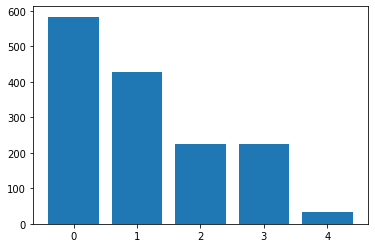

In [18]:
# distribution of num examples among subject IDs
plt.bar(camera_distrib.keys(), camera_distrib.values())

# Laughter examples: loading
load a previously generated set of examples

In [10]:
laughter_examples_df = pd.read_csv(os.path.join(annot_exp_path, 'laughter_examples', 'examples1.csv'), index_col=0)
laughter_examples = {ex[1].hash: FullExample(**ex[1].to_dict()) for ex in laughter_examples_df.iterrows()}

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/examples1.csv'

# Get the distribution

In [14]:
pid_distrib = {pid: 0 for pid in participant_ids}
for ex in laughter_examples.values():
    pid_distrib[ex.pid] += 1

<BarContainer object of 33 artists>

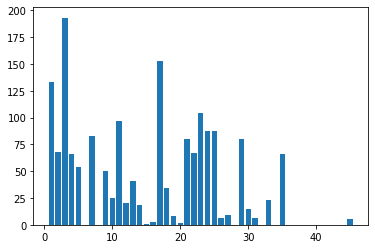

In [15]:
# distribution of num examples among subject IDs
plt.bar(pid_distrib.keys(), pid_distrib.values())

In [22]:
# write images for laughter examples
laughter_images_path = os.path.join(annot_exp_path, 'laughter_examples', 'images')
pilot_examples = random.sample(list(laughter_examples.values()), 1000)
for ex in tqdm(pilot_examples):
    ex.write_full_first_image(laughter_images_path)
(len(pilot_examples), len(laughter_examples))

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
audio_path = os.path.join(annot_exp_path, 'laughter_examples', 'audio')
video_path = os.path.join(annot_exp_path, 'laughter_examples', 'video')
av_path = os.path.join(annot_exp_path, 'laughter_examples', 'av')
aiv_path = os.path.join(annot_exp_path, 'laughter_examples', 'aiv')
if not os.path.exists(audio_path): os.makedirs(audio_path)
if not os.path.exists(video_path): os.makedirs(video_path)
if not os.path.exists(av_path): os.makedirs(av_path)
if not os.path.exists(aiv_path): os.makedirs(aiv_path)

In [23]:
coco_reader = CocoReader(os.path.join(annot_exp_path, 'laughter_examples', 'cvat.json'))

In [26]:
# write back the bbs
for hash, ex in tqdm(laughter_examples.items()):
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    if not ex.rect:
        continue
    ex.write_audio(audio_path, padded=True)
    ex.write_audio_video(audio_path, './audio.jpg', aiv_path)
    ex.write_video(video_path, padded=True)
    ex.write_audiovisual(video_path, audio_path, av_path)

  0%|          | 0/1684 [00:00<?, ?it/s]

ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_adbd2fbe228c7178772c306b43ef47ffde64f6670b66b1269d343eac1de8cab2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_adbd2fbe228c7178772c306b43ef47ffde64f6670b66b1269d343eac1de8cab2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_670eb892373acc2eee58a564ad98bd2fe6c5c9fcf1e8d536aa3b6e7339db11e5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_670eb892373acc2eee58a564ad98bd2fe6c5c9fcf1e8d536aa3b6e7339db11e5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_a6e7c80bcdffb54ae08909634d84ea264f89d030c7a3fa321db8f1f91d3fc0aa_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_a6e7c80bcdffb54ae08909634d84ea264f89d030c7a3fa321db8f1f91d3fc0aa_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_84a6959ce411938732ef88e9b654f676feea503b2fef19bd51693ecb19000a99_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_84a6959ce411938732ef88e9b654f676feea503b2fef19bd51693ecb19000a99_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_10608dcffec9ca91518034c93d8207e9714ff86179af037d12e1351bcbc80d3c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_10608dcffec9ca91518034c93d8207e9714ff86179af037d12e1351bcbc80d3c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_fc95b15d7a78e4037d8a4c78d6bc0c3e0b4aa3ba169cad80d460609f8cdeb140_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_fc95b15d7a78e4037d8a4c78d6bc0c3e0b4aa3ba169cad80d460609f8cdeb140_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_df60125e135d213fbcebf95e28113b40594fedbb804343cb845345bf5a526ecb_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_df60125e135d213fbcebf95e28113b40594fedbb804343cb845345bf5a526ecb_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_be23c7dac14a4274a34a6c6e44ea93081c356fb18b59a927202ccb4e34d079a0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_be23c7dac14a4274a34a6c6e44ea93081c356fb18b59a927202ccb4e34d079a0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_9a50fd7d7142ac3a20b0779b9f19b3e86ef633ea9096d70c6884c492b3636e85_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_9a50fd7d7142ac3a20b0779b9f19b3e86ef633ea9096d70c6884c492b3636e85_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e739e2f626b7823cc52ced2e6e0f70e3fea55a4ac4291a4fc157d0d88b977230_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e739e2f626b7823cc52ced2e6e0f70e3fea55a4ac4291a4fc157d0d88b977230_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_98ad7346324dad0cbd9d9dc641618456aab2a307904d56744d026542b4ee813d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_98ad7346324dad0cbd9d9dc641618456aab2a307904d56744d026542b4ee813d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_148b4625bd9d0bd366f87f16ca970b5813f162d9b681f1beb35a966c458fd5fd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_148b4625bd9d0bd366f87f16ca970b5813f162d9b681f1beb35a966c458fd5fd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e4a5fda1fb402fde57088606ef902fa9418f3fde6ee9fd68bd5ffd85f9e66fac_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e4a5fda1fb402fde57088606ef902fa9418f3fde6ee9fd68bd5ffd85f9e66fac_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_36c6b6ff3dcf3db3625ba8e7552e2af23178fe45719c6958493ee7a80a46de44_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_36c6b6ff3dcf3db3625ba8e7552e2af23178fe45719c6958493ee7a80a46de44_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_c1d181e74dbdbce1e51d7d0bfd6e036913896dd1f228560bf86fafea5b94c4e5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_c1d181e74dbdbce1e51d7d0bfd6e036913896dd1f228560bf86fafea5b94c4e5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_f66316b65e1bd59aa96d8d80660de419e3f1885b71d27ec31cd7fd553b5e75cf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_f66316b65e1bd59aa96d8d80660de419e3f1885b71d27ec31cd7fd553b5e75cf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_39bc410bea6b56cddbf01d1924163b90aeb05afddf9ced3f6b48133b6725e529_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_39bc410bea6b56cddbf01d1924163b90aeb05afddf9ced3f6b48133b6725e529_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_aa5ecb51f3e591947b156488b655283f543223a3824f017d8fd80fc3fc35e728_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_aa5ecb51f3e591947b156488b655283f543223a3824f017d8fd80fc3fc35e728_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_fe484b674deeaa65ef370c011d713aba6dec07d40b8360701e44911ef6457067_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_fe484b674deeaa65ef370c011d713aba6dec07d40b8360701e44911ef6457067_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_eae6f1d76129c5de2a6cabc7ef1b4216364f519af7f9ab7ff66d01cf6185cdc2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_eae6f1d76129c5de2a6cabc7ef1b4216364f519af7f9ab7ff66d01cf6185cdc2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_1ca38703de66161325cf863dee4de62cea2efd308e7d6786e2d6112e0e0a6f9f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_1ca38703de66161325cf863dee4de62cea2efd308e7d6786e2d6112e0e0a6f9f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_b9a87b62ca4fea38aebcbbf9270b8db22144a5a2d089d0515e65f6c81d0c6809_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_b9a87b62ca4fea38aebcbbf9270b8db22144a5a2d089d0515e65f6c81d0c6809_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e096966f84db690e3d28b02b08509af73ba2ff4ae186887097ea2ee7b1cf6d04_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e096966f84db690e3d28b02b08509af73ba2ff4ae186887097ea2ee7b1cf6d04_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_6f124d6d316a3f9fb1ae97c52fd360901e47f2ec71f4fe6ed6078f292cc16952_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_6f124d6d316a3f9fb1ae97c52fd360901e47f2ec71f4fe6ed6078f292cc16952_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_2e3e3a45f3ab2f6e0865fd48620b44368ea05ff7cd85cf01bb743695a3babadb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_2e3e3a45f3ab2f6e0865fd48620b44368ea05ff7cd85cf01bb743695a3babadb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_1b139d4cedb133030f2d189a4e3bac0edea14dfae0d6560f3da8adf66c6ee8fc_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_1b139d4cedb133030f2d189a4e3bac0edea14dfae0d6560f3da8adf66c6ee8fc_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_aaaab42d650647673c91c87e091f1029ff5bb691c8d8764d22e82e50c95f0dcf_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_aaaab42d650647673c91c87e091f1029ff5bb691c8d8764d22e82e50c95f0dcf_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_61e77f32134d2e705ddf95bac4695b839427d8abf75698ed03e12210e83bb442_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_61e77f32134d2e705ddf95bac4695b839427d8abf75698ed03e12210e83bb442_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_01d645b5651160faf98945b1676cd34288b343936a6c8cbe6812de354adb52d1_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_01d645b5651160faf98945b1676cd34288b343936a6c8cbe6812de354adb52d1_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_bc4bb2c5d11d9abb027ef161dd790c498b422c54a84353e54136945b49ee3ee9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_bc4bb2c5d11d9abb027ef161dd790c498b422c54a84353e54136945b49ee3ee9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_a9fe95b18ccf7060a10cf94712d010b3b6484db114ec88ac18334dd3497477af_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_a9fe95b18ccf7060a10cf94712d010b3b6484db114ec88ac18334dd3497477af_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_fa267d2ac68f21854021369868f82e7854ed0482d4fde241a2974847d5d62460_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_fa267d2ac68f21854021369868f82e7854ed0482d4fde241a2974847d5d62460_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_f8c853a93c773f4755abdd774f87e40f6b16c3fd198d6c861adbec069848bf6c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_f8c853a93c773f4755abdd774f87e40f6b16c3fd198d6c861adbec069848bf6c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_c6d05eedfb5540e7a4d7a7f8415a53bca3fdf10e978034afcc22d20c6b9f9ef7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_c6d05eedfb5540e7a4d7a7f8415a53bca3fdf10e978034afcc22d20c6b9f9ef7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_690ed65d981a00cce63fb55664947bc4034453eaa68055c5b56df9178c1994af_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_690ed65d981a00cce63fb55664947bc4034453eaa68055c5b56df9178c1994af_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_038a66a7193cd86fab5c97533b1b3e736d5b102f5e6a5dddd3adf751edeeb066_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_038a66a7193cd86fab5c97533b1b3e736d5b102f5e6a5dddd3adf751edeeb066_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_d7986196df7319638b503ebffa526ff43593bba86309c920842c37bdc2304e13_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_d7986196df7319638b503ebffa526ff43593bba86309c920842c37bdc2304e13_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_4d3f12160af1d9a8a7bf7f91baaced651ef1eb69ec0f3f5e1708c4b223cf4d42_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_4d3f12160af1d9a8a7bf7f91baaced651ef1eb69ec0f3f5e1708c4b223cf4d42_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_0a1d84811904084f80a8449b0715f76f1a9154b6ee7442b54ff6b8187c99fd5b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_0a1d84811904084f80a8449b0715f76f1a9154b6ee7442b54ff6b8187c99fd5b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_10198e95489fe4c9ca96841b067eac86bdd443a7f5ed4db37ebcb828b36d3940_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_10198e95489fe4c9ca96841b067eac86bdd443a7f5ed4db37ebcb828b36d3940_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_9413cbb5210ce070f468e685336bb621757e6ae4086b4750b5f2562fce79f935_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_9413cbb5210ce070f468e685336bb621757e6ae4086b4750b5f2562fce79f935_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_147bb12e342d033a98e6f8c7fe00cf8e7c623a6e6e67fdddc3513149f3104c37_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_147bb12e342d033a98e6f8c7fe00cf8e7c623a6e6e67fdddc3513149f3104c37_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_7ef147ebe6af8c24625598985de7337b1cd21c7edab3907d29fcba27034e0b11_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_7ef147ebe6af8c24625598985de7337b1cd21c7edab3907d29fcba27034e0b11_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_a508bdc4924f7ca26a98a994d327656d980737e1f4859f64f2c0be8a1189e340_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_a508bdc4924f7ca26a98a994d327656d980737e1f4859f64f2c0be8a1189e340_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_edbf9f66641e752ae1a18e27271c5a1efd9898a0219891010be73c9f4ff5f6e3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_edbf9f66641e752ae1a18e27271c5a1efd9898a0219891010be73c9f4ff5f6e3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_6f4bc952a214878c1268169ef4c18245d58fb805abaaa77c144c0f31be42c3f0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_6f4bc952a214878c1268169ef4c18245d58fb805abaaa77c144c0f31be42c3f0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e7b5aaf444bff6aa58b31950bc536280c5bc71f60994d0990f56eb206824e4fa_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e7b5aaf444bff6aa58b31950bc536280c5bc71f60994d0990f56eb206824e4fa_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e0fbb71fbfb51a1138203ce3f98e2d0ef09a149d1c2688372ded02a0f324a042_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e0fbb71fbfb51a1138203ce3f98e2d0ef09a149d1c2688372ded02a0f324a042_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_8a2f3370d818ac95b72f80a3257b16d3396b3e1c0ab80daf3eff07d92afb3ef4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_8a2f3370d818ac95b72f80a3257b16d3396b3e1c0ab80daf3eff07d92afb3ef4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_2009767985be50548bb2ebeac38b7b2947c4daa2bd84102a3eb15c0823ece21d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_2009767985be50548bb2ebeac38b7b2947c4daa2bd84102a3eb15c0823ece21d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_7e92b37a6053b01a96de81d0eb4646911a5f6482c7d6f92cf630b2f705ac8c9e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_7e92b37a6053b01a96de81d0eb4646911a5f6482c7d6f92cf630b2f705ac8c9e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_c93741136c757942cb8fb7feffc80e2f34992374689c6ba4657ff8cb5d557022_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_c93741136c757942cb8fb7feffc80e2f34992374689c6ba4657ff8cb5d557022_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_29dc76e104cf03a623055aba5a04d277d642519fb27847fdb47a36d72476c2ca_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_29dc76e104cf03a623055aba5a04d277d642519fb27847fdb47a36d72476c2ca_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_029f73d9400ee53d3bba86e727a77de5b79340e9ec52bc7dc491e82b08946372_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_029f73d9400ee53d3bba86e727a77de5b79340e9ec52bc7dc491e82b08946372_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_a0764508fad8a37e7f6a6fa2334fa626dd8943be8dfb74cfb2f96f93d2686480_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_a0764508fad8a37e7f6a6fa2334fa626dd8943be8dfb74cfb2f96f93d2686480_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_2583191df49c16613dd08c37027ee7c7f8dc90fdb89127f25305899a597dc6a3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_2583191df49c16613dd08c37027ee7c7f8dc90fdb89127f25305899a597dc6a3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_94a997d2ce9f96e56de7219c4ae0613d5bc5aed15215ecb97c2ee1c834f4731b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_94a997d2ce9f96e56de7219c4ae0613d5bc5aed15215ecb97c2ee1c834f4731b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_68e407db98e0f2c758d3f80480567f899fe23516af6f81b0ec3530f4a364c20d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_68e407db98e0f2c758d3f80480567f899fe23516af6f81b0ec3530f4a364c20d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_2aafc7c58ae56814647563d81e63ad5e69d5d24317f0db5c9f7c4c19686936ac_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_2aafc7c58ae56814647563d81e63ad5e69d5d24317f0db5c9f7c4c19686936ac_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e3cae18b05407197c8d80f1ec9c8ec5c6c39d1d76e3d336c61b5e4c13a0c4bba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e3cae18b05407197c8d80f1ec9c8ec5c6c39d1d76e3d336c61b5e4c13a0c4bba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_e4bedf5e9be7dd57e1e5f01598ddc21860d9fb854b88be9df41778836ff77a90_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_e4bedf5e9be7dd57e1e5f01598ddc21860d9fb854b88be9df41778836ff77a90_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_b65dfec757727538fc76b2c4d618fd6ed87d9048605b22aeebcdd2dee0c48480_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_b65dfec757727538fc76b2c4d618fd6ed87d9048605b22aeebcdd2dee0c48480_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_3d6f225719c670f2f314ebe19c8c560383e3b5506a51251524f67d1d715e9016_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_3d6f225719c670f2f314ebe19c8c560383e3b5506a51251524f67d1d715e9016_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_db15c32c4a9494bbf6993f4686c05ff33c71b57d4cc3ef63c5194e81012ea022_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_db15c32c4a9494bbf6993f4686c05ff33c71b57d4cc3ef63c5194e81012ea022_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_5ab2e006b4be29fec340d61abd6d59a7f5af8fb1b3a881093823248fee7b07c8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_5ab2e006b4be29fec340d61abd6d59a7f5af8fb1b3a881093823248fee7b07c8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_140c2f4e2fc5b9f4229f762bbca48c15a374000b8ad8b3b031fb1e94190ae1cd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_140c2f4e2fc5b9f4229f762bbca48c15a374000b8ad8b3b031fb1e94190ae1cd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_6b691f2fd5b11316f82773406af1cf595daade20aa89f8bad90f1ce9af43661d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_6b691f2fd5b11316f82773406af1cf595daade20aa89f8bad90f1ce9af43661d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_995d4185efedf5dc88dc477e223f3ff9c43adf13e4c01790312d809a2fabcf58_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_995d4185efedf5dc88dc477e223f3ff9c43adf13e4c01790312d809a2fabcf58_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_193343d34ff7c9653de0be83c974aa4763155627013eef7337d29dde08b3f2fa_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_193343d34ff7c9653de0be83c974aa4763155627013eef7337d29dde08b3f2fa_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_cad1ab4a1bdcd2cca1bfc640a1c102feb06cdc73b1a82d0d86ae6a13984d784d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_cad1ab4a1bdcd2cca1bfc640a1c102feb06cdc73b1a82d0d86ae6a13984d784d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_825caf7ed726184307869605319fe7dc5d40219a759d4c880281c9c906c4805e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_825caf7ed726184307869605319fe7dc5d40219a759d4c880281c9c906c4805e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_666b0a411ca261de4bfbf50d66b0d295cb6240b4f52cc13f1d70de68b6bc2f18_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_666b0a411ca261de4bfbf50d66b0d295cb6240b4f52cc13f1d70de68b6bc2f18_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_7260161deaa7cedacb00f74bccd7c1ea268cbd49abbd717f44fbd930ac8fa647_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_7260161deaa7cedacb00f74bccd7c1ea268cbd49abbd717f44fbd930ac8fa647_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_e2aaec9ca6547e17ea88a68b45c05fcc4b706c5b1a2d427a9e828a5897527999_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_e2aaec9ca6547e17ea88a68b45c05fcc4b706c5b1a2d427a9e828a5897527999_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_3732702047718c9c54bec457df06a74dc947defb668c802f22cd4727493faca8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_3732702047718c9c54bec457df06a74dc947defb668c802f22cd4727493faca8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_a1e1629a5b09fbeb5644ca5ff65a1efe7ad99754afc865d28e78732a70e38816_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_a1e1629a5b09fbeb5644ca5ff65a1efe7ad99754afc865d28e78732a70e38816_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_b46a7366c75b36280a6f1c83824a8a3cb9aeb772fd3000611e55b1a1fe00a5e8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_b46a7366c75b36280a6f1c83824a8a3cb9aeb772fd3000611e55b1a1fe00a5e8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_e106691f932c3c23fcecc5dcb6f7ca8aa31f0b174f4be777834645e0fa757c06_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_e106691f932c3c23fcecc5dcb6f7ca8aa31f0b174f4be777834645e0fa757c06_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_2857811391d17285f59616db6d7cb7b37a84007ba008ad33d7a006d04ff97a0b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_2857811391d17285f59616db6d7cb7b37a84007ba008ad33d7a006d04ff97a0b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_e67a274d03a161c50f54aa3d684b50e8db45aa3382243a966dc0c49406e99036_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_e67a274d03a161c50f54aa3d684b50e8db45aa3382243a966dc0c49406e99036_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_da7b44c2f19a51ea7a6c02e956b5c9ac87d7d2e1e92aa953757713a990d02bf9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_da7b44c2f19a51ea7a6c02e956b5c9ac87d7d2e1e92aa953757713a990d02bf9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_702f5b729cc6af3ff959501a842bb7f7c7ab4f413b65a2e85e23077e80a74eee_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_702f5b729cc6af3ff959501a842bb7f7c7ab4f413b65a2e85e23077e80a74eee_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_2701dc1e67e6101890bc9290138c357436ac19fcb5c92485f0ab57b66eab2eba_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_2701dc1e67e6101890bc9290138c357436ac19fcb5c92485f0ab57b66eab2eba_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_608d9547d4df0cf4b916b904cf1016d1301558bab62f281f0eed1b026c4c114a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_608d9547d4df0cf4b916b904cf1016d1301558bab62f281f0eed1b026c4c114a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_80158dff69bfa63f4c9303097291e15e4558e2c2b1980d0e22673365a6872bff_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_80158dff69bfa63f4c9303097291e15e4558e2c2b1980d0e22673365a6872bff_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_12b6b1e1a54c7c6590fc69198a37a7c4ad3b35c24f4f327f6916be5c6b10d565_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_12b6b1e1a54c7c6590fc69198a37a7c4ad3b35c24f4f327f6916be5c6b10d565_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_1cc9292f8e0c9cc88273e3fb60dd70d197991f747704e0544a2fbfce006f05e1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_1cc9292f8e0c9cc88273e3fb60dd70d197991f747704e0544a2fbfce006f05e1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_f7e909bd59ad0af81cf7edf43326ce2978490d53828229be36e2fe29af78896f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_f7e909bd59ad0af81cf7edf43326ce2978490d53828229be36e2fe29af78896f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_05d438e7b2ba50a32a1a2c99e8ce66abcec6bd1529e4bb7957e8b1ad1fec7b67_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_05d438e7b2ba50a32a1a2c99e8ce66abcec6bd1529e4bb7957e8b1ad1fec7b67_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_3fdf0f21725d6579ab190831508d3dce2376d18a7f0e1a9589e686c83c390f04_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_3fdf0f21725d6579ab190831508d3dce2376d18a7f0e1a9589e686c83c390f04_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a25393aca906dc506265e03c3a26bc090e10239483b1c3dd7a08bf26e2ea9105_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a25393aca906dc506265e03c3a26bc090e10239483b1c3dd7a08bf26e2ea9105_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_515aa71a2bace84364b94c616ed427e170d0bc8ecfe1fb67c5435e3a9ebf412a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_515aa71a2bace84364b94c616ed427e170d0bc8ecfe1fb67c5435e3a9ebf412a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_4611c5a87311fe5509c71f67c42e7949ad1fd7985bcca00764e9643fe23001d5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_4611c5a87311fe5509c71f67c42e7949ad1fd7985bcca00764e9643fe23001d5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_8ce13198e86dc2003d8c5549776af7093818259661da17751dbf185b1de7120b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_8ce13198e86dc2003d8c5549776af7093818259661da17751dbf185b1de7120b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_f855a1c9ae6da1567e9528ef4502585119789e17d1c528cc1dc1d9eaffc350a6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_f855a1c9ae6da1567e9528ef4502585119789e17d1c528cc1dc1d9eaffc350a6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_45aea00a2c4eab5c04f3b0e3a85ac379a5240dbd220fc8ab5e9573742b7c8dd8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_45aea00a2c4eab5c04f3b0e3a85ac379a5240dbd220fc8ab5e9573742b7c8dd8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_0b298f39c37a0a71b0c928e32776b3b77cb7ad00df9007bbcdebe6aecfb2a072_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_0b298f39c37a0a71b0c928e32776b3b77cb7ad00df9007bbcdebe6aecfb2a072_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_fc40fff9695e54cd88e1ab12ae6135553af84d627a1cad53c53d071d4671c2a3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_fc40fff9695e54cd88e1ab12ae6135553af84d627a1cad53c53d071d4671c2a3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_302a7fcda516dd4abde8b546254f7c0d269837fde1e306f4b46435d3d7122bda_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_302a7fcda516dd4abde8b546254f7c0d269837fde1e306f4b46435d3d7122bda_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_9ef997c168b4e70930e01e65a11e5ea6d8644452f643ecec8f99e195074fe9a2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_9ef997c168b4e70930e01e65a11e5ea6d8644452f643ecec8f99e195074fe9a2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_4f882deb0533fa0c64df39b2cfda0c3d64f68a518f6365b0c45361d117b151b5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_4f882deb0533fa0c64df39b2cfda0c3d64f68a518f6365b0c45361d117b151b5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_43455a53f89aa94bb370039d08b952fb839c8c74dce5d2323b2019bf6a4a7a95_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_43455a53f89aa94bb370039d08b952fb839c8c74dce5d2323b2019bf6a4a7a95_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_d05420143310a8c3ea4fea4fcf27d6fa45213c84b2d96e69349c73a3c6ac4fd9_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_d05420143310a8c3ea4fea4fcf27d6fa45213c84b2d96e69349c73a3c6ac4fd9_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_e00ea936c6f7cdf5cae8f25f14b18a2ae9cf86e06af15c0871a7424b9f3eb084_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_e00ea936c6f7cdf5cae8f25f14b18a2ae9cf86e06af15c0871a7424b9f3eb084_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_31cda670470ead8689fda0fdc207807ba7656b860dc1acb044047c29a6f2c400_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_31cda670470ead8689fda0fdc207807ba7656b860dc1acb044047c29a6f2c400_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_02552dd5348e6ebc1cda6f9107de083e9ca3c43e989a3d2ea4613abd9d94001c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_02552dd5348e6ebc1cda6f9107de083e9ca3c43e989a3d2ea4613abd9d94001c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_13b19f013d83bf7face7f4656d8e0d9c41cc4d49a9ccdc89e21157cac27290af_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_13b19f013d83bf7face7f4656d8e0d9c41cc4d49a9ccdc89e21157cac27290af_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_8074caae4e2c197d18022303b2b78baf584585eaf5ba3c77fbb6d0ba4ea52647_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_8074caae4e2c197d18022303b2b78baf584585eaf5ba3c77fbb6d0ba4ea52647_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6eb1178d84fd6ac4f3d587a045a15ee8cb7a4372bc279f8909543941371aa4a7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6eb1178d84fd6ac4f3d587a045a15ee8cb7a4372bc279f8909543941371aa4a7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5dcb48631ed388e420410e4729769367a251cb87a4d5fa37bad9e2dd7825a516_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5dcb48631ed388e420410e4729769367a251cb87a4d5fa37bad9e2dd7825a516_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_df9b06afc4177ee7116c59bf9c055c3fd8a904be6d9cc466ff0f9a5ab35ded32_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_df9b06afc4177ee7116c59bf9c055c3fd8a904be6d9cc466ff0f9a5ab35ded32_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_be8149f5726b0feb82f9eeb7867c49eaac1824c1b3daea129837f988ff012222_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_be8149f5726b0feb82f9eeb7867c49eaac1824c1b3daea129837f988ff012222_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6453d08d62fa831b13feb16fcb44a3a61ce465c8369072b0ea69adf80f425373_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6453d08d62fa831b13feb16fcb44a3a61ce465c8369072b0ea69adf80f425373_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_12e75cf9afc96491fd108bfe201a308918a0214906a71358918e0c19bfcaba54_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_12e75cf9afc96491fd108bfe201a308918a0214906a71358918e0c19bfcaba54_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_2ee5cb01639286d53f6edfc8644cba80ddee89a408978b350d40e5e75205c8e4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_2ee5cb01639286d53f6edfc8644cba80ddee89a408978b350d40e5e75205c8e4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_87a5cf36f95013b14371bdbe1a0745a2fae40b9079a3aa777c68a7256345f4dd_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_87a5cf36f95013b14371bdbe1a0745a2fae40b9079a3aa777c68a7256345f4dd_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_7945089488e3d74068372eefc8c9276c738bb3740a0b86cff0912caaeb4c855b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_7945089488e3d74068372eefc8c9276c738bb3740a0b86cff0912caaeb4c855b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_748b96eb47c7ce90fac62afb5a0e82af397ef3b518ff59549872e7b21e84786f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_748b96eb47c7ce90fac62afb5a0e82af397ef3b518ff59549872e7b21e84786f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_926a73797d6924ba3ce38f0489a2df670329b547f203fbffb0f80975e5c3d9e3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_926a73797d6924ba3ce38f0489a2df670329b547f203fbffb0f80975e5c3d9e3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_0f80a016db3b433146636d9c081fd017014fd17d4c047574bb8baf86c6e6f4fa_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_0f80a016db3b433146636d9c081fd017014fd17d4c047574bb8baf86c6e6f4fa_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_d53436363756e5f074f667ba9cba1f46c09c084743116e9b5c69e0d976eb3b27_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_d53436363756e5f074f667ba9cba1f46c09c084743116e9b5c69e0d976eb3b27_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_89effde57682686081e98153bf428acb24367e5a89a0b61327daae93502e4865_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_89effde57682686081e98153bf428acb24367e5a89a0b61327daae93502e4865_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_dfd4d3ec16b1f83749a91d9552cb2eaae0af2a62fd165aea69ca56a989767e68_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_dfd4d3ec16b1f83749a91d9552cb2eaae0af2a62fd165aea69ca56a989767e68_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_c33a1ad97d67590391e5907f8fa963a853ce54f15441151bf305a9bdc256db07_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_c33a1ad97d67590391e5907f8fa963a853ce54f15441151bf305a9bdc256db07_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_1723a629b83a336ca40715d327d6b0fa421f284650293fc618484ba263dbc50f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_1723a629b83a336ca40715d327d6b0fa421f284650293fc618484ba263dbc50f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_e38aaf562c8391a7ce912af95dadc81a319bfc69a2d10d7c9a5b34eb74deefd8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_e38aaf562c8391a7ce912af95dadc81a319bfc69a2d10d7c9a5b34eb74deefd8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_21bb3c2bf0bf837cd7b15cb2854ff2bb9179271b967fdb1097075884153bb56f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_21bb3c2bf0bf837cd7b15cb2854ff2bb9179271b967fdb1097075884153bb56f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_537f7921ecc8e3772aa12246d72aaf1c98d313f1e3d7ef018e19e2367d5c608f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_537f7921ecc8e3772aa12246d72aaf1c98d313f1e3d7ef018e19e2367d5c608f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_41c6201b5bbd6d111f3b252f7cddd041d948f344a2ef9b2a54f2d7d371da66fa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_41c6201b5bbd6d111f3b252f7cddd041d948f344a2ef9b2a54f2d7d371da66fa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_03b0c9d9c05af60323e7d4c78433515f34b6b7a1611697f8ef80c57305896f7c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_03b0c9d9c05af60323e7d4c78433515f34b6b7a1611697f8ef80c57305896f7c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b5b450aaa989bfd06bdc0714514bc47bb33172b87d4d56ec07be85e9fbc65db6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b5b450aaa989bfd06bdc0714514bc47bb33172b87d4d56ec07be85e9fbc65db6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_35e38cbb00f6091ddfbff9477745842e642344e2c676883ea6345dc4f064c088_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_35e38cbb00f6091ddfbff9477745842e642344e2c676883ea6345dc4f064c088_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_61285042bcaf3314158c9eec1d32309ce53d669a50996bc79c841fc00f2d4a69_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_61285042bcaf3314158c9eec1d32309ce53d669a50996bc79c841fc00f2d4a69_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_7678786fe994244477f2841ab8ed9621cc58ad452b506f83674f691d59dc48c3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_7678786fe994244477f2841ab8ed9621cc58ad452b506f83674f691d59dc48c3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_461891df93aee23809d6d5459a65f41b3f81033c4d7ff5409a09d66f97f5662d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_461891df93aee23809d6d5459a65f41b3f81033c4d7ff5409a09d66f97f5662d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_91b95e17ba417367975895085fe3681e9eb1eec29d7268e4e750733926e33cc6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_91b95e17ba417367975895085fe3681e9eb1eec29d7268e4e750733926e33cc6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_fb25c885c6a4d5587e09e209a7d05dced5ba9777dc581180a978240e7037c3ae_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_fb25c885c6a4d5587e09e209a7d05dced5ba9777dc581180a978240e7037c3ae_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_14f817955df01641c94d2138d38dd4aa1b04aa2cf722a85ceb7d6e35c6302d36_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_14f817955df01641c94d2138d38dd4aa1b04aa2cf722a85ceb7d6e35c6302d36_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_29d4e194c2fae9a2ad723e5c79b19aa8ff20e9d6faa5902a0861f481b485e56d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_29d4e194c2fae9a2ad723e5c79b19aa8ff20e9d6faa5902a0861f481b485e56d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_0b373e9eeee5be41a860b74ab9df79efc98d6f57252cbcb97f24fb289a3029f9_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_0b373e9eeee5be41a860b74ab9df79efc98d6f57252cbcb97f24fb289a3029f9_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_e6392e42d42f86b9dd64e6ae92b9ee279a854b59417b44a2e9286a24774c87eb_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_e6392e42d42f86b9dd64e6ae92b9ee279a854b59417b44a2e9286a24774c87eb_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_67793ce6e9a4167b4d4c99d17dbe430f7e1bf69131320b5a93612d01210e89ca_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_67793ce6e9a4167b4d4c99d17dbe430f7e1bf69131320b5a93612d01210e89ca_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b320eaa3120f2258fae8cb6eda99f0694da24200e31554aa1a7c9bde10fb3cee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b320eaa3120f2258fae8cb6eda99f0694da24200e31554aa1a7c9bde10fb3cee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_044a9d6533eff56ae72b8d751032059c3777db544320a6172bd1f66d34fd5077_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_044a9d6533eff56ae72b8d751032059c3777db544320a6172bd1f66d34fd5077_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_af3de41684bcc91efd48c914ad91c14980619c76d0e6403534745cbae7673dd3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_af3de41684bcc91efd48c914ad91c14980619c76d0e6403534745cbae7673dd3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_92d5d6af4e0e03c610b4310c31fa9ee01642e40ed476aeccb6e950b1651514bd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_92d5d6af4e0e03c610b4310c31fa9ee01642e40ed476aeccb6e950b1651514bd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_595e7710dd167768d31db5c4adc4c8661b92040bb2343189640b73374cd08e41_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_595e7710dd167768d31db5c4adc4c8661b92040bb2343189640b73374cd08e41_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_190c1990ef8e51af46d67c1c904ce37737a9a8e06b2728c29097980683788d81_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_190c1990ef8e51af46d67c1c904ce37737a9a8e06b2728c29097980683788d81_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_837f4b7400b71f66cfaee841ce05f8b8f1c64df7ae3678c004ac165eb8037c1d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_837f4b7400b71f66cfaee841ce05f8b8f1c64df7ae3678c004ac165eb8037c1d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_38c39a88207c1db259882bfc4682a8d9f843c0f82698acac786bdd317e7035c6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_38c39a88207c1db259882bfc4682a8d9f843c0f82698acac786bdd317e7035c6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_accd8b35391c6da27b5039bec795d936b775b8aa6b85a5b397f55c537061f5c5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_accd8b35391c6da27b5039bec795d936b775b8aa6b85a5b397f55c537061f5c5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_c8643ab2a4e7ebf291730940d120cc185053f0a2f4c22cb9c08f8208ddf79413_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_c8643ab2a4e7ebf291730940d120cc185053f0a2f4c22cb9c08f8208ddf79413_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_66f531880df58c5cc997a392a5cdd86dd685ebd7e635b62d240fca0456b620e8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_66f531880df58c5cc997a392a5cdd86dd685ebd7e635b62d240fca0456b620e8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_8c405cc06a9974b4c4e1db684c274ba1755dfa0424ccb4a240a0435a8f9f1454_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_8c405cc06a9974b4c4e1db684c274ba1755dfa0424ccb4a240a0435a8f9f1454_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_7cfda1e411c612f1ae1ae1773fa3a76e6d644986c152c377a34a837173c69222_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_7cfda1e411c612f1ae1ae1773fa3a76e6d644986c152c377a34a837173c69222_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_f85bf2514e576e1c976b7b27f84e7079279a234c5bddde3770c188b195a6ce96_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_f85bf2514e576e1c976b7b27f84e7079279a234c5bddde3770c188b195a6ce96_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_329af60dc2bde6ce735bc5c35d92643cbf40b7c49722c96f25463bbcc7c57bbe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_329af60dc2bde6ce735bc5c35d92643cbf40b7c49722c96f25463bbcc7c57bbe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_e55bba5091a066699f98e26b97a1217deb291ed15e86b50b6997e88e6a4d4c42_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_e55bba5091a066699f98e26b97a1217deb291ed15e86b50b6997e88e6a4d4c42_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_25ab2aaca8fd9b547da22567d2ff73d4b908bfada02970868b70e7e561f6fca7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_25ab2aaca8fd9b547da22567d2ff73d4b908bfada02970868b70e7e561f6fca7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_248bb2a00e948a1587f9c8c0e2f63e2e45b34ad1fddfbdfc5ac9b8d3d102dd31_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_248bb2a00e948a1587f9c8c0e2f63e2e45b34ad1fddfbdfc5ac9b8d3d102dd31_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_adcf3732805e6e666f886ccfd70d537a9542d93e9c5d8a57822a57740eb45f4a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_adcf3732805e6e666f886ccfd70d537a9542d93e9c5d8a57822a57740eb45f4a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5c45cb564541fb871b51b5d376c25192fa4abbc978ef9ea2f0f7dfc3b4eefd47_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5c45cb564541fb871b51b5d376c25192fa4abbc978ef9ea2f0f7dfc3b4eefd47_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_7f5231f5d90b2b98ce01e2939a1a269fc636ce24be5f34b1a8d679411900cff2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_7f5231f5d90b2b98ce01e2939a1a269fc636ce24be5f34b1a8d679411900cff2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_42e8d523cae0b830b3ae673628b408f0370fcc43ee850a160794fd3e1c1fdf55_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_42e8d523cae0b830b3ae673628b408f0370fcc43ee850a160794fd3e1c1fdf55_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_17255a53cc853f9fcc698426e6e19d93f720b1598543e3f4d9b500f73426ce5b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_17255a53cc853f9fcc698426e6e19d93f720b1598543e3f4d9b500f73426ce5b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_7916ead951b3fbbb792abf564f6b97f5938261d2b306ab981a0397208029b744_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_7916ead951b3fbbb792abf564f6b97f5938261d2b306ab981a0397208029b744_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b69f10b4bdff94c7a52a1c97c9f105052b9e12d8eade26d1500bde8eb340698d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b69f10b4bdff94c7a52a1c97c9f105052b9e12d8eade26d1500bde8eb340698d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_1c3e398f2acad19b2641e9e5f0b99f9ece2334ad1ec38d90b535efc80cbbb963_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_1c3e398f2acad19b2641e9e5f0b99f9ece2334ad1ec38d90b535efc80cbbb963_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_8d9950ef6b6c48b33508e1e4af0d0be3f0bf0b9c09aee3563849a1e70a8d80bf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_8d9950ef6b6c48b33508e1e4af0d0be3f0bf0b9c09aee3563849a1e70a8d80bf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_69ef426f656d80720f46b0085b46728290da7bbef8c1fd52c0d9e12ea4d8ea5f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_69ef426f656d80720f46b0085b46728290da7bbef8c1fd52c0d9e12ea4d8ea5f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_28c939978328d1bd502c1efedb2cd0a0c5d98f0537f8b15ed353121eb5a01071_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_28c939978328d1bd502c1efedb2cd0a0c5d98f0537f8b15ed353121eb5a01071_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_f3447f2fd73a2f05b3a984809fb47c0d6237f9a09b5f03be0d7d2cbfefe2515f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_f3447f2fd73a2f05b3a984809fb47c0d6237f9a09b5f03be0d7d2cbfefe2515f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6b5aef0b5377c03927c668adea983a3264d589c8f9bfcd95f8bfca45abf579e6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6b5aef0b5377c03927c668adea983a3264d589c8f9bfcd95f8bfca45abf579e6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b23f60ec4f7a7c868efb43a8dc714b17b6aab25d5fdd86bf2de7b130a0b26019_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b23f60ec4f7a7c868efb43a8dc714b17b6aab25d5fdd86bf2de7b130a0b26019_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_03642fdec97fe009fd9c29666867e167afedf5b3bb63db4b942f48bd5620f29b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_03642fdec97fe009fd9c29666867e167afedf5b3bb63db4b942f48bd5620f29b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_9f503d3bedfddd7bd288b7023ef06480d0b9b6d64d2f1cd6dc479e15bf5a8e73_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_9f503d3bedfddd7bd288b7023ef06480d0b9b6d64d2f1cd6dc479e15bf5a8e73_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_7d1eb000cf0cf14c3612379647ab6a709b29ed7bf9489d47246641f8e75611bf_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_7d1eb000cf0cf14c3612379647ab6a709b29ed7bf9489d47246641f8e75611bf_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_96164efa9f221c6fdc73614bfa056fad0eebc6ae72c456294498e792bf630e28_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_96164efa9f221c6fdc73614bfa056fad0eebc6ae72c456294498e792bf630e28_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_8321de85e37a17bbe1aa9a70f6419e2c2714355dbd556d4afe45cf49375199d7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_8321de85e37a17bbe1aa9a70f6419e2c2714355dbd556d4afe45cf49375199d7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_419185abd5550a45124450ca430040387cc41da02022086a521bb4a0ac503599_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_419185abd5550a45124450ca430040387cc41da02022086a521bb4a0ac503599_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_ebb484079dfe608654109736b10a570fdf6f484063e21579ad1be4aef6a4a869_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_ebb484079dfe608654109736b10a570fdf6f484063e21579ad1be4aef6a4a869_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_212f65d990856cb99f511a3c586f716b8a0177972c333b9dbaf43e079566fd8f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_212f65d990856cb99f511a3c586f716b8a0177972c333b9dbaf43e079566fd8f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_4dcbf864d33ed1da88949f044863bf3bf5e0abd5b6b603a055a6ea74974fe1f4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_4dcbf864d33ed1da88949f044863bf3bf5e0abd5b6b603a055a6ea74974fe1f4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_892272cebe65eec43ad0111ae00a35d81c2fe29934ea50de173df1553c474b55_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_892272cebe65eec43ad0111ae00a35d81c2fe29934ea50de173df1553c474b55_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_4c7b2c9e731ec1aa6d291c4319090fd6a72047ab53fc1a1fa3b6ce768352eb06_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_4c7b2c9e731ec1aa6d291c4319090fd6a72047ab53fc1a1fa3b6ce768352eb06_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a867f0c41a392ec31050efc4081b1f3b280d579768e2ead1c8cfd5bb1caf9701_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a867f0c41a392ec31050efc4081b1f3b280d579768e2ead1c8cfd5bb1caf9701_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_1f807748496e9c054f99bdcc0c92bcda57265d20567aae8905a9c211a5a59885_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_1f807748496e9c054f99bdcc0c92bcda57265d20567aae8905a9c211a5a59885_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_9852c21bb7e93a944355b901e6087178338310f0b780505ccd71402aafca6838_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_9852c21bb7e93a944355b901e6087178338310f0b780505ccd71402aafca6838_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_03af3c2bbd844ebf18ecb821c8eb2224e0cab6dcefde7819f1e6c435738ea6c5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_03af3c2bbd844ebf18ecb821c8eb2224e0cab6dcefde7819f1e6c435738ea6c5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5c14db2d417954909e84a37e0310905d5ae491e9da3e7131731c1657e69fca77_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5c14db2d417954909e84a37e0310905d5ae491e9da3e7131731c1657e69fca77_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_d1d02edd2a2ef1e5c73af0fe5d33a05a947ba8470bdca055dfb1ad394f8d0608_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_d1d02edd2a2ef1e5c73af0fe5d33a05a947ba8470bdca055dfb1ad394f8d0608_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_c0fa3e3e2e55cb7868ee02b94bf037302959d72506c598611e798b7aabcd0b7a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_c0fa3e3e2e55cb7868ee02b94bf037302959d72506c598611e798b7aabcd0b7a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_01f049e8f5f7b5f0e8d7e1a13d7616f929d09567c086af67e2eb4435b7e822c2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_01f049e8f5f7b5f0e8d7e1a13d7616f929d09567c086af67e2eb4435b7e822c2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5e85beb013788e051bef4ad64674910ced104c2b2600573473512709c8703ce1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5e85beb013788e051bef4ad64674910ced104c2b2600573473512709c8703ce1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_babd02b64d702a0f91437c5a4f013651f710279d812acffb0b98a6ad66984774_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_babd02b64d702a0f91437c5a4f013651f710279d812acffb0b98a6ad66984774_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_71dd9d2d2386827371e9474090cc9db05e4501771fef8225a8c733033c48ae99_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_71dd9d2d2386827371e9474090cc9db05e4501771fef8225a8c733033c48ae99_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ff7522ad6ed9c5e8c819dd8c685e5b91bf3189186b015872e6524defdcd4bf92_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ff7522ad6ed9c5e8c819dd8c685e5b91bf3189186b015872e6524defdcd4bf92_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_9459af5848cff11e9f1e810dd0f86a69d210f213f94528ddec9d2a325acfda08_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_9459af5848cff11e9f1e810dd0f86a69d210f213f94528ddec9d2a325acfda08_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_7c6735e3eb95139dbfab075279f36d7d84590d20dc786da6d59f22bde864274e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_7c6735e3eb95139dbfab075279f36d7d84590d20dc786da6d59f22bde864274e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_16c3be9a6697e6aea70156394f0e5fe3c1602499339ca864a8a89e1a768dc40f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_16c3be9a6697e6aea70156394f0e5fe3c1602499339ca864a8a89e1a768dc40f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_2abd4a41ced7c5d0f1cd639c85fffa856d1a5d484a1eacb1ec4bf6c634d06e8e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_2abd4a41ced7c5d0f1cd639c85fffa856d1a5d484a1eacb1ec4bf6c634d06e8e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_557b002da1a115921e7f86e850a6c52abc403853b25dc65f830f2b2923bd99cf_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_557b002da1a115921e7f86e850a6c52abc403853b25dc65f830f2b2923bd99cf_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_6cb0d749e58171fade25835e1cb258f47246e7d9301d6cc6962872dc0dfc4518_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_6cb0d749e58171fade25835e1cb258f47246e7d9301d6cc6962872dc0dfc4518_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_a65577d821d8d47befa0735a1cda9b58aa7f27349e5d4fa0b2884eeea7db73b3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_a65577d821d8d47befa0735a1cda9b58aa7f27349e5d4fa0b2884eeea7db73b3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_0d24ead0ede68f06b8a4f7914d93a3100382c2c49a524d1c6787388cb4b2f4ae_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_0d24ead0ede68f06b8a4f7914d93a3100382c2c49a524d1c6787388cb4b2f4ae_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_27035fbf0415f6813e56d7f6ce6bcf8cf55e28845150cafe361dbe05d0231cf5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_27035fbf0415f6813e56d7f6ce6bcf8cf55e28845150cafe361dbe05d0231cf5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_6fdded6816729431da148d1e0334670098da28aff511816c3d22be35e48938d8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_6fdded6816729431da148d1e0334670098da28aff511816c3d22be35e48938d8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ec652bb0ab20dbc82c0f65b34104fcd49aaca260a822e16e6850f6c061bc3e95_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ec652bb0ab20dbc82c0f65b34104fcd49aaca260a822e16e6850f6c061bc3e95_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_a5abfa8995ced783d6aca4dbd372b293aea52a60975fcb4e629e3e35498cf180_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_a5abfa8995ced783d6aca4dbd372b293aea52a60975fcb4e629e3e35498cf180_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_3d913a6fe90f8d38a3289b89d147ad9d54e08c6d5beaaf0458c211ce89d7ff62_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_3d913a6fe90f8d38a3289b89d147ad9d54e08c6d5beaaf0458c211ce89d7ff62_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_6024c319f4f4dfd51b12132e50abdf6643261218bf90af460400b698c15e639c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_6024c319f4f4dfd51b12132e50abdf6643261218bf90af460400b698c15e639c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_2c0431c2da0aac45e06f63656017bdc8669328d91a32bc9fbe11ff38ee5d16cc_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_2c0431c2da0aac45e06f63656017bdc8669328d91a32bc9fbe11ff38ee5d16cc_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ce16c583d46196b51d6fba5b9073988b7df3002ff048e0a6787aa04efa48537e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ce16c583d46196b51d6fba5b9073988b7df3002ff048e0a6787aa04efa48537e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ad7bfe0b6fe1d1c62ef7ce7119d0943cfab650fedb8d3911ec751ccd2864660a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ad7bfe0b6fe1d1c62ef7ce7119d0943cfab650fedb8d3911ec751ccd2864660a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_db798b24c60402d31b0e8e629084bfcb66e9f846f335ed391058bd9f3ca2fe06_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_db798b24c60402d31b0e8e629084bfcb66e9f846f335ed391058bd9f3ca2fe06_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_c17c497afeee791cd101e0cc5ade11195ea97d741c4947db227e865bed2358c9_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_c17c497afeee791cd101e0cc5ade11195ea97d741c4947db227e865bed2358c9_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_a17f79fe211ee1baea821f2942fab8e491a437197d8be5cb414129ebd8762853_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_a17f79fe211ee1baea821f2942fab8e491a437197d8be5cb414129ebd8762853_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_8cdfbe9fc9b862bff17affd451eae0254093402b1432e9e3b8f5b5e2702afdde_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_8cdfbe9fc9b862bff17affd451eae0254093402b1432e9e3b8f5b5e2702afdde_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ba7c75d8fbb68b71d9817674e2833ebe551faaa15d2e272743ead50f0dd786e8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ba7c75d8fbb68b71d9817674e2833ebe551faaa15d2e272743ead50f0dd786e8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_a84dd4aee735550f489660b429b595213a5ea35a3264ca8194889dd97ef6bf2f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_a84dd4aee735550f489660b429b595213a5ea35a3264ca8194889dd97ef6bf2f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ce9f649e917e51934172f19ae3cab69f6083ed44f5544118e307125aa3f55beb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ce9f649e917e51934172f19ae3cab69f6083ed44f5544118e307125aa3f55beb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_506ba21abcaeebc9cdc65220ca31aab582532c8fab8f0ecd05c1184491389a2f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_506ba21abcaeebc9cdc65220ca31aab582532c8fab8f0ecd05c1184491389a2f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_4cef5c9994149be39440ce32c91cbbe8a690d6ef6a5dde084b95d19854b99de8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_4cef5c9994149be39440ce32c91cbbe8a690d6ef6a5dde084b95d19854b99de8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_cdc7c7885d38b5942b05733caeebc028858770467c1b0d2f9b73afe4aedbf332_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_cdc7c7885d38b5942b05733caeebc028858770467c1b0d2f9b73afe4aedbf332_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_381848bfcd7837e5d220e9afc807ed5f3c4a0624608736f92b75030ebbdf0f79_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_381848bfcd7837e5d220e9afc807ed5f3c4a0624608736f92b75030ebbdf0f79_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_d730b48390590cf739ad7000745349ddced9408ea4b9d441c42f167590108084_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_d730b48390590cf739ad7000745349ddced9408ea4b9d441c42f167590108084_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_c8212d335d9a7210b63ff132be888d27e36b48e53d45e27297fc879c694b3716_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_c8212d335d9a7210b63ff132be888d27e36b48e53d45e27297fc879c694b3716_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_17c03da0fbb85a73f02bfbb1b699c4effaf9f23ab4ed97fd2e919f93925f2218_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_17c03da0fbb85a73f02bfbb1b699c4effaf9f23ab4ed97fd2e919f93925f2218_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_a6c733e1d7cf6a9d7c78a7b4ab2cce775c14278febaded3c08c4cd4beb09c9f7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_a6c733e1d7cf6a9d7c78a7b4ab2cce775c14278febaded3c08c4cd4beb09c9f7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_dde4592863cb000a7d017eb26cb1450c233d8e74f14cb37e1716404d1bd1f6e6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_dde4592863cb000a7d017eb26cb1450c233d8e74f14cb37e1716404d1bd1f6e6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_0bc9e6a4b6ea69f087559862cfb6e92c6c46aa71a3d4ec6f1d5b6126126b6b64_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_0bc9e6a4b6ea69f087559862cfb6e92c6c46aa71a3d4ec6f1d5b6126126b6b64_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_336044a50179b1f7419430d0f29975cead7bbe9be79e0ccf194b31bffd4e602e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_336044a50179b1f7419430d0f29975cead7bbe9be79e0ccf194b31bffd4e602e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_d6396d9fb42b4b1ad3a58f2b7b08ff43427a3a57b30d8a65063359885a72dc33_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_d6396d9fb42b4b1ad3a58f2b7b08ff43427a3a57b30d8a65063359885a72dc33_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_3fddeba30b99043822d2644b02c82b4d0b5a1a7df894e9fd52426d6fc7427996_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_3fddeba30b99043822d2644b02c82b4d0b5a1a7df894e9fd52426d6fc7427996_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_d0d8d00d9431c3f1f35cccea58f801b9b3cbab9b9123101854bb8277598de8fd_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_d0d8d00d9431c3f1f35cccea58f801b9b3cbab9b9123101854bb8277598de8fd_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_be825514e92399c707e16798524aac27ae1e28f8aeea4150a81ca4f85ae1a6c3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_be825514e92399c707e16798524aac27ae1e28f8aeea4150a81ca4f85ae1a6c3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_5340a13c565c6c76292adcbcc9c9df334dc5da02d95606b7785168f8411b11f4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_5340a13c565c6c76292adcbcc9c9df334dc5da02d95606b7785168f8411b11f4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_22c0e449e0af19fd241f80ceb305c988793a49b05e2acbd1e40951b286aebf1b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_22c0e449e0af19fd241f80ceb305c988793a49b05e2acbd1e40951b286aebf1b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_61aae1e2942a6636b0f933da4998dd0e707386b0071f52f6b72d9e0e12c04287_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_61aae1e2942a6636b0f933da4998dd0e707386b0071f52f6b72d9e0e12c04287_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_dd8900251f3e9413f5812dfbc73e23f69842658cd1cd5a3fbc6dda963f326f42_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_dd8900251f3e9413f5812dfbc73e23f69842658cd1cd5a3fbc6dda963f326f42_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_e7f038280a1f6a6d1617852979839c9a51f56287cdf52a829d487f0b057d7642_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_e7f038280a1f6a6d1617852979839c9a51f56287cdf52a829d487f0b057d7642_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_e9ab7ee790ebe45883d9351e1c5dadc6f0f2fc3bdece1a3fd3aa19698337f500_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_e9ab7ee790ebe45883d9351e1c5dadc6f0f2fc3bdece1a3fd3aa19698337f500_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_6ec91b4f231a102b85ebda271864ec02fc8fa21878bc9bd84c4f42dad225ba1f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_6ec91b4f231a102b85ebda271864ec02fc8fa21878bc9bd84c4f42dad225ba1f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_88cf536350a2a895d6fcd84d6b87f395b840d12873dd6f764840abb1379772c3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_88cf536350a2a895d6fcd84d6b87f395b840d12873dd6f764840abb1379772c3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_f3a267e3bb91da21374a62aacf148580af264280f1ac470505676a8769787550_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_f3a267e3bb91da21374a62aacf148580af264280f1ac470505676a8769787550_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_0c96fc830f8604f58ffa7c531b0d5a4b5ffeadc1783b25cf345246cb28abedb5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_0c96fc830f8604f58ffa7c531b0d5a4b5ffeadc1783b25cf345246cb28abedb5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_d80727c4122379340f172874cc8769d52440b13cd190881017378962832f1ebf_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_d80727c4122379340f172874cc8769d52440b13cd190881017378962832f1ebf_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_511ad45834d45aec6745c3dfcd2a074b69c7e65daeaa91048434f21015f4fa78_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_511ad45834d45aec6745c3dfcd2a074b69c7e65daeaa91048434f21015f4fa78_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_c5a8bf0e8cc1731d0937c51931ceb5b0fecc1a396416b66941ddd89c64f1b727_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_c5a8bf0e8cc1731d0937c51931ceb5b0fecc1a396416b66941ddd89c64f1b727_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_9c35a317632066a07bc668ca298da67a1ae92f3117cef0f14a9480dc99ee8c68_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_9c35a317632066a07bc668ca298da67a1ae92f3117cef0f14a9480dc99ee8c68_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_88f8b749f1bca50bb3882e2781e6494feb084385ff8a078908bde6525be52b4a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_88f8b749f1bca50bb3882e2781e6494feb084385ff8a078908bde6525be52b4a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_abede5daa1ff20a931bf8f99f042654567a3389ebd391c5a411b336a5be44bfe_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_abede5daa1ff20a931bf8f99f042654567a3389ebd391c5a411b336a5be44bfe_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_302e077f932dd747545c98a92901f1422cacff0ddf51b03615cb557a3296d1ea_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_302e077f932dd747545c98a92901f1422cacff0ddf51b03615cb557a3296d1ea_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_345cb9325d1a541368d30184f77c102e26afcca866732b7185f39ee0303239b5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_345cb9325d1a541368d30184f77c102e26afcca866732b7185f39ee0303239b5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_c6bc17cecfec65eb8ff57824abd1ac61b1dfb4bf34c4a5f49738185ef1c52e72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_c6bc17cecfec65eb8ff57824abd1ac61b1dfb4bf34c4a5f49738185ef1c52e72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_1a4d987114f9e1d87f0e27856ef58dffd3733f604b0e83f4032fcc640d31c6f9_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_1a4d987114f9e1d87f0e27856ef58dffd3733f604b0e83f4032fcc640d31c6f9_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_207b0c0de86e28a9f32cf126738f7f9370ae4bd78a782298f1bd5ea144c85b87_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_207b0c0de86e28a9f32cf126738f7f9370ae4bd78a782298f1bd5ea144c85b87_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_1592bc7f7567200e0777ed02834171e9a415874eca7bf79202166d550e1528d2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_1592bc7f7567200e0777ed02834171e9a415874eca7bf79202166d550e1528d2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_135c37b3665264b09ac77a8887da8475b152c012afadfa1a4eff55d9f918a083_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_135c37b3665264b09ac77a8887da8475b152c012afadfa1a4eff55d9f918a083_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_7ce8bb596e58a638c8bdf2d687c4efa8188f71a9883ae90305fcfa5e34da6e2c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_7ce8bb596e58a638c8bdf2d687c4efa8188f71a9883ae90305fcfa5e34da6e2c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_5f11f2d1408c1cf56d800adad33f3a4a18ed525b1c59f2716ab2516831217a79_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_5f11f2d1408c1cf56d800adad33f3a4a18ed525b1c59f2716ab2516831217a79_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_d1ab3697907b278729176a4725da6318d7a8400d8920e0f10f1df84b9dfd42d9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_d1ab3697907b278729176a4725da6318d7a8400d8920e0f10f1df84b9dfd42d9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_19b6136cb792f05817152cc310b5ed793467b49c7f81be6c76fa859f65557476_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_19b6136cb792f05817152cc310b5ed793467b49c7f81be6c76fa859f65557476_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_065726bedd51bc7452df00ab3284d5d2f5f98a4835559a4f77b84c1e4033e9a4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_065726bedd51bc7452df00ab3284d5d2f5f98a4835559a4f77b84c1e4033e9a4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_c489fd878e5060e9757d2dbe04ecade9166b500e7b6494e77586fd51c19a0370_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_c489fd878e5060e9757d2dbe04ecade9166b500e7b6494e77586fd51c19a0370_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_fe5027b3ae41e043e5be3314f794929133387ba88d1ea7a6cd97632f44de81ab_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_fe5027b3ae41e043e5be3314f794929133387ba88d1ea7a6cd97632f44de81ab_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_4dc10e2dfe2e4040de44dbfe7483ada256af67a65173329d3c2c11b1ae5155c0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_4dc10e2dfe2e4040de44dbfe7483ada256af67a65173329d3c2c11b1ae5155c0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_da25ec2a5504d503311a55cdf46586c8e1ede315f3145ddfb8d8d17760de415d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_da25ec2a5504d503311a55cdf46586c8e1ede315f3145ddfb8d8d17760de415d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_136828948958d79287113af93158e2008da7f3c00f7571bd1d3d63bb1dde794b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_136828948958d79287113af93158e2008da7f3c00f7571bd1d3d63bb1dde794b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_99bdcd3767d34c228b63259202a091640b4e9d5fb661ec611ba63cf9bdf227dc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_99bdcd3767d34c228b63259202a091640b4e9d5fb661ec611ba63cf9bdf227dc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_d47048894805da9f426e438d61a5085bc5591090fc19741ba1204ba3eb4bb25f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_d47048894805da9f426e438d61a5085bc5591090fc19741ba1204ba3eb4bb25f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_7c307d3ce542cf7a4684b6b7119ccfb2c996cb712f3b1d311a2c9d53283cdd8c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_7c307d3ce542cf7a4684b6b7119ccfb2c996cb712f3b1d311a2c9d53283cdd8c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_704a1e32c5fd934a4573e9f8c8c8de69f58bc70bbda5b05cc095a16bb464530d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_704a1e32c5fd934a4573e9f8c8c8de69f58bc70bbda5b05cc095a16bb464530d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_88f93ac4d61da0ab0b0689eef646b6d9e3466f68fee1450319c801bef005d582_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_88f93ac4d61da0ab0b0689eef646b6d9e3466f68fee1450319c801bef005d582_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_3bc5b7acf839faa58e4be6a56087454a2809164ff3f8b95977e95155edaad2dd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_3bc5b7acf839faa58e4be6a56087454a2809164ff3f8b95977e95155edaad2dd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_51ccb7a5a9d2de3ed624e0a5e3c30f629c2dbf9bbcf723ed232791de15a4e8ba_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_51ccb7a5a9d2de3ed624e0a5e3c30f629c2dbf9bbcf723ed232791de15a4e8ba_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1ac525723c66c7cebbe2f4001598a0ec87b0d14dd1b9c9b861cc9830d21cb16d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1ac525723c66c7cebbe2f4001598a0ec87b0d14dd1b9c9b861cc9830d21cb16d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_8e6b398f67780aa9b99b11da712898fbdfba1b2bbb69a05b49e518197c407123_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_8e6b398f67780aa9b99b11da712898fbdfba1b2bbb69a05b49e518197c407123_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_923ee2fc60961a0262d1c6dc3b658178f14a8793cac90835c47967e9a9cb8a2e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_923ee2fc60961a0262d1c6dc3b658178f14a8793cac90835c47967e9a9cb8a2e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_85b31423e52841f15bbfb7ad1e5ba283f1a39657f0accbc11ed8d2b508cbb054_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_85b31423e52841f15bbfb7ad1e5ba283f1a39657f0accbc11ed8d2b508cbb054_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_eb1dc35f0d96389a3eb2e64d91b9c7ffa2c640948af2b38e4088a6879237703e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_eb1dc35f0d96389a3eb2e64d91b9c7ffa2c640948af2b38e4088a6879237703e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_8e2cb59634ef34214d3e03cd27b6483d97c0d1f6fceaa66df88b8a2223801df6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_8e2cb59634ef34214d3e03cd27b6483d97c0d1f6fceaa66df88b8a2223801df6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_ed370f8ab846968ed37fcbf28558d7ca1d99375d3e5134f6dd11c1cff431bced_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_ed370f8ab846968ed37fcbf28558d7ca1d99375d3e5134f6dd11c1cff431bced_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_ec47af8e544555c3bc193915cb76071268c116103e4eafdec2c25fbde9187fd5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_ec47af8e544555c3bc193915cb76071268c116103e4eafdec2c25fbde9187fd5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_fad4bfe6cd89bc3a1638abc08eb51cc9bc12862eaa4bc10d2de6cb0e965f3e05_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_fad4bfe6cd89bc3a1638abc08eb51cc9bc12862eaa4bc10d2de6cb0e965f3e05_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_3eb3e2428d3f90fd54e6f0a68906823f22a73b4d4ec9af1dc8f9fe8c4f160673_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_3eb3e2428d3f90fd54e6f0a68906823f22a73b4d4ec9af1dc8f9fe8c4f160673_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_ae71ecdc95cc0e6a8dfdda7a61ff6093605ff9ec6b0fc7225c14224bfc265731_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_ae71ecdc95cc0e6a8dfdda7a61ff6093605ff9ec6b0fc7225c14224bfc265731_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_d7edddfd586985bd3b2e76104a10ea0e9af1e30a7b3b8192929526326d3b8018_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_d7edddfd586985bd3b2e76104a10ea0e9af1e30a7b3b8192929526326d3b8018_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_2c151fb52c6a521c00003a02774c13cd5394fcc93bbb5f86018eea9bdf0bc84d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_2c151fb52c6a521c00003a02774c13cd5394fcc93bbb5f86018eea9bdf0bc84d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_99edfb20cc41b9052feb6f149bfc3bcceacf05d9c46a28906fde45317260d212_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_99edfb20cc41b9052feb6f149bfc3bcceacf05d9c46a28906fde45317260d212_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_47331223cafd65d4b260ad728a64e001349be3204e45d6af7e385d43981283a0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_47331223cafd65d4b260ad728a64e001349be3204e45d6af7e385d43981283a0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_ffe861946a5de4a3065520fbcda3a0a59982c656fd0cdf69f98d498ce0e4d96b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_ffe861946a5de4a3065520fbcda3a0a59982c656fd0cdf69f98d498ce0e4d96b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_6c97e83bd4412fece7d68e73c502abc47658278171f42fb42f22e88606f1133a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_6c97e83bd4412fece7d68e73c502abc47658278171f42fb42f22e88606f1133a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_e510cab8ff651604542e30b228cd51f802d262f3e16a8fa945081643142dff5a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_e510cab8ff651604542e30b228cd51f802d262f3e16a8fa945081643142dff5a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_657f58c08945453d22fe4cbef58aef0d9cc980b08d13f49d5599a3810c5573ad_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_657f58c08945453d22fe4cbef58aef0d9cc980b08d13f49d5599a3810c5573ad_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_0a2e79adc9c08d3e0aac55e9ea42f31b932e019503d8e3f730f39844baea9123_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_0a2e79adc9c08d3e0aac55e9ea42f31b932e019503d8e3f730f39844baea9123_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_e6c950fe647ac2cb1f3a8a7300b6d2897de778e0d6e86c11133d33646ba2c2cc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_e6c950fe647ac2cb1f3a8a7300b6d2897de778e0d6e86c11133d33646ba2c2cc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1628bf8da7730c9577c8babc1fb88d79e385a9fdcbd04c2e4d67213d5856dc32_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1628bf8da7730c9577c8babc1fb88d79e385a9fdcbd04c2e4d67213d5856dc32_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_f08258afde01e9ec2e1e77765936ac223baac57fc28d0ecffc36ab4002ed7f37_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_f08258afde01e9ec2e1e77765936ac223baac57fc28d0ecffc36ab4002ed7f37_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_c503e89b00e701dfeb9cbe9b5ef91c3a8c0cf18ab4828f0cbb8d21da541a8daf_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_c503e89b00e701dfeb9cbe9b5ef91c3a8c0cf18ab4828f0cbb8d21da541a8daf_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_610f6997b280df827aad6c3038509d5915d478e93713c9ce28321c868c5d3382_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_610f6997b280df827aad6c3038509d5915d478e93713c9ce28321c868c5d3382_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_bf0b27ae46354e55e557ccdb2ee9dee0f6d03977598a6d2de93bb22a326a5deb_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_bf0b27ae46354e55e557ccdb2ee9dee0f6d03977598a6d2de93bb22a326a5deb_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_df4e2109c0504c2001b0e54d0a44e43e6ba57ca19b6a2a69f730b57118f2fb1d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_df4e2109c0504c2001b0e54d0a44e43e6ba57ca19b6a2a69f730b57118f2fb1d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1453136f69c08bc22e06c33123ed0894da3b0a452fabb1bd58e3b74e30b8f06f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1453136f69c08bc22e06c33123ed0894da3b0a452fabb1bd58e3b74e30b8f06f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_2ee7762557e80721346eb7dc379b8732fa8107d29392f6ba0c1665cea958971e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_2ee7762557e80721346eb7dc379b8732fa8107d29392f6ba0c1665cea958971e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_49e98cb746c8a1adcfb67c4bc96ca1e7ce829896cb723046720fb31e9016a042_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_49e98cb746c8a1adcfb67c4bc96ca1e7ce829896cb723046720fb31e9016a042_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_99b97a5a9498ae49e530b6bd7bfe1a233a089f5007bb9b517a78f8973575ac6f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_99b97a5a9498ae49e530b6bd7bfe1a233a089f5007bb9b517a78f8973575ac6f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1d3207b645afbd204ded327c7163126549eef0febfdf6ab394f2e06cf5fdc9e5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1d3207b645afbd204ded327c7163126549eef0febfdf6ab394f2e06cf5fdc9e5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1f29faeef52e17a47f8c70fa12515b3e1792ac961d4c938d9257b2bac0005c5d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1f29faeef52e17a47f8c70fa12515b3e1792ac961d4c938d9257b2bac0005c5d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_3e441a3394e526bd838a3111e92f685fd6ac218189d85c042a634b941f6de6f5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_3e441a3394e526bd838a3111e92f685fd6ac218189d85c042a634b941f6de6f5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_0e3f7fd322d18d07d8c3f0a975d78cb703d3f5e113356acea49db1bec57f11c4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_0e3f7fd322d18d07d8c3f0a975d78cb703d3f5e113356acea49db1bec57f11c4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_f7607caf8401d2ef24bbf7c11837b2fd0f91ac6021134f90a42b3994f6c617ef_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_f7607caf8401d2ef24bbf7c11837b2fd0f91ac6021134f90a42b3994f6c617ef_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_f324d658caba742acfdfab9dd0f5d5c4f70f40514b79a55f1f5d72879b483298_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_f324d658caba742acfdfab9dd0f5d5c4f70f40514b79a55f1f5d72879b483298_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_49f284975972bbc13726a228c28f60e53c37f766a3610c3a1fa298faff68c81c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_49f284975972bbc13726a228c28f60e53c37f766a3610c3a1fa298faff68c81c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_360ca9ed0591f57bb429fca38a7263437ccb47e49b7e905cb35977f133aa1ae7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_360ca9ed0591f57bb429fca38a7263437ccb47e49b7e905cb35977f133aa1ae7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_0cf7b566770f84c3d98caed39904f0486ee1e2371ef18b8a49cc69a7d1f2ac79_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_0cf7b566770f84c3d98caed39904f0486ee1e2371ef18b8a49cc69a7d1f2ac79_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_b8bcd58c7e9c90ac834bf37194fe327c5d2a196679afbd7b5eb4158e484eccf2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_b8bcd58c7e9c90ac834bf37194fe327c5d2a196679afbd7b5eb4158e484eccf2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_0987eb7c8da769fc6a38242d2cc4ab1daad329bb952aa8a88e7774d38d8c6c9f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_0987eb7c8da769fc6a38242d2cc4ab1daad329bb952aa8a88e7774d38d8c6c9f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_0a3e7606bb8be7e3e4fa7a152bc7230f9544ba34418dbeba8fb2881944d43d22_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_0a3e7606bb8be7e3e4fa7a152bc7230f9544ba34418dbeba8fb2881944d43d22_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_7a9fb0d9d97bd8a5fa16fe137ec86043d830704755a7f5aaddda117cc1e1e182_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_7a9fb0d9d97bd8a5fa16fe137ec86043d830704755a7f5aaddda117cc1e1e182_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_afa048d872b67f0317768576c70033af32a3d717eab94c64620e46e4760cd225_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_afa048d872b67f0317768576c70033af32a3d717eab94c64620e46e4760cd225_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_b3af196959dfb1bb7bd36ed0caa21f2ac0e771f8db7eebc42e10648a737aae0e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_b3af196959dfb1bb7bd36ed0caa21f2ac0e771f8db7eebc42e10648a737aae0e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_c580f7a8723128d85d1d065f22de9578f4d792486295f4d0315a5c53d409d68e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_c580f7a8723128d85d1d065f22de9578f4d792486295f4d0315a5c53d409d68e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_a497b1d940dc3e9bf4dbabf84131907f1d37420f0b551d80709647e8af64ef06_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_a497b1d940dc3e9bf4dbabf84131907f1d37420f0b551d80709647e8af64ef06_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_b5d87d6236c65c8edf530bebca52f47ad2b2ea5a2304a548047c2662f2ec6477_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_b5d87d6236c65c8edf530bebca52f47ad2b2ea5a2304a548047c2662f2ec6477_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_8598cafdb1f8c623c7e78b1f061cc106351f3c67dc273847e5bf34b52312017e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_8598cafdb1f8c623c7e78b1f061cc106351f3c67dc273847e5bf34b52312017e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_9991558563a545714632d5078f8815afa9adc510cf352c36243cec92c6a41f00_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_9991558563a545714632d5078f8815afa9adc510cf352c36243cec92c6a41f00_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_ead87c38552f8bb4dc08cc54bade5c1d016abdc1644f72ff731b09f2e61fd3f9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_ead87c38552f8bb4dc08cc54bade5c1d016abdc1644f72ff731b09f2e61fd3f9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_db42672be9adb87666243d215fdc73dd2d18953efacbaea05a45dff10b7b00dc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_db42672be9adb87666243d215fdc73dd2d18953efacbaea05a45dff10b7b00dc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_2a913e8fba816ecf66dbf679c68ed249610a208a5874408173e0bafc2ccad4d6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_2a913e8fba816ecf66dbf679c68ed249610a208a5874408173e0bafc2ccad4d6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_54265351abec7e979caf5e967c8db5f4e36d8a80e99fd9a66685842e021f767f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_54265351abec7e979caf5e967c8db5f4e36d8a80e99fd9a66685842e021f767f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_8e72981351c57d859f220085fde6f6b95584416e90527400c8db290e4d13e500_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_8e72981351c57d859f220085fde6f6b95584416e90527400c8db290e4d13e500_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_f6661db9f0760f069b2a44494ebc558d84575bfd5319c63067e63ebafb7eaf3c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_f6661db9f0760f069b2a44494ebc558d84575bfd5319c63067e63ebafb7eaf3c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_1174279209ed6715e5522974cb333f0219e597f2cf59c4e374984d34fb38bc9e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_1174279209ed6715e5522974cb333f0219e597f2cf59c4e374984d34fb38bc9e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_f4367c2ed9dc22d3b044c63a7a29dbcb6526025550c534d5e6cc7da362aa8d16_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_f4367c2ed9dc22d3b044c63a7a29dbcb6526025550c534d5e6cc7da362aa8d16_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_36f6c19eea5af4e080816e1ab881bff0f3c0644feff39c2276b038ecd6f23a1e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_36f6c19eea5af4e080816e1ab881bff0f3c0644feff39c2276b038ecd6f23a1e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_002043005fa746f076c845dc38dd1bd97327bde09e17fcb953102c7ff0b277ac_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_002043005fa746f076c845dc38dd1bd97327bde09e17fcb953102c7ff0b277ac_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_4e9ad67ec218f94f727f7c69a1b348f4ee699c086435557980e6bbc466766f15_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_4e9ad67ec218f94f727f7c69a1b348f4ee699c086435557980e6bbc466766f15_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_ee9314027ffd708c2af79d7c84cf6d39363bcfe0e1b86768b17218e774440595_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_ee9314027ffd708c2af79d7c84cf6d39363bcfe0e1b86768b17218e774440595_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_1e223d5ea22ee34b5882fb2405925d9d2e88f2723bd7f74a3d7dd6f25fee80f0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_1e223d5ea22ee34b5882fb2405925d9d2e88f2723bd7f74a3d7dd6f25fee80f0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_af774739ee7bb4248f69dd80bdf017eb20b4efa86d930601bbba26450a08ae4d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_af774739ee7bb4248f69dd80bdf017eb20b4efa86d930601bbba26450a08ae4d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_a572204db8ad3cc1d0f4693c8febd6ce43b0242960c458670a0184fb229c40dc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_a572204db8ad3cc1d0f4693c8febd6ce43b0242960c458670a0184fb229c40dc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_ccb4357340a5d29a085b5fd9ad35c1b23952b7bfe4a1ab820f765e200cfdaa91_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_ccb4357340a5d29a085b5fd9ad35c1b23952b7bfe4a1ab820f765e200cfdaa91_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_8bed9586e4619242e4b871be5975d86bf1f9d578f2b2fcdc288f7d1c90f2a04d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_8bed9586e4619242e4b871be5975d86bf1f9d578f2b2fcdc288f7d1c90f2a04d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_ac4d3193d2b49644b2b8e7fbd07619bb658b93b835822f28ba699ba2c982df42_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_ac4d3193d2b49644b2b8e7fbd07619bb658b93b835822f28ba699ba2c982df42_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_536efa65a4ebb48ad62edf58c5a2e8688ec77a99d7f35d451393d8e6b460354c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_536efa65a4ebb48ad62edf58c5a2e8688ec77a99d7f35d451393d8e6b460354c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_91799520e7b0a7e0a2048252dbd6f92d52898a2dca1ab8109f997c4b37cfdaaa_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_91799520e7b0a7e0a2048252dbd6f92d52898a2dca1ab8109f997c4b37cfdaaa_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_097c03b94f13115b1a0caea299dd83d875b3b5c7e84e151d1127ea03fd6200ec_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_097c03b94f13115b1a0caea299dd83d875b3b5c7e84e151d1127ea03fd6200ec_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_a6926534d1ea2c8bc8e9ba5826ed82d7511d6e7c4bb4fd97a7372a7e0f1adadd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_a6926534d1ea2c8bc8e9ba5826ed82d7511d6e7c4bb4fd97a7372a7e0f1adadd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_4db43c5fd6e2fba9496d6a6460e74771d696c02ea7d7b5aba4769233245f3184_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_4db43c5fd6e2fba9496d6a6460e74771d696c02ea7d7b5aba4769233245f3184_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_7fedad9a0e03543b6d2e133f702b50ac048674dac0f3107918a246cee515ae2a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_7fedad9a0e03543b6d2e133f702b50ac048674dac0f3107918a246cee515ae2a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_e257228e2064047760cd7474e95b61a871f133a8100d443752b0fa95b064b6a5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_e257228e2064047760cd7474e95b61a871f133a8100d443752b0fa95b064b6a5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_3a515a4baf024f6d6ab4328c950130ed946f5dddd54478efd55ba4e8fc022441_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_3a515a4baf024f6d6ab4328c950130ed946f5dddd54478efd55ba4e8fc022441_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_bdeb5c6c753d461fbf7127dcdbea20cbe15e82da1ff18c4249cb753ef4c5670d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_bdeb5c6c753d461fbf7127dcdbea20cbe15e82da1ff18c4249cb753ef4c5670d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_9eacb6d6d02ef2dab745894db756681f844b70637791df0b530b48972e6035b1_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_9eacb6d6d02ef2dab745894db756681f844b70637791df0b530b48972e6035b1_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_2132463922e7d36605368002b341185a13b4c966d104ea1ddeb646aa43e97321_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_2132463922e7d36605368002b341185a13b4c966d104ea1ddeb646aa43e97321_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_f654cf2182fb0ff507cb6fb2fb3039b6a3b5d8086eb115b75d77e7e1e8bd8dc6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_f654cf2182fb0ff507cb6fb2fb3039b6a3b5d8086eb115b75d77e7e1e8bd8dc6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_2845471336856a6f5e6a86a78cc3c806b482575b454358e83176ed6dc9d937ba_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_2845471336856a6f5e6a86a78cc3c806b482575b454358e83176ed6dc9d937ba_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_670ec015c511fcf5a049f77dee5da53003ba9fb5d7f607f9645f0dcab31d3b1d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_670ec015c511fcf5a049f77dee5da53003ba9fb5d7f607f9645f0dcab31d3b1d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_1e3150e370d784468f11267ab6731454a961be730c7c4f1af545fe81d78e77d2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_1e3150e370d784468f11267ab6731454a961be730c7c4f1af545fe81d78e77d2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_7705781d44250d14af740b6df9f3c94154a28ad54b53932dff6aa1b11d34ee70_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_7705781d44250d14af740b6df9f3c94154a28ad54b53932dff6aa1b11d34ee70_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_7e28b6f113ff1ec047a9d02d1424e09e37075c0702195952222697b58b7aa829_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_7e28b6f113ff1ec047a9d02d1424e09e37075c0702195952222697b58b7aa829_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_f0a3a166a2fa15594e39db41ddc71529aaf8260065969854f75df5cbff8e6dd6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_f0a3a166a2fa15594e39db41ddc71529aaf8260065969854f75df5cbff8e6dd6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_5b997907828c2e70c2351ab4e9f71a3c2863612ab379bb7d59ee43b99afe6657_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_5b997907828c2e70c2351ab4e9f71a3c2863612ab379bb7d59ee43b99afe6657_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_4bb69e69d6bc10f2524339fd84490a970371584e4dd565654d69c4fa9250b09b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_4bb69e69d6bc10f2524339fd84490a970371584e4dd565654d69c4fa9250b09b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_2e3ab9d91c7a004488f1e23d294c3f783d010f3aba725e49f58f671d6d1ea187_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_2e3ab9d91c7a004488f1e23d294c3f783d010f3aba725e49f58f671d6d1ea187_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_784345bcc8bba60be52eba68ab9264851b4085bfcbbfcae7703d4a5828215fca_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_784345bcc8bba60be52eba68ab9264851b4085bfcbbfcae7703d4a5828215fca_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_fa267c43437c353f02d94bcfe61f8ea1025158c0eceef87ebdef0cc477e0b012_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_fa267c43437c353f02d94bcfe61f8ea1025158c0eceef87ebdef0cc477e0b012_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_cc6f7ddbaeddca7e6f041d0ee73cfe2fcf4f14b37a7f02797d2ad518c0ace218_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_cc6f7ddbaeddca7e6f041d0ee73cfe2fcf4f14b37a7f02797d2ad518c0ace218_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_4e100920e9f68fadb796b3b5544da789c41dfc6403798e33ef7461eabdb01074_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_4e100920e9f68fadb796b3b5544da789c41dfc6403798e33ef7461eabdb01074_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_7859b5264db1fe533bff728ef362c18d87d72d4a96a3ffcb903594c24e31b01e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_7859b5264db1fe533bff728ef362c18d87d72d4a96a3ffcb903594c24e31b01e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_29464be08903a797891eff0b5fe80751482bb79ff59a762c056e54393b5034e9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_29464be08903a797891eff0b5fe80751482bb79ff59a762c056e54393b5034e9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_4b81d891e77bd7556e9b72d9df56a943b3c80e805c775c7a39b5456e91cf01f0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_4b81d891e77bd7556e9b72d9df56a943b3c80e805c775c7a39b5456e91cf01f0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_55b66d9be53c5a09fd5593683172e894f8954c8ee67279e7b3b359cdc58369cf_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_55b66d9be53c5a09fd5593683172e894f8954c8ee67279e7b3b359cdc58369cf_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_a45bc7e44dffe91ecd5583a86a69afccbec2d740a967ea31ee9c299cafa6e9f8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_a45bc7e44dffe91ecd5583a86a69afccbec2d740a967ea31ee9c299cafa6e9f8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_e71b9528f5dfc5b5e2d965cfe3423d290d34ab4519f4c2b7a02f4e6460c32874_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_e71b9528f5dfc5b5e2d965cfe3423d290d34ab4519f4c2b7a02f4e6460c32874_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_1af643e2b046bcbaacfa606ef9d7e6f198b353dbd3b309100e738baf1bdd900f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_1af643e2b046bcbaacfa606ef9d7e6f198b353dbd3b309100e738baf1bdd900f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_f8356108abf9566420dc06c276f7de61f073f1d5c36f024ce28860c9929dcf56_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_f8356108abf9566420dc06c276f7de61f073f1d5c36f024ce28860c9929dcf56_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_2cbd8b4efec1d26c9452462e103ca09acbca1fb116aaf65495e81ba989603405_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_2cbd8b4efec1d26c9452462e103ca09acbca1fb116aaf65495e81ba989603405_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_a7e00711b79e187f25f3f1b12808bfe0fe57088d375e7c3f99febba5e515e160_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_a7e00711b79e187f25f3f1b12808bfe0fe57088d375e7c3f99febba5e515e160_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_952a739cb6f9de3aede44e80cc7ef0b7d5de5f5840bcc9873918575248eec210_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_952a739cb6f9de3aede44e80cc7ef0b7d5de5f5840bcc9873918575248eec210_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_71788ac4eb94f780120b2db7aaf8f68897ccf914af545436e2786c12b0537224_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_71788ac4eb94f780120b2db7aaf8f68897ccf914af545436e2786c12b0537224_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_1d12c89acd9d7e2fed882013848d6ba1a69738ecc1a85fb8263dfbf7e42208cc_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_1d12c89acd9d7e2fed882013848d6ba1a69738ecc1a85fb8263dfbf7e42208cc_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_a383786a43b3a70a831a87962544b4683e0e6625fd045f7de9e152a9e8216c6b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_a383786a43b3a70a831a87962544b4683e0e6625fd045f7de9e152a9e8216c6b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_268dacaeea19d015afdd47bf1cfa00f7f8bea74401df27ec9fa6dfba43f3d571_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_268dacaeea19d015afdd47bf1cfa00f7f8bea74401df27ec9fa6dfba43f3d571_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_32d826ac7049007511f3a05e96dbae5d0d2c542df594d93e78ec55a86260d9ca_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_32d826ac7049007511f3a05e96dbae5d0d2c542df594d93e78ec55a86260d9ca_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_976f0e120bb76e97a386cda164db75b261bf6b0653fb9784b7f04ac12cd3fe9e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_976f0e120bb76e97a386cda164db75b261bf6b0653fb9784b7f04ac12cd3fe9e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_2db1b184d38c2c76d893f1a11f2b68ef634e411c24c2c647b63cbc27bad93500_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_2db1b184d38c2c76d893f1a11f2b68ef634e411c24c2c647b63cbc27bad93500_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_04d3c5e9f6f393eec34f75db1c375e6aba01b5dc58d2d4572a9c5fb7c966869e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_04d3c5e9f6f393eec34f75db1c375e6aba01b5dc58d2d4572a9c5fb7c966869e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_7b5e19b1bb54e1ee863a9129bf0db4a2e992aba5db8811c3b7774d96b1c93769_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_7b5e19b1bb54e1ee863a9129bf0db4a2e992aba5db8811c3b7774d96b1c93769_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_4f26492949b637b3de3c4703a8490d2017dd5ce7c8d07989a7a4e427d3b88e78_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_4f26492949b637b3de3c4703a8490d2017dd5ce7c8d07989a7a4e427d3b88e78_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_4cb69aa3637c40e9bc05f51800af75f551577750c3ffaa00c50c3ed7e4865b99_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_4cb69aa3637c40e9bc05f51800af75f551577750c3ffaa00c50c3ed7e4865b99_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_82d93a5464c0e75390b50b140b5af279bb16a7ed95347a9386b409786d55f531_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_82d93a5464c0e75390b50b140b5af279bb16a7ed95347a9386b409786d55f531_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_5185dc05ac12fd350d48185f6843183c7b3f6c6ab35bc1ddbfe77dd28b1d80f6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_5185dc05ac12fd350d48185f6843183c7b3f6c6ab35bc1ddbfe77dd28b1d80f6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_9fe8cd1c8c2205e114a733184d178ab25a2732b03b1659d60a298c556412e069_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_9fe8cd1c8c2205e114a733184d178ab25a2732b03b1659d60a298c556412e069_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_a08a5f9c96ff8d4da225d073ffec0e73ea0ca1fde73b2301a8598834d820b4da_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_a08a5f9c96ff8d4da225d073ffec0e73ea0ca1fde73b2301a8598834d820b4da_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_1ba262b88b3a897349916b7cef8fe07b7b118bb058057d756e1937cf41ebcbcf_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_1ba262b88b3a897349916b7cef8fe07b7b118bb058057d756e1937cf41ebcbcf_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/13_e2c710633095d14b00d6d936960b45c111066e0056fd86b23d9b17faf929bb4a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/13_e2c710633095d14b00d6d936960b45c111066e0056fd86b23d9b17faf929bb4a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/13_07b8c3097344d7f050a57a5c2d4a3b8deecba0393c905f1af034bdbd076a72b1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/13_07b8c3097344d7f050a57a5c2d4a3b8deecba0393c905f1af034bdbd076a72b1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/13_d19f8d1152cde4b7a35a987b237a419a2f3186cce99b47076c37010100f37466_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/13_d19f8d1152cde4b7a35a987b237a419a2f3186cce99b47076c37010100f37466_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/13_0805f11ab751baaee59b4b21cb35fbfaff620c1d0b76ee7703737960d6772e90_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/13_0805f11ab751baaee59b4b21cb35fbfaff620c1d0b76ee7703737960d6772e90_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_fa99c08fb29808c435175217270204935f354cb63a9624289106cff987bfc1d0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_fa99c08fb29808c435175217270204935f354cb63a9624289106cff987bfc1d0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_0c0a0cf68b396069921846d858539bb97ff10d24a1ac699628e19509b94fcd5b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_0c0a0cf68b396069921846d858539bb97ff10d24a1ac699628e19509b94fcd5b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_2cdbe3dbb6e24d82f28a27c2b5519a40fcdae2b59bff41a444ad362f685958b5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_2cdbe3dbb6e24d82f28a27c2b5519a40fcdae2b59bff41a444ad362f685958b5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_6b7cd9156eb9ec0359484fb47c22d518099f7b711c1835d50517ccc16a3f0b1b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_6b7cd9156eb9ec0359484fb47c22d518099f7b711c1835d50517ccc16a3f0b1b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_9b62f430e5e823deafa830c66bd40a3d6a9a3f2ccfa569b55166543aae01808c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_9b62f430e5e823deafa830c66bd40a3d6a9a3f2ccfa569b55166543aae01808c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_b1fd186ec98a8e2665ad56a85e43c89fa0f6f63ef716c1e9c852f78d71f64d1a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_b1fd186ec98a8e2665ad56a85e43c89fa0f6f63ef716c1e9c852f78d71f64d1a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_b22db0fa278f3dc56f36a1dcd66ca220087f0b82a6ae52e09eaa10dbc539b8d4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_b22db0fa278f3dc56f36a1dcd66ca220087f0b82a6ae52e09eaa10dbc539b8d4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_1ed802be09b068291ab527e2903f91430930efc826007e718ef093193f1e2396_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_1ed802be09b068291ab527e2903f91430930efc826007e718ef093193f1e2396_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/14_0f4db85945476fccfeb817cd31054ff30224cac3d69984aafdcb267ebe03a2b2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/14_0f4db85945476fccfeb817cd31054ff30224cac3d69984aafdcb267ebe03a2b2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_8f52a71a6d7155012aabd54693a5694b476527c5d26f99a9f0096a1dd4e550b5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_8f52a71a6d7155012aabd54693a5694b476527c5d26f99a9f0096a1dd4e550b5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_76d42e7d699acfaa8124b4dc34bc262188a87baf7c4cab345425927ce1d1a087_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_76d42e7d699acfaa8124b4dc34bc262188a87baf7c4cab345425927ce1d1a087_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_44e34963e03a600f543f5b39308b725d2d6d6f7df7fc23e69130b2047be2014a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_44e34963e03a600f543f5b39308b725d2d6d6f7df7fc23e69130b2047be2014a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_da743a8f4a407a46913832573e31dc05331419b2b93189af140cd00c9ecee9b2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_da743a8f4a407a46913832573e31dc05331419b2b93189af140cd00c9ecee9b2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_c1a7575d5badcb870aecc880b41ef7126dc70a34e2a93b4d2c3fdeefce2e8d1e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_c1a7575d5badcb870aecc880b41ef7126dc70a34e2a93b4d2c3fdeefce2e8d1e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_10e59ab3c149ba340d8303bf8c00e93cd76ff4e5738c93f3e646494d7c0f6ca5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_10e59ab3c149ba340d8303bf8c00e93cd76ff4e5738c93f3e646494d7c0f6ca5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_c389c268f74951e51e5578369d27cfbbf1717b51aa9f4a54e348b25decdb64eb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_c389c268f74951e51e5578369d27cfbbf1717b51aa9f4a54e348b25decdb64eb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_0a77f7303e165237ee0e01d10d3a1c5620824a4a75b3ff589f619736e548c703_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_0a77f7303e165237ee0e01d10d3a1c5620824a4a75b3ff589f619736e548c703_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_35b7b4c88af38618b9de10f100e123a57a4de66a06d10fda56de47578c51a9ee_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_35b7b4c88af38618b9de10f100e123a57a4de66a06d10fda56de47578c51a9ee_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_778adbd9f677413528bfaeec110567a0ccbc2c5970bd06cfc1b672107ed77553_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_778adbd9f677413528bfaeec110567a0ccbc2c5970bd06cfc1b672107ed77553_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_72fe462eccb27f971193e5724c64a7c4537f04bc88593f180ef18121a9dfc779_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_72fe462eccb27f971193e5724c64a7c4537f04bc88593f180ef18121a9dfc779_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_cff4d07004b756038033bc6088e7e80c2058e833917c9448172aeef157b4d795_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_cff4d07004b756038033bc6088e7e80c2058e833917c9448172aeef157b4d795_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_ce609584077d9a43f16c2bc1b57bad42794238a09aae1dc090e4db57c7750769_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_ce609584077d9a43f16c2bc1b57bad42794238a09aae1dc090e4db57c7750769_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_db9d67b79c7405a679b87255c7b6410804b4f7b2b8ccb69ea766138bc6015c3e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_db9d67b79c7405a679b87255c7b6410804b4f7b2b8ccb69ea766138bc6015c3e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_0788240361677a5afda60160f2ce299ef768c1e7f91de82120d6f28b43140abe_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_0788240361677a5afda60160f2ce299ef768c1e7f91de82120d6f28b43140abe_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_6c52118e278e11725fa33d1f857476ea81441e80706fc7ce03b38c4b1a18b55c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_6c52118e278e11725fa33d1f857476ea81441e80706fc7ce03b38c4b1a18b55c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_bbc28a1a788d90ae8c8ff718fe027bb5a7bd55f1fbc1b121d9a6e01efd63c11c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_bbc28a1a788d90ae8c8ff718fe027bb5a7bd55f1fbc1b121d9a6e01efd63c11c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_8a06d87e6f90c33ddc43fe7e2f76d5ef9246e18716cae11f226f80d5a34490aa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_8a06d87e6f90c33ddc43fe7e2f76d5ef9246e18716cae11f226f80d5a34490aa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_1f3e09e7ab473c492de1f2f44caeed2b13ec98eda740db65a864a5d92c58a943_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_1f3e09e7ab473c492de1f2f44caeed2b13ec98eda740db65a864a5d92c58a943_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_8a8f2f26dfaec245a438622f935da2b0784d5dd8e3690abc5d62d3ac14ae9dbc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_8a8f2f26dfaec245a438622f935da2b0784d5dd8e3690abc5d62d3ac14ae9dbc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_dfee996b0913ae3bcb28c6eefcbe17b085553274673e32ad2136fd1063696682_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_dfee996b0913ae3bcb28c6eefcbe17b085553274673e32ad2136fd1063696682_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_e79d379fc0a5f3e5e102f9027e52519d01be27354b9403564b39afc659562b1c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_e79d379fc0a5f3e5e102f9027e52519d01be27354b9403564b39afc659562b1c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_f07d854e58ef5dfa9f69b20817c3ff11069b2f4ed69af4c50c6b6a2be7760b1a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_f07d854e58ef5dfa9f69b20817c3ff11069b2f4ed69af4c50c6b6a2be7760b1a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_f2144c6ff8ee8431b5297c8d54e40e1f4eb8f5219a563ef7e680b894007145ca_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_f2144c6ff8ee8431b5297c8d54e40e1f4eb8f5219a563ef7e680b894007145ca_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_4c961a508a2d1779de0df61fa4ce1295d1f9334236ed9d55ac382346712a9594_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_4c961a508a2d1779de0df61fa4ce1295d1f9334236ed9d55ac382346712a9594_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_5e93beeb737859781cf66df73de8fe43a7863d9fd7aad1f4ff7ca5ee446f3409_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_5e93beeb737859781cf66df73de8fe43a7863d9fd7aad1f4ff7ca5ee446f3409_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_1bd6239c06cfb360aefa6deb0b9b76b53c8a0c6cb34d54ed787ab77f8775c816_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_1bd6239c06cfb360aefa6deb0b9b76b53c8a0c6cb34d54ed787ab77f8775c816_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_1a75b05561ebc4137b7974f659ba1deabdc24c47d07b54850d6012d612ec86c6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_1a75b05561ebc4137b7974f659ba1deabdc24c47d07b54850d6012d612ec86c6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_458d3c64d1c6dda451f5c8fa433137d34c4a9086f61017160ea84743aaa696b6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_458d3c64d1c6dda451f5c8fa433137d34c4a9086f61017160ea84743aaa696b6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_eca7794c2a7f27288ca39f500f1dbd537790ec2be210067920cd434f013cfb80_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_eca7794c2a7f27288ca39f500f1dbd537790ec2be210067920cd434f013cfb80_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_bdb184468011db9ddbc2d7e39a3d6bd78cf5f1eabda312433c8c8dbb41635529_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_bdb184468011db9ddbc2d7e39a3d6bd78cf5f1eabda312433c8c8dbb41635529_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_04dbd2ee0e6f3ebb4935c8a5205411c72d00d00471a48dd2a0e598b3e694faa1_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_04dbd2ee0e6f3ebb4935c8a5205411c72d00d00471a48dd2a0e598b3e694faa1_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_956874a352a69f3766a2f59c5ebd1674533770763e9c8dfa05ebdd14949eea62_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_956874a352a69f3766a2f59c5ebd1674533770763e9c8dfa05ebdd14949eea62_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_5e7f92220e20b69a7e11eb60517c9d2fa367b9652f8ee5e5309a12ef4963755f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_5e7f92220e20b69a7e11eb60517c9d2fa367b9652f8ee5e5309a12ef4963755f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_26409e7889dc983e0f55c3cc259d0c8c9a51d0e8ce6cbbe8c7a9e047a926edf6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_26409e7889dc983e0f55c3cc259d0c8c9a51d0e8ce6cbbe8c7a9e047a926edf6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_49508927c9ec57f7ec929c2533ff643f772f61b6ade674511767b2b2590a9552_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_49508927c9ec57f7ec929c2533ff643f772f61b6ade674511767b2b2590a9552_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_9587bbe568337622ba3558b95d638655989f2d838657744c01c072de4dbb8fba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_9587bbe568337622ba3558b95d638655989f2d838657744c01c072de4dbb8fba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_71ff94d06fcaae2144a9186811c534bdf8a31e48111478fb4627ff7d37195ff9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_71ff94d06fcaae2144a9186811c534bdf8a31e48111478fb4627ff7d37195ff9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_65241eacc3ebdab6ece903e0bcca2e2ac5f9eff8363a3972b7cf79dc20769f86_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_65241eacc3ebdab6ece903e0bcca2e2ac5f9eff8363a3972b7cf79dc20769f86_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_1498479d0c2a2d6920bc7eadca904922f4a097bf322695e2098f50aa4933affb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_1498479d0c2a2d6920bc7eadca904922f4a097bf322695e2098f50aa4933affb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_03e78778fd2cf065f9f0eefe813702ec32472c474b753e2a9017ac200587a8f8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_03e78778fd2cf065f9f0eefe813702ec32472c474b753e2a9017ac200587a8f8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_d5de3ba65bc9a3f9381f73d12118b21b1166a69355ece03e707a6ed8bccb755d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_d5de3ba65bc9a3f9381f73d12118b21b1166a69355ece03e707a6ed8bccb755d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_bb4ef19d157852d02869e2b2c9ea1e395b4575c9733660bb1b0ca9520b59f3c6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_bb4ef19d157852d02869e2b2c9ea1e395b4575c9733660bb1b0ca9520b59f3c6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_5aa3c8f3687448844cf3d9daec4a19d5838e92ea98330fcc3bf63073f087eb1f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_5aa3c8f3687448844cf3d9daec4a19d5838e92ea98330fcc3bf63073f087eb1f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_9d0eab8cca7e197a8f4069be66d13c47175ff03e3dbc9fbcd3768c66bab6c5a4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_9d0eab8cca7e197a8f4069be66d13c47175ff03e3dbc9fbcd3768c66bab6c5a4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_f5a1d2f229f759c15d5f11853cbf87c52e793e1e9155715fa7a94c3ba360e275_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_f5a1d2f229f759c15d5f11853cbf87c52e793e1e9155715fa7a94c3ba360e275_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_647abd673d72ce43fccb7ba69c8ac25d3d4231cdb91a3cf4a14477fc2ce00d37_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_647abd673d72ce43fccb7ba69c8ac25d3d4231cdb91a3cf4a14477fc2ce00d37_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_85603827f122c4ed20a94ceeefde97953c0f14991d4e75b658bdc97ff57ee6f4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_85603827f122c4ed20a94ceeefde97953c0f14991d4e75b658bdc97ff57ee6f4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_19fd2fd064e6dffda57d9c721a5f3fa683c117cd6e9d9140a7c24d284e11b1d4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_19fd2fd064e6dffda57d9c721a5f3fa683c117cd6e9d9140a7c24d284e11b1d4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_b24c66aa61f131a3a25d93361588ecbaa67b745f82753ed7354f2b4f13b22bfd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_b24c66aa61f131a3a25d93361588ecbaa67b745f82753ed7354f2b4f13b22bfd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_16c4806b534778d02bbb50660f39e086b2f7e4e5cd26c227ea0f8b0237856852_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_16c4806b534778d02bbb50660f39e086b2f7e4e5cd26c227ea0f8b0237856852_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_552ceaf61eb2c3b490968ff1e5f7d10e0f22bff9c3f7b7934403113bf70eb64d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_552ceaf61eb2c3b490968ff1e5f7d10e0f22bff9c3f7b7934403113bf70eb64d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_b38a4e8ae60ff3ed25b40a371577200b7398d313c7c8f18bfd15388705e18a7b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_b38a4e8ae60ff3ed25b40a371577200b7398d313c7c8f18bfd15388705e18a7b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_8a50938af253ad77c46f0bad22bee1af2333f34c6eb1a7f6e9083b0b155f56a2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_8a50938af253ad77c46f0bad22bee1af2333f34c6eb1a7f6e9083b0b155f56a2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_34fda341d0310d4faef4731256cddff498a2d5b5b02851ca79fbff28208a81a9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_34fda341d0310d4faef4731256cddff498a2d5b5b02851ca79fbff28208a81a9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_ff0085063b53e3a1ef9ab03f7f0926b3a65f1c8cbbc7bc7d2e8fdabf963721b2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_ff0085063b53e3a1ef9ab03f7f0926b3a65f1c8cbbc7bc7d2e8fdabf963721b2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_fbcf26bca156de324008dcef1f0339099826d7dae3ea1aefd08bfff42cf95c03_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_fbcf26bca156de324008dcef1f0339099826d7dae3ea1aefd08bfff42cf95c03_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/18_4f7fe3df7852a33cf661bc13f4b29c856c53d24ea94243720c5783369954a309_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/18_4f7fe3df7852a33cf661bc13f4b29c856c53d24ea94243720c5783369954a309_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/18_f61719a22520986d07d29c8986dc206f22c458256d2eb7c65478183fd884dc50_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/18_f61719a22520986d07d29c8986dc206f22c458256d2eb7c65478183fd884dc50_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/18_7758c823f3c67a6bf2adbd853b44f3dbb197ea6dbeb90a919eb426e02ee3dd6e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/18_7758c823f3c67a6bf2adbd853b44f3dbb197ea6dbeb90a919eb426e02ee3dd6e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/18_ac575880113ab3d1a0607f4045cb6b2d4b9e11b446caf52cb5765fcba116a214_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/18_ac575880113ab3d1a0607f4045cb6b2d4b9e11b446caf52cb5765fcba116a214_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_c7b712a3ff8faa4173b096662f9527a2f7950c2b54f1e6bbb981dd1af5fa3abf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_c7b712a3ff8faa4173b096662f9527a2f7950c2b54f1e6bbb981dd1af5fa3abf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_1d72affe08b3dbb54a0435bee125f39bc8a1aab0b404d35da21fe86b6df7d76e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_1d72affe08b3dbb54a0435bee125f39bc8a1aab0b404d35da21fe86b6df7d76e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_9fb45ded1707c996072c116143311ff614331ee915c3bd592cd26194bc0acf2b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_9fb45ded1707c996072c116143311ff614331ee915c3bd592cd26194bc0acf2b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_aea552fcfd45a70d675a46929eb1414f13cce66a77bf40f9f32ea7d1748de580_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_aea552fcfd45a70d675a46929eb1414f13cce66a77bf40f9f32ea7d1748de580_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_3ba61ec7850335fbf65fd17b458152cca85476a3c90327ff80d0ffea4f062aea_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_3ba61ec7850335fbf65fd17b458152cca85476a3c90327ff80d0ffea4f062aea_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_29779f50cafeda54e65eda1acd52cd4a71be5198a2da39e3de663dce8824aa71_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_29779f50cafeda54e65eda1acd52cd4a71be5198a2da39e3de663dce8824aa71_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_39825dd5ebe53de1bfc878bc103eaead4f1f202dc3c56b63bf11567f87c85692_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_39825dd5ebe53de1bfc878bc103eaead4f1f202dc3c56b63bf11567f87c85692_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_fec1e2585d21cffcf094c615b68e22dcc88dba1d31287773b2f11bf14e09043c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_fec1e2585d21cffcf094c615b68e22dcc88dba1d31287773b2f11bf14e09043c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_3a23c3698a2c22a104bb7bda3552dcbad35824f4b168dc9629f8423bde6b537c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_3a23c3698a2c22a104bb7bda3552dcbad35824f4b168dc9629f8423bde6b537c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_e9d0a3f34830ca1f2df33161bbc0fd457296a28240c7506fb21afdd3376ca8d1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_e9d0a3f34830ca1f2df33161bbc0fd457296a28240c7506fb21afdd3376ca8d1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_cbc382abda5165dd26a7ca9e05e7ed3000933489864cb9ed1c25fd4da2a25d19_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_cbc382abda5165dd26a7ca9e05e7ed3000933489864cb9ed1c25fd4da2a25d19_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_8c6c6f2c4a2186d05cee7100a7c5927ab0847fddec29f64d5f7aa5aa1be00ec2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_8c6c6f2c4a2186d05cee7100a7c5927ab0847fddec29f64d5f7aa5aa1be00ec2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_afe8ded9662cf5aec530bb9b0f193a40f49ad9efc3e00761b3debb75711b13b0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_afe8ded9662cf5aec530bb9b0f193a40f49ad9efc3e00761b3debb75711b13b0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_aa85ffd8d73585f177eeea44ce57a8152f6bd487ca43f1c7d62e9f228e5c1861_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_aa85ffd8d73585f177eeea44ce57a8152f6bd487ca43f1c7d62e9f228e5c1861_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_7801bb0d1a2708e6c9f98889160b9a4433b6f3ed77c1b52804627542aec79411_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_7801bb0d1a2708e6c9f98889160b9a4433b6f3ed77c1b52804627542aec79411_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_edf6e36a6bf74fc18072c1b8159a43689957a3c773c963707a34992f1d07f098_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_edf6e36a6bf74fc18072c1b8159a43689957a3c773c963707a34992f1d07f098_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_124327fe0014ed406d520c22a8b17cd419f010c960ca4d3096adee8ec27a7f18_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_124327fe0014ed406d520c22a8b17cd419f010c960ca4d3096adee8ec27a7f18_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_bc2ffb658bd25fb02315fc5a5647098a7c6767a677f6e204416319e6383333a8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_bc2ffb658bd25fb02315fc5a5647098a7c6767a677f6e204416319e6383333a8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_662dc22231d19979a369d4af878dfdbe562acc5803398a8d9687ed7e0f1f1759_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_662dc22231d19979a369d4af878dfdbe562acc5803398a8d9687ed7e0f1f1759_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_cadd3c8bad6c5b9ee3d59e980068ba82157f161519dedaadd8fc152add2918be_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_cadd3c8bad6c5b9ee3d59e980068ba82157f161519dedaadd8fc152add2918be_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_1f1a4cf101c267fcdd5d7ead98b9c44b072789d8980d46cab4950872583b9e5b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_1f1a4cf101c267fcdd5d7ead98b9c44b072789d8980d46cab4950872583b9e5b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_bec5e4f94664b3ae91ec9cfb65ecf18a58442ad829c981e35c75d3ab331f995e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_bec5e4f94664b3ae91ec9cfb65ecf18a58442ad829c981e35c75d3ab331f995e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_15ee35d677841fbce5ce025758d57667f1f2d9b5a31b7c459d4e140a55ea4c3c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_15ee35d677841fbce5ce025758d57667f1f2d9b5a31b7c459d4e140a55ea4c3c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_2ad27db6a6b4e89f84cbdaab52b1c59ea2a07ed8e7ad0db70721835113a44458_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_2ad27db6a6b4e89f84cbdaab52b1c59ea2a07ed8e7ad0db70721835113a44458_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_0070b1ba6e8de828aea5c6d3b9d1c3662959fb5f032a679cac78e5ca98fcb1ff_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_0070b1ba6e8de828aea5c6d3b9d1c3662959fb5f032a679cac78e5ca98fcb1ff_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_9c4eec9069ef470ceb38c337c7f251ab1ce02d6b33e7537e0db1baac52bdc648_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_9c4eec9069ef470ceb38c337c7f251ab1ce02d6b33e7537e0db1baac52bdc648_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_e3181009bc8c88cb6fd098d8b76d85b9e9dc066da5f94497dc96867c79bb198c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_e3181009bc8c88cb6fd098d8b76d85b9e9dc066da5f94497dc96867c79bb198c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_aaeb74b7a9d69c0059865579fe2606563968637dd124735015e2538ec462a7bc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_aaeb74b7a9d69c0059865579fe2606563968637dd124735015e2538ec462a7bc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_e7aae18c88082104ea801de62e3f9d5ec6cbb35ea4224131c3d669264a6d8e76_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_e7aae18c88082104ea801de62e3f9d5ec6cbb35ea4224131c3d669264a6d8e76_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_2e70e7583f41d2dfaee35e1cba9b5f3dae15a18013e52c34130fd86e53571664_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_2e70e7583f41d2dfaee35e1cba9b5f3dae15a18013e52c34130fd86e53571664_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_76f43cab31f417ece64fe865e917442d422820c668c4bd91eb4f653738fde6b4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_76f43cab31f417ece64fe865e917442d422820c668c4bd91eb4f653738fde6b4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_be9fb70bbc73dc8ffa49d67ad52fd759bcafb9eb6e7bc6c16be6200e087edb6a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_be9fb70bbc73dc8ffa49d67ad52fd759bcafb9eb6e7bc6c16be6200e087edb6a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_2ebbda9e4421f1c83bcd785dc2b6e37867159a83d6db8d9771ca989331ffeed4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_2ebbda9e4421f1c83bcd785dc2b6e37867159a83d6db8d9771ca989331ffeed4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_5ae7d7bbcf8c271e76c7394c8c6f3c3f949184ee4a255798c53680903eea84b8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_5ae7d7bbcf8c271e76c7394c8c6f3c3f949184ee4a255798c53680903eea84b8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_93129340e4882ca7789316c6b6d110e02a1cdc24f388e47320eb0144b04ab364_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_93129340e4882ca7789316c6b6d110e02a1cdc24f388e47320eb0144b04ab364_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_f2ba0688c81dcddb02e864affed4cb4ccba0305af66d79b5f7c8556eff26e569_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_f2ba0688c81dcddb02e864affed4cb4ccba0305af66d79b5f7c8556eff26e569_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_915611e63e3a6b9527f1e9bbd8e86473a931aac54607d410d55c417f8d419105_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_915611e63e3a6b9527f1e9bbd8e86473a931aac54607d410d55c417f8d419105_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_be7629a39192fcce98d4b39487f0b520d6e55627430c2336253a8a3684a8c0ff_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_be7629a39192fcce98d4b39487f0b520d6e55627430c2336253a8a3684a8c0ff_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_70cdf06af381db1198f9bc28105599a3e7302b9db7c6c92016532909c43aed0e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_70cdf06af381db1198f9bc28105599a3e7302b9db7c6c92016532909c43aed0e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_dd69f1dcdbf63a8fca17b567525a3a36b9f62a20b43c1159475b3bcd80465a2c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_dd69f1dcdbf63a8fca17b567525a3a36b9f62a20b43c1159475b3bcd80465a2c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_836d4c4a59c7e13725842f2e32ab143218b85db35423f1ae886ac0fbcc1f2dfd_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_836d4c4a59c7e13725842f2e32ab143218b85db35423f1ae886ac0fbcc1f2dfd_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_bd4b4618c58dd75a01c694a4655229469693776f2c0df5ec6367598d237c3051_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_bd4b4618c58dd75a01c694a4655229469693776f2c0df5ec6367598d237c3051_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_155ccc0ccd16a465d1090a4867c5c0524b6fb6670efa917ad3be1565a79fbac3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_155ccc0ccd16a465d1090a4867c5c0524b6fb6670efa917ad3be1565a79fbac3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_aeb17bf79637ee3b47b0ab4c201fbccc80944a3472716c6cad044ebb19a0aca2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_aeb17bf79637ee3b47b0ab4c201fbccc80944a3472716c6cad044ebb19a0aca2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_00bcb7cfe796c64cf5fa4195248553f4a5937897650cee2e2bc2d80fba782667_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_00bcb7cfe796c64cf5fa4195248553f4a5937897650cee2e2bc2d80fba782667_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_6094232918a6c362d4f44c45eb52c5274cc84bc54dcd06b271b21457035e8fd2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_6094232918a6c362d4f44c45eb52c5274cc84bc54dcd06b271b21457035e8fd2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_7de4c0110c1ac7815733e1b5168bf4cbfd1bda4c074f5bcea919e9a6b9e93413_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_7de4c0110c1ac7815733e1b5168bf4cbfd1bda4c074f5bcea919e9a6b9e93413_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_d59a701bb18fbc77aa129b70de5b36108b9792a30cd1017f40b4d1cf3f36bfc1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_d59a701bb18fbc77aa129b70de5b36108b9792a30cd1017f40b4d1cf3f36bfc1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_3ef0e1cd99d75676c0620dbfc8748a6df614f49c313d9f8bbc25dd6a27a04463_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_3ef0e1cd99d75676c0620dbfc8748a6df614f49c313d9f8bbc25dd6a27a04463_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_15d94310cbafc0d5ce617059eb4e0741ab3e4db827ee1b2002471b75423a81ec_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_15d94310cbafc0d5ce617059eb4e0741ab3e4db827ee1b2002471b75423a81ec_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_a2a350c3a496ce4948a34d67651f6fd214174712605aaaa0ff2df71a444b507a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_a2a350c3a496ce4948a34d67651f6fd214174712605aaaa0ff2df71a444b507a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_f485a55c74def562f936285bca4cc865f93b2f9b77d1a47a5063a791854adb41_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_f485a55c74def562f936285bca4cc865f93b2f9b77d1a47a5063a791854adb41_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_6b6c4f13f318f0914cb3cbf4d612a7b5cb36c23f0e9a7ae480fc51bdeb5603ee_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_6b6c4f13f318f0914cb3cbf4d612a7b5cb36c23f0e9a7ae480fc51bdeb5603ee_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_d36c60f5e1844e60a0509020252a55886f0677ab74db8c7a8eb6312ca3662be2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_d36c60f5e1844e60a0509020252a55886f0677ab74db8c7a8eb6312ca3662be2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_d073c72571a077610386e45b2b9595f226b47adebf22ae410472762a9d12291b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_d073c72571a077610386e45b2b9595f226b47adebf22ae410472762a9d12291b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_1cf0917854418c594b8bfc37ae96b49ca551f42646b8854071ab3396ab096588_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_1cf0917854418c594b8bfc37ae96b49ca551f42646b8854071ab3396ab096588_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_237c355c9c70bf4523181ea6d7d1374f2adf3522db00992f7683a747dc06e9ee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_237c355c9c70bf4523181ea6d7d1374f2adf3522db00992f7683a747dc06e9ee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_7e7fb6efe8a23e5b11eae13d40f8d0f173b4dee1656c55752fcbb4d21c7f3935_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_7e7fb6efe8a23e5b11eae13d40f8d0f173b4dee1656c55752fcbb4d21c7f3935_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_f16faa62e4d3b475481d6f63b83d8d0064ed5c38b90a5f05a5b853846497291d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_f16faa62e4d3b475481d6f63b83d8d0064ed5c38b90a5f05a5b853846497291d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_96e148dfd5f9ac298be8e41f1dfe8c7d2bf69de8acdd4d3ee07026659bc03137_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_96e148dfd5f9ac298be8e41f1dfe8c7d2bf69de8acdd4d3ee07026659bc03137_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_51074b58eef2a6fd47820d8fe564bf0c1014530a704ee732637d281237a7e58f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_51074b58eef2a6fd47820d8fe564bf0c1014530a704ee732637d281237a7e58f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_12b5c620b18a8354b1c2368935c52d9507c1144e7af2511226bbb1447398ee0c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_12b5c620b18a8354b1c2368935c52d9507c1144e7af2511226bbb1447398ee0c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_d77ddccd0a489b3145dc277044db121f87eda0b894847e99164e3d92c6448db6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_d77ddccd0a489b3145dc277044db121f87eda0b894847e99164e3d92c6448db6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_0eb044b39b87d6435fb3950e70ab168e9c5aa716aa1f1155bde535914239dd86_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_0eb044b39b87d6435fb3950e70ab168e9c5aa716aa1f1155bde535914239dd86_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_1230cc91630f2da2d0950f1715a62f68aff9bf6e6b4ed99bdd284bb23f6bce7e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_1230cc91630f2da2d0950f1715a62f68aff9bf6e6b4ed99bdd284bb23f6bce7e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_c1cd8e6118b6ad59fc9ccbf27e371e5ad51b802868e118a544ed0f9912ad71c6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_c1cd8e6118b6ad59fc9ccbf27e371e5ad51b802868e118a544ed0f9912ad71c6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_49f7aef30c84da7dc96a522322a3c47debfee0f4331ef5dbce776124619cf788_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_49f7aef30c84da7dc96a522322a3c47debfee0f4331ef5dbce776124619cf788_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_88d45340f0a8504335e9cd82472125e61fa42d36970c6deedfbbe4dad2483999_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_88d45340f0a8504335e9cd82472125e61fa42d36970c6deedfbbe4dad2483999_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_d4e16e6918bc1a087cbd2123c6ad8ace5157899328ef7cc4985c7f05bd12f17b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_d4e16e6918bc1a087cbd2123c6ad8ace5157899328ef7cc4985c7f05bd12f17b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_36cbbee86b22b508e341ba63dd505c988b1fcf2ece66c33f26157c971184833a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_36cbbee86b22b508e341ba63dd505c988b1fcf2ece66c33f26157c971184833a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_01baf1c42d3d4d3d03cab574792d89e237d97f335967d1313a54dbb008e0c9ed_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_01baf1c42d3d4d3d03cab574792d89e237d97f335967d1313a54dbb008e0c9ed_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_5e57dbe6bb2514a0d5eb57eeed016514f1d83f69c1c3509dedfc2cad1ddf4f99_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_5e57dbe6bb2514a0d5eb57eeed016514f1d83f69c1c3509dedfc2cad1ddf4f99_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_26b15ec0e96004bbe83a5d3e10c5483fdc04d1b810d312da9591ff91eb14159e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_26b15ec0e96004bbe83a5d3e10c5483fdc04d1b810d312da9591ff91eb14159e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_c8283fb9d16b07bd65ebfb6d8a2d40488d0aa64a4ffb35456c610515885c3f74_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_c8283fb9d16b07bd65ebfb6d8a2d40488d0aa64a4ffb35456c610515885c3f74_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_81a07ca81e0837c3b089abe854011ea3f619e5fb343cee369e5aa19b864ecda9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_81a07ca81e0837c3b089abe854011ea3f619e5fb343cee369e5aa19b864ecda9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_d8a288d7da7f62eb4328440642bf174adac42e73a9ff6959abdbf2cdffe5ac58_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_d8a288d7da7f62eb4328440642bf174adac42e73a9ff6959abdbf2cdffe5ac58_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_82389ae2780a4fcff01f8725866fd56923c5e0f04b8131d1710dab6b7b87bf69_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_82389ae2780a4fcff01f8725866fd56923c5e0f04b8131d1710dab6b7b87bf69_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_b2da57c80b03decc27053b27605a3d3714c179cb4ec9a1241fbad260a879abfd_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_b2da57c80b03decc27053b27605a3d3714c179cb4ec9a1241fbad260a879abfd_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_22aa70d167c20edbdaa940246e63037e0f0c939c0d4e357dcf6c6d4dc1da8a8a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_22aa70d167c20edbdaa940246e63037e0f0c939c0d4e357dcf6c6d4dc1da8a8a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_969e27eb8cdd37ef934b01dad4a4ea96ed2d05e6c96405eb7b693451948234be_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_969e27eb8cdd37ef934b01dad4a4ea96ed2d05e6c96405eb7b693451948234be_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_b3e10fe23ae34d04b312b7f11fe33769368fa8204168b31def2c81001f93d354_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_b3e10fe23ae34d04b312b7f11fe33769368fa8204168b31def2c81001f93d354_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_bbcf04f61b50904b044dee510cfec23030cb52006c0785094ef891be02ac13ee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_bbcf04f61b50904b044dee510cfec23030cb52006c0785094ef891be02ac13ee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_dc7cb73fc7bcdd98b24d504929700c7abd265688469b34ad541e1394e914ce96_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_dc7cb73fc7bcdd98b24d504929700c7abd265688469b34ad541e1394e914ce96_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_d0637da5172e6b17afd606a1ee659d073eed8d2672d71d1b7cfe6b25b92e3296_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_d0637da5172e6b17afd606a1ee659d073eed8d2672d71d1b7cfe6b25b92e3296_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_ba618ae84cf73b8a0cc3c3c326201026e19d9c9e3ea5597d2d45a097d2f13cee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_ba618ae84cf73b8a0cc3c3c326201026e19d9c9e3ea5597d2d45a097d2f13cee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_c36706958834595c02f9a8ece6a32741c804fcdabad6050211d4ed876f2b614e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_c36706958834595c02f9a8ece6a32741c804fcdabad6050211d4ed876f2b614e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_224c8937e440fa8498e2bb50abcd6a9abfaa93b9a258aef65bce3053b67630be_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_224c8937e440fa8498e2bb50abcd6a9abfaa93b9a258aef65bce3053b67630be_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_a5388909a7a3e49dca0716b13213a170d6638255b4fe0950f78cc5f206dba382_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_a5388909a7a3e49dca0716b13213a170d6638255b4fe0950f78cc5f206dba382_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_c651165f5119ce189a55dd6eb31d6f51b5f825642d1a771e1c73ba0cbf639d5b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_c651165f5119ce189a55dd6eb31d6f51b5f825642d1a771e1c73ba0cbf639d5b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_70ba2e16b82bac74cbc86f9d7966bc93ac908c6c66c5e451ec0de7802aaef4b6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_70ba2e16b82bac74cbc86f9d7966bc93ac908c6c66c5e451ec0de7802aaef4b6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_cefff557621bc72c516abcabf1f64a6774709be63a2f9b12ba0fe08f33465a3c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_cefff557621bc72c516abcabf1f64a6774709be63a2f9b12ba0fe08f33465a3c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_4994506b0564eb37dbb6a06b4c5ebdacd4f7d36e312b82cb51d81db2a61c33c5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_4994506b0564eb37dbb6a06b4c5ebdacd4f7d36e312b82cb51d81db2a61c33c5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_057be8e1c545b7fdb7043b1f34da116d61c548599441bbd55d187233654513e2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_057be8e1c545b7fdb7043b1f34da116d61c548599441bbd55d187233654513e2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_0321dc67813525489bc6c44a938271a6c6a4f96fab14b044ea11e7b045edec72_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_0321dc67813525489bc6c44a938271a6c6a4f96fab14b044ea11e7b045edec72_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_307b7411f785d1a3e72ea169ef0f3c876d9796f2fb5c0917677a1a18e1c41ddd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_307b7411f785d1a3e72ea169ef0f3c876d9796f2fb5c0917677a1a18e1c41ddd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_29c757fee32f5184666b4ceb6625d82ec253a37c649884cc327aabe7058946c2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_29c757fee32f5184666b4ceb6625d82ec253a37c649884cc327aabe7058946c2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_5f697aa0cbf39344389f6b38a03c5b5f797514da8df5c351db1a8021e52680a4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_5f697aa0cbf39344389f6b38a03c5b5f797514da8df5c351db1a8021e52680a4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_890b5c76e1dd9a3dea202dc9876da4a26852a7d6742438d15af500b56f1daa82_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_890b5c76e1dd9a3dea202dc9876da4a26852a7d6742438d15af500b56f1daa82_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_dce66b61bc5cd6ff939799545ed9215c155e2e591b331e916651becf0c77123e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_dce66b61bc5cd6ff939799545ed9215c155e2e591b331e916651becf0c77123e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_cbad2c9a9e29fa4c313cdc43a8df708459809c24073a3c4560c22e31069919e4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_cbad2c9a9e29fa4c313cdc43a8df708459809c24073a3c4560c22e31069919e4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_a018ad78f10b352f3aa25d1896587184298ef8d5fc49fe069439e85dffb13fc7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_a018ad78f10b352f3aa25d1896587184298ef8d5fc49fe069439e85dffb13fc7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_22ff8b5f1589d6843b4f1c0b6bcd61708394624393f7ee794eff1196316d5e32_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_22ff8b5f1589d6843b4f1c0b6bcd61708394624393f7ee794eff1196316d5e32_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_e7646e6ef04fa7fa17247ab210be1d3982f6ed87e7c0609794695462c581b876_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_e7646e6ef04fa7fa17247ab210be1d3982f6ed87e7c0609794695462c581b876_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_23ccbf3172c52a60c3a5d5e416c7172632da30cb8d21d8355272fc0d7994cfa2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_23ccbf3172c52a60c3a5d5e416c7172632da30cb8d21d8355272fc0d7994cfa2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_df21189ce97a18bc0bafab3d5998b8bf9e9980dbffc1454193e18797d11d904d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_df21189ce97a18bc0bafab3d5998b8bf9e9980dbffc1454193e18797d11d904d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_e11e30f26c04ca60046b25e51c360762cb32ebad2390c40b7eab44089f2b983d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_e11e30f26c04ca60046b25e51c360762cb32ebad2390c40b7eab44089f2b983d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_2c4b17ad711ee5eb37316b31dcd613060019b1613cb58cc4462c80e9f2e257e7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_2c4b17ad711ee5eb37316b31dcd613060019b1613cb58cc4462c80e9f2e257e7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_ae2777534ed7c8ed0e2ec8cc4e47c33881870edc96e4d1951ad4a0d44aca6a6c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_ae2777534ed7c8ed0e2ec8cc4e47c33881870edc96e4d1951ad4a0d44aca6a6c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_0236a9cda47ca19434f98214c08ed823f7cbeeb9d4564a88e5dc1c06a37a89d2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_0236a9cda47ca19434f98214c08ed823f7cbeeb9d4564a88e5dc1c06a37a89d2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_c4edd5a34f4ee734987d292ad0b28d1046d39f998d989104814cf22f1d28253f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_c4edd5a34f4ee734987d292ad0b28d1046d39f998d989104814cf22f1d28253f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_0571ad6ca7849baec583cac5cb21393cc94fc87d3b67cfebde7fddb6db7ba325_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_0571ad6ca7849baec583cac5cb21393cc94fc87d3b67cfebde7fddb6db7ba325_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_ac770625e15ec4ea411aac125c4bf75c28888d63393c653b7f9fde5a28be90a6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_ac770625e15ec4ea411aac125c4bf75c28888d63393c653b7f9fde5a28be90a6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_a1adb49f93f5fdf682057179ecefde99c0cee9fcde504ef9844ab2fb6d6efee1_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_a1adb49f93f5fdf682057179ecefde99c0cee9fcde504ef9844ab2fb6d6efee1_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_8c1d6f30fe4d6eeecb6cc580fa4dd54faed7ff6eed16fa4f12dd30346de1c633_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_8c1d6f30fe4d6eeecb6cc580fa4dd54faed7ff6eed16fa4f12dd30346de1c633_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_ace86e7b4a67bd299663201552e945e2cac14c66c267b1e449436fde5ace852e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_ace86e7b4a67bd299663201552e945e2cac14c66c267b1e449436fde5ace852e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_90ce8080fe648d7afc95f55e90e21043b125e45bee80732edbf799ad288c0d31_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_90ce8080fe648d7afc95f55e90e21043b125e45bee80732edbf799ad288c0d31_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_e0feb8620debe6103093fa6812fe694320d48982d20e9f9a751a05927f8a3229_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_e0feb8620debe6103093fa6812fe694320d48982d20e9f9a751a05927f8a3229_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_013bc681063ffe5a620a5884625bee0bdb0e689a539a6de33b7377bb3b1b79b5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_013bc681063ffe5a620a5884625bee0bdb0e689a539a6de33b7377bb3b1b79b5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_61a4e420940c76bf38da9831b823c5f33457cffcea2af2c25ff7dfe4b05086df_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_61a4e420940c76bf38da9831b823c5f33457cffcea2af2c25ff7dfe4b05086df_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_e58dce363f9b7f7b5abd12b6d6a12deb9db49ed1b75ae250d48ffdfbf607deca_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_e58dce363f9b7f7b5abd12b6d6a12deb9db49ed1b75ae250d48ffdfbf607deca_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_017d69fa136cb8b968493ef41d4adca5c53ab7d8e19a9de15baf6e306bbf7243_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_017d69fa136cb8b968493ef41d4adca5c53ab7d8e19a9de15baf6e306bbf7243_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_942a4bffa10339350bdca866df2e8d33e16c692be35904018e9c391cc018d953_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_942a4bffa10339350bdca866df2e8d33e16c692be35904018e9c391cc018d953_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_9752e56e69e5d65bb21f38e4288067aa36c829f3e65458572925e14cf33b9642_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_9752e56e69e5d65bb21f38e4288067aa36c829f3e65458572925e14cf33b9642_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_e6432f5f6ba45097c57447dcd32af8f0d4f5674377bd26572022cb32fb082ad6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_e6432f5f6ba45097c57447dcd32af8f0d4f5674377bd26572022cb32fb082ad6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_478c5ccfc3a2dc9241a0ccb1aee0a93fddef87d3ba74e20c757ffada38388913_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_478c5ccfc3a2dc9241a0ccb1aee0a93fddef87d3ba74e20c757ffada38388913_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_9e907d4efbd5bef6e8629b8e7d6bb1b2dd784eac6a12f5a6323b31dcee0fc6cc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_9e907d4efbd5bef6e8629b8e7d6bb1b2dd784eac6a12f5a6323b31dcee0fc6cc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_fd1671ea119d943d5e43ba21a4a9e58628388697076fb5dad6a7f487918f49d9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_fd1671ea119d943d5e43ba21a4a9e58628388697076fb5dad6a7f487918f49d9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_d7d6badb1caf620a897b4c7b152fb126c1f887927189076e205b5b1bd9258a57_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_d7d6badb1caf620a897b4c7b152fb126c1f887927189076e205b5b1bd9258a57_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_6bca5072d047b84ab5c2587871d75bdce2b6fd3004a7b0fed5f8ddf118b5241c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_6bca5072d047b84ab5c2587871d75bdce2b6fd3004a7b0fed5f8ddf118b5241c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_996414c8a154605c5e4a539b8eca90b8d176d3cfbd1f0926e076494df87204de_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_996414c8a154605c5e4a539b8eca90b8d176d3cfbd1f0926e076494df87204de_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_f11aa03a18aae78dbfa24622564e88c867d1e7ead37935b72db0560953c8bb83_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_f11aa03a18aae78dbfa24622564e88c867d1e7ead37935b72db0560953c8bb83_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_8fe32db8e94826b81b1b3bcd08d829ec73a7aa7f4c6e90eba4e949d891aece52_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_8fe32db8e94826b81b1b3bcd08d829ec73a7aa7f4c6e90eba4e949d891aece52_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_c775581dfd982ade2810a02e227d53450edfff064bcd67f99ed9b44691500e77_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_c775581dfd982ade2810a02e227d53450edfff064bcd67f99ed9b44691500e77_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_efb3fb4b8519a980ca050ae829fbdd1c33336e2bfb120d73632cfd78c6fe4f38_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_efb3fb4b8519a980ca050ae829fbdd1c33336e2bfb120d73632cfd78c6fe4f38_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_433f457e0fae2138292dcab146d1e97c850ae1990e971f6ca9456654bfc8e8d0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_433f457e0fae2138292dcab146d1e97c850ae1990e971f6ca9456654bfc8e8d0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_e8d6a953c39f683a3746aac60d7e2288104376e214dbbd99f75cdad7ff24af42_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_e8d6a953c39f683a3746aac60d7e2288104376e214dbbd99f75cdad7ff24af42_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_59c3e80bdd52883eaefa37f385d23aa242fc6666c601692774e0162acf1767a5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_59c3e80bdd52883eaefa37f385d23aa242fc6666c601692774e0162acf1767a5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_c4963b8a8e56aeb68163d74df19d0d10fefa231af5355523a9ec7d8ce29bad6b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_c4963b8a8e56aeb68163d74df19d0d10fefa231af5355523a9ec7d8ce29bad6b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_34a35937d0160f71223ce70dc5a7b3aceedef133efbdd227f61f8b2a878ded51_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_34a35937d0160f71223ce70dc5a7b3aceedef133efbdd227f61f8b2a878ded51_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_9f4eafaba12ee91b7acd8aac9ac373e60ece65fd11dd31d5f31a2d64f250e309_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_9f4eafaba12ee91b7acd8aac9ac373e60ece65fd11dd31d5f31a2d64f250e309_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_a826ad645a443b69ed26a82b07f87203cc5efbe1c9b7961ce0a4d89dc64ffea4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_a826ad645a443b69ed26a82b07f87203cc5efbe1c9b7961ce0a4d89dc64ffea4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_2a02f5fcacaa3cdee4f8047bf2bee954651715a396df88fcf3217d90a13ba91e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_2a02f5fcacaa3cdee4f8047bf2bee954651715a396df88fcf3217d90a13ba91e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_ba2522644fc57a2bbb79b2b5f25178936cb3830b5ed5a6a54fe1ae912a50e23d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_ba2522644fc57a2bbb79b2b5f25178936cb3830b5ed5a6a54fe1ae912a50e23d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_0219ab2467ec6269e71c5445002aaece1e03a2ea4f65aedf1f4da0a75aeffbcb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_0219ab2467ec6269e71c5445002aaece1e03a2ea4f65aedf1f4da0a75aeffbcb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_1bc0df3ec1dbcee2900cb3476bfe47d5d1230729d93822763a2051b81f3d9ac0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_1bc0df3ec1dbcee2900cb3476bfe47d5d1230729d93822763a2051b81f3d9ac0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_a47ece60748a349ff64dfdf2ff728d770668640107f5d4fad036bb8012ff1e2d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_a47ece60748a349ff64dfdf2ff728d770668640107f5d4fad036bb8012ff1e2d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_00c667dd506100cfade1dc7852effd18714e11737f692d8a2e1f0afa4dc72930_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_00c667dd506100cfade1dc7852effd18714e11737f692d8a2e1f0afa4dc72930_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_93de7f43de87b5cf749b576c1cbf033750854fc1ea47cb26d1ca79100512d88e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_93de7f43de87b5cf749b576c1cbf033750854fc1ea47cb26d1ca79100512d88e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_b2a529da65efb38c5b23cf8b98c91a6ddf755da33446d5f34d16eccfe0b62489_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_b2a529da65efb38c5b23cf8b98c91a6ddf755da33446d5f34d16eccfe0b62489_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_fb2dd37082794b1b44b36b73d1336ff1ca336fd3fa64d714798bc19905e4411b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_fb2dd37082794b1b44b36b73d1336ff1ca336fd3fa64d714798bc19905e4411b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_07ee6da0015fa419d18df647b0d117f27e49546099202e43bd5f2163892be42f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_07ee6da0015fa419d18df647b0d117f27e49546099202e43bd5f2163892be42f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_2e5c45f50e81d434be9b881ee8048a8534f25609015bfd4396e036dfb428d1fc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_2e5c45f50e81d434be9b881ee8048a8534f25609015bfd4396e036dfb428d1fc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_96e0b0a34a4bfcec8ea12691fce2135ffb3bfdf95a05a5336baea6af95954a6a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_96e0b0a34a4bfcec8ea12691fce2135ffb3bfdf95a05a5336baea6af95954a6a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_7544994c4d5041bf5feaa235d441566bf6adb1ea31a5679620876961a6ed561c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_7544994c4d5041bf5feaa235d441566bf6adb1ea31a5679620876961a6ed561c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_c2625c47ad002b6de90b9f74714e5f9d50d6ff7473959535968d869a5e09a8f2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_c2625c47ad002b6de90b9f74714e5f9d50d6ff7473959535968d869a5e09a8f2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_b9fb3723420ad85958ccaca21dc1f01218460148fbe1896d465d09f8396603c2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_b9fb3723420ad85958ccaca21dc1f01218460148fbe1896d465d09f8396603c2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_667833c71e6fd25482f7d2f7b62684482608b5fdc523c1db3888601741ad00cb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_667833c71e6fd25482f7d2f7b62684482608b5fdc523c1db3888601741ad00cb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_55389943510ae286ba43dfc2b32a517c3da2e413cdf8faab5acc8c7d4935d0a3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_55389943510ae286ba43dfc2b32a517c3da2e413cdf8faab5acc8c7d4935d0a3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_1170917790b51bc5a8dacacc4d8ed8c410b7ea6bb7ea4b3cf2a296809cc1e488_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_1170917790b51bc5a8dacacc4d8ed8c410b7ea6bb7ea4b3cf2a296809cc1e488_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_83e92edd109b3757862c1cea41f1153b49f11e1dafa05e36f08566fc0ec99a6f_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_83e92edd109b3757862c1cea41f1153b49f11e1dafa05e36f08566fc0ec99a6f_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_8ecd4934ce3ebf5eef4621cdb8cc294ad44dd83549d58a8b2749e9ab0d6d1eaf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_8ecd4934ce3ebf5eef4621cdb8cc294ad44dd83549d58a8b2749e9ab0d6d1eaf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_119678e70ece8c67efca4da0e3334422b5aec24d024491180550001d374e24c3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_119678e70ece8c67efca4da0e3334422b5aec24d024491180550001d374e24c3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_56d03bd22fde28392bcacb756be5616e26159a9a05de86cd15852eb84abdc2f0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_56d03bd22fde28392bcacb756be5616e26159a9a05de86cd15852eb84abdc2f0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_e16db9fa1a3b9f572706f7ab5d0f312800263888199a66202c235103719433ba_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_e16db9fa1a3b9f572706f7ab5d0f312800263888199a66202c235103719433ba_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_eb0860df165a201c247c3563f9b84c25dd593557d33f90d49427ae9e5f670234_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_eb0860df165a201c247c3563f9b84c25dd593557d33f90d49427ae9e5f670234_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_8a5d87b78dd39e7f6d2c018dc2f1dbca0c8d92cd2f4e2083dc3105d2bde11a9a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_8a5d87b78dd39e7f6d2c018dc2f1dbca0c8d92cd2f4e2083dc3105d2bde11a9a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_f130646533a671fcfecbd478b062c8b4caf2ccbd69ce5f9242958efd808c41fc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_f130646533a671fcfecbd478b062c8b4caf2ccbd69ce5f9242958efd808c41fc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/26_7484774d1c9792d1c24ec48e998d1ef4c6d4c0ac394c10b17c4fbda17791c2da_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/26_7484774d1c9792d1c24ec48e998d1ef4c6d4c0ac394c10b17c4fbda17791c2da_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/26_d3dbbd0771bcb26fd218753fb4da954ad5b04d506c2fb83315524e53e36a5f7a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/26_d3dbbd0771bcb26fd218753fb4da954ad5b04d506c2fb83315524e53e36a5f7a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/27_7eff9ff408b21df0efa223dcea9cc9b1bd7de03c04cf06899a258f9b7155eb24_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/27_7eff9ff408b21df0efa223dcea9cc9b1bd7de03c04cf06899a258f9b7155eb24_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_44385b2fa872fb02ce0ce6a28101829fbe94b227aab602eaa0a9a4fd87f3f526_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_44385b2fa872fb02ce0ce6a28101829fbe94b227aab602eaa0a9a4fd87f3f526_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_720d59231be2df7b0ed2bd8abc8ecbb1a014efa14156680f2fe51023089adc35_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_720d59231be2df7b0ed2bd8abc8ecbb1a014efa14156680f2fe51023089adc35_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_76d3320123a63d00b2038fd77020bf1cd1f02233341b50b24aee1c0e6bd6d431_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_76d3320123a63d00b2038fd77020bf1cd1f02233341b50b24aee1c0e6bd6d431_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_c619259eb4979fd18c4f06327e8ff0171889958ec2c198b9d2d34d2cf4fefe03_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_c619259eb4979fd18c4f06327e8ff0171889958ec2c198b9d2d34d2cf4fefe03_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_99ab15c4e46b194b22928b6eb04bcee56964bb1392a2263435553bdec012f002_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_99ab15c4e46b194b22928b6eb04bcee56964bb1392a2263435553bdec012f002_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_80d97e50373209d60517715277011c031258a9aaac1a18968d63c549fbcf37b4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_80d97e50373209d60517715277011c031258a9aaac1a18968d63c549fbcf37b4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_95654050de5733a9ddd98103333a8cb208120326e7b0d16e069e04c36fb38060_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_95654050de5733a9ddd98103333a8cb208120326e7b0d16e069e04c36fb38060_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_2813032c9ff3b525c802dfe1a6d197cca3003c358389405393e2d6de90de2358_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_2813032c9ff3b525c802dfe1a6d197cca3003c358389405393e2d6de90de2358_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_f9c8ae58f3d7d0f325311d133a63dc2b228daa4294b6f2486b63d94be3ae54a7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_f9c8ae58f3d7d0f325311d133a63dc2b228daa4294b6f2486b63d94be3ae54a7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_210e8aabab82bef413b11cc9626a4ca1eecc33e10c5bc9f33b8b2e60c85e12f2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_210e8aabab82bef413b11cc9626a4ca1eecc33e10c5bc9f33b8b2e60c85e12f2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_3b6cc43b4eb603271993e62f7b713a40abbb4a1461a15b2050e83cd7fc61604f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_3b6cc43b4eb603271993e62f7b713a40abbb4a1461a15b2050e83cd7fc61604f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_a1f0ecbdcbc61476d0eb6615bbdb0a3927bff276fa5dd501b12231bfc19571b4_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_a1f0ecbdcbc61476d0eb6615bbdb0a3927bff276fa5dd501b12231bfc19571b4_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_f58c4d58dffd7b163b2edce1175c58c9728a55f75a1252bffcb2453c6ab57bcb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_f58c4d58dffd7b163b2edce1175c58c9728a55f75a1252bffcb2453c6ab57bcb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_ba7689a3147a2b2acdfaaf51b772760482da66aa1a935bd483501bc01522cb01_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_ba7689a3147a2b2acdfaaf51b772760482da66aa1a935bd483501bc01522cb01_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_b601cf053e7da84b2783c0534da916ab666b66a84b0ad51b2c8ef917f090d20d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_b601cf053e7da84b2783c0534da916ab666b66a84b0ad51b2c8ef917f090d20d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_6fc53b6108bd42c2a72e389e1f6aa64df74e99efb0dcc7a4fff3738c88df575c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_6fc53b6108bd42c2a72e389e1f6aa64df74e99efb0dcc7a4fff3738c88df575c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_e316fc541005c99fa25eaa046ab44a46d52160bee11dd842c6a032fe35dace70_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_e316fc541005c99fa25eaa046ab44a46d52160bee11dd842c6a032fe35dace70_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_5ffc99bd2240ea07c7fe6eda2bbd8ad2e2dafb66adab645c2ff9588cf7a7d804_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_5ffc99bd2240ea07c7fe6eda2bbd8ad2e2dafb66adab645c2ff9588cf7a7d804_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_e8fc0665a7c28929e3a93d395027e5300d89ccffb39936af92c33d16cade2cec_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_e8fc0665a7c28929e3a93d395027e5300d89ccffb39936af92c33d16cade2cec_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_ce689d35970b9a4c5d0fc386098d858b32c807a1c261464bcc132b7b1fd88d56_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_ce689d35970b9a4c5d0fc386098d858b32c807a1c261464bcc132b7b1fd88d56_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/30_3dac4d9b30df41bd3219aced3a5d3dcf63c0653900622c816a4154a59586c941_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/30_3dac4d9b30df41bd3219aced3a5d3dcf63c0653900622c816a4154a59586c941_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/30_006f74addfc99845bf6c9f80d13d52ccc189341031525530762bb83dd8b713af_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/30_006f74addfc99845bf6c9f80d13d52ccc189341031525530762bb83dd8b713af_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/30_c31b33455fb09ca4fe88783c79602ab1fc2dd382c99e69a989f539a5eb5846fd_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/30_c31b33455fb09ca4fe88783c79602ab1fc2dd382c99e69a989f539a5eb5846fd_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/31_1b51a7350af319de634179d1d162992ae22e447e3c395b9c2e8dadf5d698cc47_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/31_1b51a7350af319de634179d1d162992ae22e447e3c395b9c2e8dadf5d698cc47_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/31_6db132aa420e1a8043f898601e7c18dc49bd1ac8b0ba9de8eff2a692af7dd98d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/31_6db132aa420e1a8043f898601e7c18dc49bd1ac8b0ba9de8eff2a692af7dd98d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/31_b25ceaaf4c9ad8201b18631d4b97572b54b6c4c6a66e97ebb5ffd684cba06c11_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/31_b25ceaaf4c9ad8201b18631d4b97572b54b6c4c6a66e97ebb5ffd684cba06c11_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/31_d4497e2082176c4574eae96d3089d0f50bdf4720b6f7d22b3b751510e5886db8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/31_d4497e2082176c4574eae96d3089d0f50bdf4720b6f7d22b3b751510e5886db8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/31_79ceaf2cb146e579a7a73d8bb1c2d5ed60f141a155331c710acadbe0021c8766_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/31_79ceaf2cb146e579a7a73d8bb1c2d5ed60f141a155331c710acadbe0021c8766_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/33_d879c5dc7a126afdc6405ca8a875d6a910b3975c04d970d15825232c928dbead_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/33_d879c5dc7a126afdc6405ca8a875d6a910b3975c04d970d15825232c928dbead_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/33_434b0cc5a446a8db6353699b55e5e9cf49a55f971b40daa7305ee13a5d8a47af_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/33_434b0cc5a446a8db6353699b55e5e9cf49a55f971b40daa7305ee13a5d8a47af_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_dddfd85448525b59f6315adcff04168736fd55207cd9f836402f0877d1257799_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_dddfd85448525b59f6315adcff04168736fd55207cd9f836402f0877d1257799_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_d27362b4d764f2cb5af3c9f49b65aaf0eaab47d6da8aad0c58a231e6e4c21584_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_d27362b4d764f2cb5af3c9f49b65aaf0eaab47d6da8aad0c58a231e6e4c21584_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_b3710a5f8dc552872b8f7ff9be406711345f4892e836f212ef14a5c67e76ec84_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_b3710a5f8dc552872b8f7ff9be406711345f4892e836f212ef14a5c67e76ec84_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_3c41c7789fd49103813972d6eb257d8d8e501f8ece040dad4e39c715d9c88e78_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_3c41c7789fd49103813972d6eb257d8d8e501f8ece040dad4e39c715d9c88e78_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_f4b55f11fa8578fcb8f96823aca3102d93d9e7babd61072d2761bba62672fae7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_f4b55f11fa8578fcb8f96823aca3102d93d9e7babd61072d2761bba62672fae7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_307e62977721228edaee333a5abe6e9bc669e18f02438dd006cae9855538c6df_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_307e62977721228edaee333a5abe6e9bc669e18f02438dd006cae9855538c6df_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_ddbc5301682af56ae18bb6bed11dcfb73e4bc9e577676caaa029e122cea3afee_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_ddbc5301682af56ae18bb6bed11dcfb73e4bc9e577676caaa029e122cea3afee_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_8f7576addf21f46698f23d90888f381511bd7d0c3cad199921e60e35f9c7667a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_8f7576addf21f46698f23d90888f381511bd7d0c3cad199921e60e35f9c7667a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_940d190351b39a8c32d244e392e3a8400df29729b6960340a108d77e34ca02a8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_940d190351b39a8c32d244e392e3a8400df29729b6960340a108d77e34ca02a8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_a5e9f23124349b51b1c2e82926e71703bbf45af8a942e9f144f7b90e47d30e00_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_a5e9f23124349b51b1c2e82926e71703bbf45af8a942e9f144f7b90e47d30e00_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_52eff4e29c60b7926d05889d5d2c8aac09bdeef82d94db210b1a7af5b994a0db_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_52eff4e29c60b7926d05889d5d2c8aac09bdeef82d94db210b1a7af5b994a0db_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_03ded6dad548953c3bf393fc469863330ac504f97ec0b5e66b91e0cd984345ba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_03ded6dad548953c3bf393fc469863330ac504f97ec0b5e66b91e0cd984345ba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_38c40ea3b65aaeb20623279f5d886a039cff6a51a61d8571806b588b916d3536_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_38c40ea3b65aaeb20623279f5d886a039cff6a51a61d8571806b588b916d3536_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_aec5c4c6ee20742e845612304ab8523eb32c7b8c00fa04692e6493153ed2af14_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_aec5c4c6ee20742e845612304ab8523eb32c7b8c00fa04692e6493153ed2af14_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_263ae1aaf5df3b4de6c030b3fade19c5217daa0c4f084bd3b6da576441ef9de6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_263ae1aaf5df3b4de6c030b3fade19c5217daa0c4f084bd3b6da576441ef9de6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_11bc9d8aca57ab2aef4c5305b080fa49c08665d9e94190f8777a6fa8079e0fdd_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_11bc9d8aca57ab2aef4c5305b080fa49c08665d9e94190f8777a6fa8079e0fdd_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_d7402b6a3c1e066047af346b5bb8a0b5bfc00e41a7746333c4c7e21791f6aaac_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_d7402b6a3c1e066047af346b5bb8a0b5bfc00e41a7746333c4c7e21791f6aaac_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_1fc6190643b66d558aa8a21ae8b79f19c8c28c4df2dd6304999a12a9aa0ec46e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_1fc6190643b66d558aa8a21ae8b79f19c8c28c4df2dd6304999a12a9aa0ec46e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_a479beb20e7e53873e8b11b2e8c3c614337e5d866de77b9f7148f8288de6d2fd_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_a479beb20e7e53873e8b11b2e8c3c614337e5d866de77b9f7148f8288de6d2fd_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_815728553ca70f23d72a6e12011cd5c6b25825a3ab5e0064495b34ab5bdbe84c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_815728553ca70f23d72a6e12011cd5c6b25825a3ab5e0064495b34ab5bdbe84c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_f7778216e1ec47030a6e21b80f8209851cb513c0624b1b28c335ec5b486ffea8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_f7778216e1ec47030a6e21b80f8209851cb513c0624b1b28c335ec5b486ffea8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_f464d50de097f9c167ab8702b2cf4b69501d84a22842b10e4fcfa6a8bc75e0b7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_f464d50de097f9c167ab8702b2cf4b69501d84a22842b10e4fcfa6a8bc75e0b7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_cb4cc08555917a17fdb5483fd59b455b891da44447b1a26c486358655295d6f0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_cb4cc08555917a17fdb5483fd59b455b891da44447b1a26c486358655295d6f0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_3cffa6ae4754851a6e20601e53cf8deba4ab275beec2ae93f3e7fe7169dcaac3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_3cffa6ae4754851a6e20601e53cf8deba4ab275beec2ae93f3e7fe7169dcaac3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_d599a422eceb2f4178a97801793b67832ac51426d52e2ec33e865c13f3d6f9fc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_d599a422eceb2f4178a97801793b67832ac51426d52e2ec33e865c13f3d6f9fc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_9afca85a21440913bd43bc2b3636c20b3f908a8915b40179755ba61f5e527665_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_9afca85a21440913bd43bc2b3636c20b3f908a8915b40179755ba61f5e527665_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_96500f1e9942710e35c0f18c89c2eb1a965a4f04c679b9118708f841607d921d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_96500f1e9942710e35c0f18c89c2eb1a965a4f04c679b9118708f841607d921d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_f259c169222e943133ff52e64d94412fa96d0cc625d02f986df3fc190d451755_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_f259c169222e943133ff52e64d94412fa96d0cc625d02f986df3fc190d451755_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_5bd4e545244839554fd8faf1d9d45a2eb76fbccc13c429b6dd1d6e0ba3f68e79_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_5bd4e545244839554fd8faf1d9d45a2eb76fbccc13c429b6dd1d6e0ba3f68e79_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_ba6ece8474b246706e11da70bd6eea9617e5f39ad2ee24fec7e5cd1ea3e1a74c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_ba6ece8474b246706e11da70bd6eea9617e5f39ad2ee24fec7e5cd1ea3e1a74c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_4fe8b1ebf91a49f748ae532107aa0256bfd3df898096b65684822533a827589a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_4fe8b1ebf91a49f748ae532107aa0256bfd3df898096b65684822533a827589a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_f7d7a225b5431eac653ca641af3213bdfd791d15b4f28bec802e55c85f79c24a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_f7d7a225b5431eac653ca641af3213bdfd791d15b4f28bec802e55c85f79c24a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_50f60efac4714875c12627958a0f3858b688147ab2489773993656a24e0af07d_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_50f60efac4714875c12627958a0f3858b688147ab2489773993656a24e0af07d_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [25]:
examples_dicts = [ex.to_dict() for ex in laughter_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(cloud_data_path, 'laughter_data/laughter_examples/examples.csv'))

# Speech / nonspeech segments

In [16]:
%load_ext autoreload
%autoreload 2
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

from lared.dataset.subject import Subject
from lared_laughter.constants import (
    raw_audio_path,
    vad_audio_path
)

In [17]:
audiofile_map = pd.read_csv('./annotation/audiofile_map.csv', index_col=0)
audiofile_map.head()

,ini,end
id,,
1,0,6652313
2,0,6082616
3,0,6130061
4,817914,6053613
5,772051,6430197


In [18]:
subjects=list(audiofile_map.index)

In [25]:
# calculate the pid distribution to get the same proportion of non-laughter segments
num_speech_examples = 200
df_distrib = pd.DataFrame(pid_distrib.items(), columns=['pid', 'num'])
df_distrib = df_distrib.set_index('pid')
df_distrib['num'] = num_speech_examples * df_distrib['num'] / df_distrib['num'].sum()
df_distrib['num'] = df_distrib['num'].round()
df_distrib = df_distrib.astype('uint16')

In [46]:
df_distrib.index

Int64Index([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 45],
           dtype='int64', name='pid')

In [71]:
# for each subject in the dataset
speech_examples = {}
subj_examples = {}
random.seed(24)
np.random.seed(24)
for pid, row in tqdm(audiofile_map.iterrows(), total=audiofile_map.shape[0]):
    pid = int(pid)
    # row = audiofile_map.iloc[pid,:]
    # print(row)

    subj = Subject(pid)
    subj.set_audio_path(os.path.join(raw_audio_path, f'{pid}.wav'))
    subj.set_vad_path(os.path.join(vad_audio_path, f'{pid}'))
    # subj.load_audio()
    subj.load_vad(row['ini'], row['end'])
    
    examples = subj.create_speech_thin_slices(
        df_distrib.loc[pid, 'num'], 
        df_laughter_by_participant.get_group(pid), 
        min_pad=1.5, max_pad=3.5, valid_fn=is_valid)

    print((pid, df_distrib.loc[pid, 'num'], len(examples)))
    subj_examples[pid] = examples
        
    for ex in examples:
        ex.set_camera()
        exs = ex.split_by_camera()
        for e in exs:
            speech_examples[e.get_hash()] = e

  3%|▎         | 1/32 [00:01<00:43,  1.41s/it]

(1, 16, 16)


  6%|▋         | 2/32 [00:03<00:46,  1.54s/it]

(2, 8, 8)


  9%|▉         | 3/32 [00:05<00:52,  1.81s/it]

(3, 23, 23)


 12%|█▎        | 4/32 [00:06<00:42,  1.51s/it]

(4, 8, 8)


 16%|█▌        | 5/32 [00:08<00:46,  1.74s/it]

(5, 6, 6)


 19%|█▉        | 6/32 [00:10<00:45,  1.76s/it]

(7, 10, 10)


 22%|██▏       | 7/32 [00:11<00:38,  1.54s/it]

(35, 8, 8)


 25%|██▌       | 8/32 [00:13<00:44,  1.86s/it]

(9, 6, 6)


 28%|██▊       | 9/32 [00:14<00:36,  1.60s/it]

(10, 3, 3)


 31%|███▏      | 10/32 [00:16<00:35,  1.61s/it]

(11, 12, 12)


 34%|███▍      | 11/32 [00:17<00:29,  1.40s/it]

(12, 2, 2)


 38%|███▊      | 12/32 [00:18<00:26,  1.31s/it]

(13, 5, 5)


 41%|████      | 13/32 [00:19<00:22,  1.19s/it]

(14, 2, 2)


 44%|████▍     | 14/32 [00:21<00:25,  1.41s/it]

(15, 0, 0)


 47%|████▋     | 15/32 [00:21<00:19,  1.16s/it]

(45, 1, 1)


 50%|█████     | 16/32 [00:23<00:21,  1.31s/it]

(17, 18, 18)


 53%|█████▎    | 17/32 [00:24<00:18,  1.26s/it]

(18, 4, 4)


 56%|█████▋    | 18/32 [00:25<00:14,  1.06s/it]

(19, 1, 1)


 59%|█████▉    | 19/32 [00:27<00:19,  1.52s/it]

(20, 0, 0)


 62%|██████▎   | 20/32 [00:30<00:22,  1.88s/it]

(21, 10, 10)


 66%|██████▌   | 21/32 [00:31<00:17,  1.61s/it]

(22, 8, 8)


 69%|██████▉   | 22/32 [00:33<00:17,  1.76s/it]

(23, 12, 12)


 72%|███████▏  | 23/32 [00:35<00:16,  1.83s/it]

(24, 10, 10)


 75%|███████▌  | 24/32 [00:37<00:13,  1.72s/it]

(25, 10, 10)


 78%|███████▊  | 25/32 [00:38<00:11,  1.68s/it]

(26, 1, 1)


 81%|████████▏ | 26/32 [00:39<00:08,  1.37s/it]

(27, 1, 1)


 84%|████████▍ | 27/32 [00:40<00:06,  1.29s/it]

(29, 10, 10)


 88%|████████▊ | 28/32 [00:41<00:05,  1.30s/it]

(30, 2, 2)


 91%|█████████ | 29/32 [00:42<00:03,  1.09s/it]

(31, 1, 1)


 94%|█████████▍| 30/32 [00:43<00:02,  1.08s/it]

(32, 0, 0)


 97%|█████████▋| 31/32 [00:44<00:00,  1.01it/s]

(33, 3, 3)


100%|██████████| 32/32 [00:45<00:00,  1.41s/it]

(34, 0, 0)


In [72]:
[len(se) for se in subj_examples.values()]

[16,
 8,
 23,
 8,
 6,
 10,
 8,
 6,
 3,
 12,
 2,
 5,
 2,
 0,
 1,
 18,
 4,
 1,
 0,
 10,
 8,
 12,
 10,
 10,
 1,
 1,
 10,
 2,
 1,
 0,
 3,
 0]

In [73]:
len(speech_examples)

341

In [74]:
# write images for speech examples
speech_images_path = os.path.join(annot_exp_path, 'speech_examples', 'images')
# pilot_examples = random.sample(list(speech_examples.values()), 60)
for ex in tqdm(speech_examples.values()):
    ex.write_full_first_image(speech_images_path)
# (len(pilot_examples), len(speech_examples))

100%|██████████| 341/341 [00:30<00:00, 11.02it/s]


In [75]:
speech_examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
speech_examples_df = pd.DataFrame(speech_examples_dicts)
speech_examples_df.to_csv(os.path.join(annot_exp_path, 'speech_examples', 'examples.csv'))

In [43]:
speech_examples_df.head()

,id,pid,cam,valid,hash,_ini_time,_end_time,ini_time,end_time,labels,rect,ini,len
0,None,1,1,True,eea2ae3173c1f0aaee3ea9e9f1a28af988e36fafe7ecbc...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
1,None,1,2,True,24c071c511535383396bc9c297e3e083cd1b7f5560fc2c...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
2,None,1,3,True,a4356f265b9706b9655e3a592a198ad5dc26caa0358a06...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
3,None,1,4,True,76ff8820bb59a3db222b74caef561286974c2b6f8360e3...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
4,None,1,1,True,fa27e8c128e63d8858559cb67538e1b3b0cd16a470faa8...,2584.778415,2590.142226,2584.778415,2590.142226,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None


# Read CVAT annotations

In [8]:
from annotation.coco_reader import CocoReader

In [9]:
audio_path = os.path.join(annot_exp_path, 'speech_examples', 'audio')
video_path = os.path.join(annot_exp_path, 'speech_examples', 'video')
av_path = os.path.join(annot_exp_path, 'speech_examples', 'av')
aiv_path = os.path.join(annot_exp_path, 'speech_examples', 'aiv')
if not os.path.exists(audio_path): os.makedirs(audio_path)
if not os.path.exists(video_path): os.makedirs(video_path)
if not os.path.exists(av_path): os.makedirs(av_path)
if not os.path.exists(aiv_path): os.makedirs(aiv_path)


In [15]:
def generate_examples(cvat_path, examples_path, img_path = './audio.jpg'):
    coco_reader = CocoReader(cvat_path)

    speech_examples_df = pd.read_csv(examples_path, index_col=0)
    speech_examples = {
        ex[1].hash: FullExample(**ex[1].to_dict()) for ex in speech_examples_df.iterrows()
    }

    # write back the bbs
    for hash, ex in tqdm(speech_examples.items()):
        if hash not in coco_reader:
            continue
        if len(coco_reader[hash]) != 4:
            continue
        ex.rect = coco_reader[hash]
        ex.write_audio(audio_path)
        ex.write_audio_video(audio_path, img_path, aiv_path)
        ex.write_video(video_path)
        ex.write_audiovisual(video_path, audio_path, av_path)

In [17]:
examples_path = os.path.join(annot_exp_path, 'speech_examples', 'examples2.csv')
cvat_path = os.path.join(annot_exp_path, 'speech_examples', 'cvat2.json')
generate_examples(cvat_path, examples_path)

  0%|          | 0/341 [00:00<?, ?it/s]

ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_12fc1a5844e5e6fb08e11950b744eaa306165f2226f26591bf067041c6fb12d2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_12fc1a5844e5e6fb08e11950b744eaa306165f2226f26591bf067041c6fb12d2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_637b01f33e774a0af90e31fc62bef305a38a1e8a57228180f2667a15c8f65602_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_637b01f33e774a0af90e31fc62bef305a38a1e8a57228180f2667a15c8f65602_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_f26b5b4bca5c1f2bdc866522e339005d25da6f1256894c7dafc284432d074391_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_f26b5b4bca5c1f2bdc866522e339005d25da6f1256894c7dafc284432d074391_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_8536ca517bd5ffec0045b758beb31dc1b754ee3d781b6be5d2c2371be6f95e7e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_8536ca517bd5ffec0045b758beb31dc1b754ee3d781b6be5d2c2371be6f95e7e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_2f11037d33ef524eb8ecb299b5e581bd00145a4714ea511519830c263098b6dc_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_2f11037d33ef524eb8ecb299b5e581bd00145a4714ea511519830c263098b6dc_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_43be9274c8197dd5019a1131f4cacde9684487057840f53f108049d79466dbbe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_43be9274c8197dd5019a1131f4cacde9684487057840f53f108049d79466dbbe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_6ba6c77f6f14e0028090b714461e5b0ebfd4f2b724e1bfa0bd6388456a577468_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_6ba6c77f6f14e0028090b714461e5b0ebfd4f2b724e1bfa0bd6388456a577468_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_1f7ed3df5e4ab8b5cb3d677e50bf61eb4bbd4d89909428c3b028fbc62a08b0a6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_1f7ed3df5e4ab8b5cb3d677e50bf61eb4bbd4d89909428c3b028fbc62a08b0a6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_d1a3d388fe373076022b034c32ade74d69c94660e4ab482ed256ffa2511eebfd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_d1a3d388fe373076022b034c32ade74d69c94660e4ab482ed256ffa2511eebfd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_ed4d4a177fde239579e3b14bf6a13497d01896e77a6a869dc5b219cb3181c33b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_ed4d4a177fde239579e3b14bf6a13497d01896e77a6a869dc5b219cb3181c33b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_5974216122cde8e3fc29a328c7f752b13748b72753f4b001d0e904081667e31e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_5974216122cde8e3fc29a328c7f752b13748b72753f4b001d0e904081667e31e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_201920c24c418c80db5855cae9268d6a4515cdca891596384f71a63e1d13d39b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_201920c24c418c80db5855cae9268d6a4515cdca891596384f71a63e1d13d39b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_017991dbc73c4526bf66b673ea0581a42f22ec7991062073861879e26b42d75d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_017991dbc73c4526bf66b673ea0581a42f22ec7991062073861879e26b42d75d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_017d9940229b562a7c92cfd81d32903ed08d6715121e11227aabe2d64e7dc2bf_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_017d9940229b562a7c92cfd81d32903ed08d6715121e11227aabe2d64e7dc2bf_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_59aa60e01e19fe80ccb95383ee7675854b50b78e8afd77997f97c10d1898d2a7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_59aa60e01e19fe80ccb95383ee7675854b50b78e8afd77997f97c10d1898d2a7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_b87db36e5269ba43175a29bc6624778ca3b84e8b8fbe067043a08a514c149e04_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_b87db36e5269ba43175a29bc6624778ca3b84e8b8fbe067043a08a514c149e04_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_3c1029558904610bd802a9616465b88723def7853ed244098e5f98c4c0ff11f3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_3c1029558904610bd802a9616465b88723def7853ed244098e5f98c4c0ff11f3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_8afb54dbef15d7b45242b140e8284c94d6698d18e5549af159681e4d814e97f9_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_8afb54dbef15d7b45242b140e8284c94d6698d18e5549af159681e4d814e97f9_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_17586d78ed5dde2e7973d73269a2e591aed842320485dfd6e9754a7f9a7eaa19_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_17586d78ed5dde2e7973d73269a2e591aed842320485dfd6e9754a7f9a7eaa19_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_d1b3676ea37ca6a0bcac3590f2078662a4a55f50d2aa75072820d9ac597da57e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_d1b3676ea37ca6a0bcac3590f2078662a4a55f50d2aa75072820d9ac597da57e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_a9ddf9250bf438e9f51acab6333316e2c8bcd42ac5d025b72d212dc690e55f81_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_a9ddf9250bf438e9f51acab6333316e2c8bcd42ac5d025b72d212dc690e55f81_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_eae9d64e474945650aab99ac3ddc4c3b9533accaf42e8f640a072d05b90e8c1c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_eae9d64e474945650aab99ac3ddc4c3b9533accaf42e8f640a072d05b90e8c1c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_4b3b15ce90c7d5f437b29ca21dff94e87755444f906ded5ade99fa5a5ba53f2c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_4b3b15ce90c7d5f437b29ca21dff94e87755444f906ded5ade99fa5a5ba53f2c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_c44ade8209680fdb2d7a5fa5f05dfa1bbe572572335c659aacdf257868aa7681_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_c44ade8209680fdb2d7a5fa5f05dfa1bbe572572335c659aacdf257868aa7681_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_1b86e8cfd6e68ee71090d0e90264b31163d9569dbf0487302412f167f33cdce2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_1b86e8cfd6e68ee71090d0e90264b31163d9569dbf0487302412f167f33cdce2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_4e873b8f6c2c384cb00d10451c8a3bef6f1fc58f40ab6689ab8bfd5ce8b691dd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_4e873b8f6c2c384cb00d10451c8a3bef6f1fc58f40ab6689ab8bfd5ce8b691dd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_041b3e12fec242cc60a985c858686061e24a9d5105d3793fc9c34c7f3ae49549_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_041b3e12fec242cc60a985c858686061e24a9d5105d3793fc9c34c7f3ae49549_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_540fd5aeca44e3e4a1f71a2f3d539dbb40d2260f03a03fb45add37505fca6edb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_540fd5aeca44e3e4a1f71a2f3d539dbb40d2260f03a03fb45add37505fca6edb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_4bf8c63c9f21c4769d12dfcead96af4fcff26b1fc6de5b4822ff3f4da285e15b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_4bf8c63c9f21c4769d12dfcead96af4fcff26b1fc6de5b4822ff3f4da285e15b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_b9a89bbac1e79f2fa060971810055ebe475de98fb2924bacfaad02502b8a80c2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_b9a89bbac1e79f2fa060971810055ebe475de98fb2924bacfaad02502b8a80c2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_3fa9bffcea1b7b1400af700aa36356fc80dfc68fba0e0d07c9bb4b517cf39b72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_3fa9bffcea1b7b1400af700aa36356fc80dfc68fba0e0d07c9bb4b517cf39b72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_cea4d073d0e4d660b0ae5195c4a897c2ece3ff1d51df20146055d18c4762c6f0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_cea4d073d0e4d660b0ae5195c4a897c2ece3ff1d51df20146055d18c4762c6f0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_d8ffe7a34ea9484d58215354892335577c7acea438370b2f2e4eee03910ccbe5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_d8ffe7a34ea9484d58215354892335577c7acea438370b2f2e4eee03910ccbe5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_8dae6a5ce1e0d0de795d23b87c99f67cb581aedf93865c8631928dad929bffe5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_8dae6a5ce1e0d0de795d23b87c99f67cb581aedf93865c8631928dad929bffe5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_75f5059728ce84cdf83b1476841e70a86c175d6b561f672c921c15c8d91b78d2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_75f5059728ce84cdf83b1476841e70a86c175d6b561f672c921c15c8d91b78d2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_279415e41b5932e1781d277dbea0d24af78e690d7aca53f3fd7c791f8c29dbda_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_279415e41b5932e1781d277dbea0d24af78e690d7aca53f3fd7c791f8c29dbda_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/01_1cfcb180eeff5e90fc19ba5c416f340fe250c46e5c57f68396c529d514705c08_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/01_1cfcb180eeff5e90fc19ba5c416f340fe250c46e5c57f68396c529d514705c08_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_f5f81b8e36eeba4d4dc2576e00d7ad14463e16ab7960002f357f5e7be4a3fdc2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_f5f81b8e36eeba4d4dc2576e00d7ad14463e16ab7960002f357f5e7be4a3fdc2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_68979c7569c926160cd81d7424f66e06924908841f9886d24f57b74a82dcece6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_68979c7569c926160cd81d7424f66e06924908841f9886d24f57b74a82dcece6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_efc51841d5e992b98236987074959090c71d9087b3d84671fd93ee455ced858a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_efc51841d5e992b98236987074959090c71d9087b3d84671fd93ee455ced858a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_b66e600d9431e145a193cbd21380c6c3b99bf18f730338146c3833439b23a7b1_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_b66e600d9431e145a193cbd21380c6c3b99bf18f730338146c3833439b23a7b1_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_519d80a2a2a4c84dc006a52b9de365af4f930eba91715e8e49fdd0531a1343a4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_519d80a2a2a4c84dc006a52b9de365af4f930eba91715e8e49fdd0531a1343a4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_edf3ae9d497d9ae2eab4874c1f75a0cfcdd7f028da772fe2b850aecf57ac56a8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_edf3ae9d497d9ae2eab4874c1f75a0cfcdd7f028da772fe2b850aecf57ac56a8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_92329eb06b1fcbb2ef3feaefcf82c6731479bc0d6af8dfbc2ee39880eb07abe1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_92329eb06b1fcbb2ef3feaefcf82c6731479bc0d6af8dfbc2ee39880eb07abe1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_4ba39ce6f0c5f1c336e21e5e49c595a5bbbf19f8245dc580334b57522628b012_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_4ba39ce6f0c5f1c336e21e5e49c595a5bbbf19f8245dc580334b57522628b012_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_640703dbd77caf8afadb64daa50f0e9fffa0a09f728621b5f65587a1897782e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_640703dbd77caf8afadb64daa50f0e9fffa0a09f728621b5f65587a1897782e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_7b1ae65c3a86a243be2abf5c1096e6425cf77ebf08578ed4a2e05ad71dccc828_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_7b1ae65c3a86a243be2abf5c1096e6425cf77ebf08578ed4a2e05ad71dccc828_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_f24e3cbfc1293798cc7bae10638da3b0eda5a88ee27072f59b1ab2d0ff885abe_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_f24e3cbfc1293798cc7bae10638da3b0eda5a88ee27072f59b1ab2d0ff885abe_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_899861c3b4529aac99684c781ee6eda45c965d6e059bed0b06723f341341ffd8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_899861c3b4529aac99684c781ee6eda45c965d6e059bed0b06723f341341ffd8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_d5d8b963cd4e740378d4795c5bbdf3013f9d5fa54736c6ba7a20130928753737_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_d5d8b963cd4e740378d4795c5bbdf3013f9d5fa54736c6ba7a20130928753737_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_379de214b4274de805f91719278a52066756bdd7196f1c5da064b818fe94576e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_379de214b4274de805f91719278a52066756bdd7196f1c5da064b818fe94576e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_b1e07702be1c9bfe09f3ec9472889e34635120e786dabc6d264ba68261a01f6e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_b1e07702be1c9bfe09f3ec9472889e34635120e786dabc6d264ba68261a01f6e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_5c0a7696fc058045cb6a45f72103dfa82562a37050031c7a7fa204860c560882_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_5c0a7696fc058045cb6a45f72103dfa82562a37050031c7a7fa204860c560882_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_72cef727613626052a4f3ab6f67168b470ab09b4afc7f88da59c4a17f180228d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_72cef727613626052a4f3ab6f67168b470ab09b4afc7f88da59c4a17f180228d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/02_b449b8425b18b76c02531e9272b9ba33f6f975fae73b7ef262925db8cf28b48d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/02_b449b8425b18b76c02531e9272b9ba33f6f975fae73b7ef262925db8cf28b48d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_232c3490c2cb76c043d3dde95f290af03bb6bd064114738bc3cbf3041bde04a8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_232c3490c2cb76c043d3dde95f290af03bb6bd064114738bc3cbf3041bde04a8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_102b2019b38173353deb07b83a2ef311c57ca520286ea1229b0b66d6a2a0a6d0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_102b2019b38173353deb07b83a2ef311c57ca520286ea1229b0b66d6a2a0a6d0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a9c4e88621c8dedda127bc21e8b210e6d824968f1cae9a15343467c7553bbab0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a9c4e88621c8dedda127bc21e8b210e6d824968f1cae9a15343467c7553bbab0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a1966f7e48153a878161df3c9567e9c5c3b601487934d6a9fc18b2a6cd833d46_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a1966f7e48153a878161df3c9567e9c5c3b601487934d6a9fc18b2a6cd833d46_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_49dcdcd469b8dbc71648f18774b70680f5b59aa6c66dfb994d401dd7072bbb2a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_49dcdcd469b8dbc71648f18774b70680f5b59aa6c66dfb994d401dd7072bbb2a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_0ecf2a080e6361f489f8b18f065f87dbf476614cbbaa46783df93a77380b9df7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_0ecf2a080e6361f489f8b18f065f87dbf476614cbbaa46783df93a77380b9df7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_066c5eed17758395bc8670aa58bfc9afb297ed3c8056d36dbcd4b7c1b12d4962_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_066c5eed17758395bc8670aa58bfc9afb297ed3c8056d36dbcd4b7c1b12d4962_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6243be2ea977c93a72ca223df810020ef7a6d7dc0256e05c6a41986a03ff1160_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6243be2ea977c93a72ca223df810020ef7a6d7dc0256e05c6a41986a03ff1160_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5947b246dd1ae519f883ef8eae0ce1216fe2ecb2307a71126b859956f1063626_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5947b246dd1ae519f883ef8eae0ce1216fe2ecb2307a71126b859956f1063626_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_f77c58907db943b014931ad9f96609620e6cd042bf83234044876b9ccb0ee130_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_f77c58907db943b014931ad9f96609620e6cd042bf83234044876b9ccb0ee130_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_ca5f56d4faec4ef02daefe8b65085c514f5421e4cc8ae1775a2c47a101f77d9d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_ca5f56d4faec4ef02daefe8b65085c514f5421e4cc8ae1775a2c47a101f77d9d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_4bca4bbc9284534aa2f74fc6e780d8ecc74d13728b128e72bb9c6d48979dc319_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_4bca4bbc9284534aa2f74fc6e780d8ecc74d13728b128e72bb9c6d48979dc319_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_31162597be5ba1552aa1431bc1590c3534d60b5466cd19eb534291c0b5fd868c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_31162597be5ba1552aa1431bc1590c3534d60b5466cd19eb534291c0b5fd868c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_68805f5d2d17d611b7989c8c3b73a1b8fb987b904c33ac47cf7dc72157db9178_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_68805f5d2d17d611b7989c8c3b73a1b8fb987b904c33ac47cf7dc72157db9178_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_c35734c37064d89f6ae55fbf0b1381188dd74b72ba01b42795f0deeab28f0252_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_c35734c37064d89f6ae55fbf0b1381188dd74b72ba01b42795f0deeab28f0252_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_2252c56a5ba442c6c4235f3c98a8f2fc6ab0bf4a68267dd2b6391a3e17adf238_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_2252c56a5ba442c6c4235f3c98a8f2fc6ab0bf4a68267dd2b6391a3e17adf238_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_f530ec89a7002a9062374c693e26c5fcd41252e98ad2099f02ec996c60a595b0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_f530ec89a7002a9062374c693e26c5fcd41252e98ad2099f02ec996c60a595b0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5bd4ec071020418ddf164e600e6fabe3338fbcae67cd982d0b88ca87f2cc9df7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5bd4ec071020418ddf164e600e6fabe3338fbcae67cd982d0b88ca87f2cc9df7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_dd96053e5ac6c7fa56c3a71e56fc045bfa238290ecd45e5a772f991563255da5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_dd96053e5ac6c7fa56c3a71e56fc045bfa238290ecd45e5a772f991563255da5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6b613d9085afeb02701f11268638660ff69eee87558152aea50dd2ae8941ddaa_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6b613d9085afeb02701f11268638660ff69eee87558152aea50dd2ae8941ddaa_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_9c772df231142e6783501603fb61641988003f38d879e4a8d0edd46648dc3542_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_9c772df231142e6783501603fb61641988003f38d879e4a8d0edd46648dc3542_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_cfaad4f449b86be9ad288ccae927c65b05122487f9c8e5cf99bd8dcb846b7178_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_cfaad4f449b86be9ad288ccae927c65b05122487f9c8e5cf99bd8dcb846b7178_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6001778e732e920b313e054cc4ab54d3f05f7e9696ee7aa027f911ca6dd5b208_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6001778e732e920b313e054cc4ab54d3f05f7e9696ee7aa027f911ca6dd5b208_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_d44f44780a37cffc260b923b8ef13268ae0757f287391def42224e6aed87e06c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_d44f44780a37cffc260b923b8ef13268ae0757f287391def42224e6aed87e06c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5b8bff145016d67c9459177b09d2864644aba3e426faa33cb4b3c4bd09571680_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5b8bff145016d67c9459177b09d2864644aba3e426faa33cb4b3c4bd09571680_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_0f058c702ec1c7e17f4cd961477a0e421b8e7cdc66915fa2f76f38f0d5179427_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_0f058c702ec1c7e17f4cd961477a0e421b8e7cdc66915fa2f76f38f0d5179427_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a4d30a3693afd368395c187ec271c13bcd3be87ac1133399f76862998ff90036_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a4d30a3693afd368395c187ec271c13bcd3be87ac1133399f76862998ff90036_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_8b15437e08d8305314779a8f29fe5c32a9327e071192728e8247c72537ff0143_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_8b15437e08d8305314779a8f29fe5c32a9327e071192728e8247c72537ff0143_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_9e9d5bc180f4ac832f887fe18c17b469e8e992a778ce45e5fa03cfcfce272297_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_9e9d5bc180f4ac832f887fe18c17b469e8e992a778ce45e5fa03cfcfce272297_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b6a5489aeccd657d9c791d4f7591acbf45beb45131550c1aa56f7633085d4c0a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b6a5489aeccd657d9c791d4f7591acbf45beb45131550c1aa56f7633085d4c0a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a2ceeea6407e40054b6553a89b49382a83d04742751f976e8b09985b8cf34cda_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a2ceeea6407e40054b6553a89b49382a83d04742751f976e8b09985b8cf34cda_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_e58e5f32a8ea387951387dfaf8ee3c34afebcce464b74b224d7f625e76b703ba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_e58e5f32a8ea387951387dfaf8ee3c34afebcce464b74b224d7f625e76b703ba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_28be073be4b78855ca0748bd19bdae8d0622a8718bc888e72142b6bb5ee71f10_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_28be073be4b78855ca0748bd19bdae8d0622a8718bc888e72142b6bb5ee71f10_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_155b8f77d7b5fb06acfd736ef6e93a16e88cbc0feb13b12a7f1db2184b1b3d77_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_155b8f77d7b5fb06acfd736ef6e93a16e88cbc0feb13b12a7f1db2184b1b3d77_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_ba18644faa0c2cfff1e0c67b2bbfb2ec326e93cd69911b76a449e2d4aef26842_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_ba18644faa0c2cfff1e0c67b2bbfb2ec326e93cd69911b76a449e2d4aef26842_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_956b0a7bfe190fc52501ea8cd61801c9d017c768af1f39235120527f92ab2cc3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_956b0a7bfe190fc52501ea8cd61801c9d017c768af1f39235120527f92ab2cc3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_6cc3f44f4582a28d5a58673e96896097f26188fc4468b362a5302ea37150b91c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_6cc3f44f4582a28d5a58673e96896097f26188fc4468b362a5302ea37150b91c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_bc2f53b1739ce5defbdcc1e8490ca3108f94d4be28148caf7a3a7d7fea4cc077_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_bc2f53b1739ce5defbdcc1e8490ca3108f94d4be28148caf7a3a7d7fea4cc077_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_c9883fa4a815000c1fa9cde6c0f8aa343f549742932361a060d076eb4ac9cae0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_c9883fa4a815000c1fa9cde6c0f8aa343f549742932361a060d076eb4ac9cae0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_144b8074c935d81b54ed0b48ff048a686463d03d883cfcc0dfd237604b19581c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_144b8074c935d81b54ed0b48ff048a686463d03d883cfcc0dfd237604b19581c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b1b99fa123bc0d599a50c0e887bd978aa5350dfb67c78e9b2812e479313b6f58_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b1b99fa123bc0d599a50c0e887bd978aa5350dfb67c78e9b2812e479313b6f58_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_cfe76739fbf952ba12c7c2475c3a19c901c457f7b32c552d5760a7bf01ef57b6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_cfe76739fbf952ba12c7c2475c3a19c901c457f7b32c552d5760a7bf01ef57b6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_05e7b256ca929e294914d0256f198c99427445ae3406f54f117d6bddc79e24e8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_05e7b256ca929e294914d0256f198c99427445ae3406f54f117d6bddc79e24e8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_0f9f8e1545a5e0878e451f02a5fd16cc7218e30c4775fb43501d70de50a69ba9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_0f9f8e1545a5e0878e451f02a5fd16cc7218e30c4775fb43501d70de50a69ba9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_b03e5cf7eea393ac3bd2835bf536bc87b37f6af51867c29e11719fd13f7be2a5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_b03e5cf7eea393ac3bd2835bf536bc87b37f6af51867c29e11719fd13f7be2a5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_1d191a714d3a1e3f23f7d4460ba3d82e7aaec65f1d9aff252e54aeb5e09d83e5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_1d191a714d3a1e3f23f7d4460ba3d82e7aaec65f1d9aff252e54aeb5e09d83e5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_320148e68356bac783d6db89d753986371b5d7fffcf52f6c49785552addca50a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_320148e68356bac783d6db89d753986371b5d7fffcf52f6c49785552addca50a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_06f52a910ffe7bef2f34d8109288e8cd4b9461d039740b33757ae79dce5ce5ff_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_06f52a910ffe7bef2f34d8109288e8cd4b9461d039740b33757ae79dce5ce5ff_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_a1caf39424ef00ed3ea6315b8299ad75e9f8018065cbc6f349e22cb38b1007f3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_a1caf39424ef00ed3ea6315b8299ad75e9f8018065cbc6f349e22cb38b1007f3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_be1cdd13016de34e7b79b5223eed53c6bf78273ffb79320d63a1b90e4bbd31cb_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_be1cdd13016de34e7b79b5223eed53c6bf78273ffb79320d63a1b90e4bbd31cb_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_4b3f164aa49ec33c9a4b35a25f9fb0f5dfeb03a2b20866fbc7269143f39ef720_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_4b3f164aa49ec33c9a4b35a25f9fb0f5dfeb03a2b20866fbc7269143f39ef720_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_806596ff18029f72d2530bb4daca105d00cc562e363ec6f78a1b54946be9bcb8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_806596ff18029f72d2530bb4daca105d00cc562e363ec6f78a1b54946be9bcb8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_bd28faabeecaf7876c9702256993ef2e4c9ad07de61a59dee0bf70cbdc6f7c00_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_bd28faabeecaf7876c9702256993ef2e4c9ad07de61a59dee0bf70cbdc6f7c00_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/03_5192f3c8c9a338c1a596ed21d2af48f62b7e16c1d2e8bca7bf253b44c9f0a338_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/03_5192f3c8c9a338c1a596ed21d2af48f62b7e16c1d2e8bca7bf253b44c9f0a338_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_70a13c9ea16caad6c5f38cfe785b8d95dfce5224c3906b300b08172f7ff232f0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_70a13c9ea16caad6c5f38cfe785b8d95dfce5224c3906b300b08172f7ff232f0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_fbc2d9d581e12ef9f88166b95e2cc88d6f29ff5380f3a0905a080dfdc971888f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_fbc2d9d581e12ef9f88166b95e2cc88d6f29ff5380f3a0905a080dfdc971888f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_ace0dbd0fdc1f821e62a3eb95f202e07768139fb780a79a24e06801e8c1a4da2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_ace0dbd0fdc1f821e62a3eb95f202e07768139fb780a79a24e06801e8c1a4da2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_e174ee1177c8b220a46fb098643644a5a6fb46276f4bee854fa009fb45cb37ab_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_e174ee1177c8b220a46fb098643644a5a6fb46276f4bee854fa009fb45cb37ab_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_884da5465d941296f7247fca2730c61001d24490588ec0f8dd7b3a82362b691f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_884da5465d941296f7247fca2730c61001d24490588ec0f8dd7b3a82362b691f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_29e7d42a61d8af2d4ce897a1aedaed4f472a58244c6ad4f5d4ef53eed95cd64c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_29e7d42a61d8af2d4ce897a1aedaed4f472a58244c6ad4f5d4ef53eed95cd64c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_c32870f3d37c5721b439a93ac61282b65e83de0247c2426604de60938a355b12_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_c32870f3d37c5721b439a93ac61282b65e83de0247c2426604de60938a355b12_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_16a987fbb72f88e3df31d15a064723e2f97d01bb17f76b87448147b2d0cb4a43_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_16a987fbb72f88e3df31d15a064723e2f97d01bb17f76b87448147b2d0cb4a43_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_211d3479df9cb085809f462dd564c41dad419f818d2698c36e09ea8515cd35fa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_211d3479df9cb085809f462dd564c41dad419f818d2698c36e09ea8515cd35fa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_25716e65f31ab758615c2a9ad9440688b4359d0b51c20745271515be944e35d2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_25716e65f31ab758615c2a9ad9440688b4359d0b51c20745271515be944e35d2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_2ea81fdb27eb95dd222d91d44d9b9968a24510a5ae507b6461223b94daba2388_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_2ea81fdb27eb95dd222d91d44d9b9968a24510a5ae507b6461223b94daba2388_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_1696df6a6e902317b34ccf69caa67f21229e0a40db017f0616d9fe1dad30cbb6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_1696df6a6e902317b34ccf69caa67f21229e0a40db017f0616d9fe1dad30cbb6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_a3a8b0b34f0d0108544f17e35bee6ce98c9e907120baa5e1b3bab051407bf537_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_a3a8b0b34f0d0108544f17e35bee6ce98c9e907120baa5e1b3bab051407bf537_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_e7f7655d905625eda25c9b8c942083521a2316781087e7ddc3dab4c764bbd6a9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_e7f7655d905625eda25c9b8c942083521a2316781087e7ddc3dab4c764bbd6a9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_2a03ee7da40023c586d34f0b86508e16d8a637ef22d2245047c7024981d7d14f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_2a03ee7da40023c586d34f0b86508e16d8a637ef22d2245047c7024981d7d14f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_139a5e396e8bbe0976436e5c833cf435b4cf397484b7a6fe22fc97644face950_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_139a5e396e8bbe0976436e5c833cf435b4cf397484b7a6fe22fc97644face950_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_d5a1f2fbe472dc257c860b2bc0dd00d8f2129440dc66dda57a66bc4bb9a424b6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_d5a1f2fbe472dc257c860b2bc0dd00d8f2129440dc66dda57a66bc4bb9a424b6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_eb6fbb63ad63281f931fa3627e820322b85ef5074419d7f5d02e073c78905e3b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_eb6fbb63ad63281f931fa3627e820322b85ef5074419d7f5d02e073c78905e3b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_db43e9e1018fe6c09d658402c2c62c66e1539375b4301e78f1b8a82e6fe29503_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_db43e9e1018fe6c09d658402c2c62c66e1539375b4301e78f1b8a82e6fe29503_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_1eaec566b6e81357c218c62f3f7ac88bd99036314553eeb862f8c9e5f05d8a56_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_1eaec566b6e81357c218c62f3f7ac88bd99036314553eeb862f8c9e5f05d8a56_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_30f69c193b6eefa1fadc93eb134d9a194b457cfca1855099c57d12bab431e8d4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_30f69c193b6eefa1fadc93eb134d9a194b457cfca1855099c57d12bab431e8d4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_f39c586431f945e2b7c95ce00e6f5187ede2c6a711fbbd4c7ca75fae49ca1147_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_f39c586431f945e2b7c95ce00e6f5187ede2c6a711fbbd4c7ca75fae49ca1147_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_e638dee92fc02bdc3545029868b76b632e2d444604a63272ff5fab90da190035_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_e638dee92fc02bdc3545029868b76b632e2d444604a63272ff5fab90da190035_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/04_4e8984ab629410f11e359261467d10aa102b42096bd938222c23249d480c79f5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/04_4e8984ab629410f11e359261467d10aa102b42096bd938222c23249d480c79f5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/05_31dde991e0639ea056578d23f95cc466d15abad8057043922c117c29cd26ed26_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/05_31dde991e0639ea056578d23f95cc466d15abad8057043922c117c29cd26ed26_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_26c023cc956f02cf00a8c1c1423262c014a2f45a64c51a87b02a5f41422e2dc1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_26c023cc956f02cf00a8c1c1423262c014a2f45a64c51a87b02a5f41422e2dc1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_48603d6592a2bc9e0eb68d342fc12eb1922db22fd11d4f3f27a6410fab7a9880_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_48603d6592a2bc9e0eb68d342fc12eb1922db22fd11d4f3f27a6410fab7a9880_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1afbb99df7592d422363ebb2546a3ba3971d8e2c667986e9e3a56d5b4a498a99_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1afbb99df7592d422363ebb2546a3ba3971d8e2c667986e9e3a56d5b4a498a99_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_131d3574acdbfe55970dbf30a7f5a5a6127b09b1517e21316734fb41d79074e9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_131d3574acdbfe55970dbf30a7f5a5a6127b09b1517e21316734fb41d79074e9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_0eda04cc888ae6eed92da00411794d15405f432340d151ed717fafe8a2754d19_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_0eda04cc888ae6eed92da00411794d15405f432340d151ed717fafe8a2754d19_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_df02ece62baa9661017696cec383ffaa2303cddbc5bbfc0341fcc435e20dc290_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_df02ece62baa9661017696cec383ffaa2303cddbc5bbfc0341fcc435e20dc290_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_2ce95e21f13503db6459ad134e187e38e6e7b17d76cfc492f792b308ebf0bda3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_2ce95e21f13503db6459ad134e187e38e6e7b17d76cfc492f792b308ebf0bda3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_1c6a27e77124d5f33e647946d329ce89490a140ba732fbacc2dc2cc2817aebd5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_1c6a27e77124d5f33e647946d329ce89490a140ba732fbacc2dc2cc2817aebd5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_4419af08eef54f834022690b02f2fd0fcdd5f8e187c8ab77e9c1cc2b34c9fdc4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_4419af08eef54f834022690b02f2fd0fcdd5f8e187c8ab77e9c1cc2b34c9fdc4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_a13c0a3110e16e905a395e9d9a1052cc9153cb0d940751c6c6c3271a1310f290_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_a13c0a3110e16e905a395e9d9a1052cc9153cb0d940751c6c6c3271a1310f290_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_3a7be849e87cba14ed13a8a9a41ec95f947127346aeed96014a3eede95dc805f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_3a7be849e87cba14ed13a8a9a41ec95f947127346aeed96014a3eede95dc805f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_087b54b228fd6b08e54989c29b5f0b0a5c34931bdb371b1e37b07cdc8eca2656_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_087b54b228fd6b08e54989c29b5f0b0a5c34931bdb371b1e37b07cdc8eca2656_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_c92df21d06b4a9248d95ae85143a53876a736df37209253323a32cb7450ea5ff_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_c92df21d06b4a9248d95ae85143a53876a736df37209253323a32cb7450ea5ff_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_56bdecf560d9dc79599ce19a4caae9d47bc49688204616d236a931124b6a481b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_56bdecf560d9dc79599ce19a4caae9d47bc49688204616d236a931124b6a481b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_23fe73701d81ae4b0813190a3fc1a1c4136a36908864364a0098b5b4ea39f38d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_23fe73701d81ae4b0813190a3fc1a1c4136a36908864364a0098b5b4ea39f38d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_103535cedc48c933551a7c1b700757bf226f78e744e1232b5dca46781f8cf788_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_103535cedc48c933551a7c1b700757bf226f78e744e1232b5dca46781f8cf788_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_168fd26947db9932c8680dc65d65659991ec14f6ff650ca595f9defda7be3545_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_168fd26947db9932c8680dc65d65659991ec14f6ff650ca595f9defda7be3545_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_f1df4a9c12a86219391b0d1d4739ca52034ebe33a11a232bc37260ae9d7b71ff_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_f1df4a9c12a86219391b0d1d4739ca52034ebe33a11a232bc37260ae9d7b71ff_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_dbc1665e4f55a5eaee4b0dca718ba35222d68ef0049fa70371992418ca842104_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_dbc1665e4f55a5eaee4b0dca718ba35222d68ef0049fa70371992418ca842104_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_0cfe7e019ef14ca59fe97a83a6788b0704210203c28f0c80b2a394e90222adb8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_0cfe7e019ef14ca59fe97a83a6788b0704210203c28f0c80b2a394e90222adb8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_cc9f7286567887192790b91fbedfa1cb605dc287933ed22f8076e9d02d399386_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_cc9f7286567887192790b91fbedfa1cb605dc287933ed22f8076e9d02d399386_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_17829862e202886921312bc24d6a68c511f54ee480af3091e1d68e1762eb9306_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_17829862e202886921312bc24d6a68c511f54ee480af3091e1d68e1762eb9306_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_ce5b909b7188a05452f80bb6bd8cf34ba3026abd1d4ca3561d2e3b3afee0f420_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_ce5b909b7188a05452f80bb6bd8cf34ba3026abd1d4ca3561d2e3b3afee0f420_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/07_2b54995df5725ed31a3c3358f486a2c6fee8ad384278c05280f3a4757e6d4412_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/07_2b54995df5725ed31a3c3358f486a2c6fee8ad384278c05280f3a4757e6d4412_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_ee8778e6ca3675ca05b191c1946edd6d114a3ca81b8e4263b74d272925ef91b2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_ee8778e6ca3675ca05b191c1946edd6d114a3ca81b8e4263b74d272925ef91b2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_0b9f15aa80b02cab6415d20590633717715b1ac1d34441ec0518f8f636fd4fa9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_0b9f15aa80b02cab6415d20590633717715b1ac1d34441ec0518f8f636fd4fa9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_f05aea6f4adae1847e5fcced12d515a927aeb38c45946a0c4c021ca892eaace1_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_f05aea6f4adae1847e5fcced12d515a927aeb38c45946a0c4c021ca892eaace1_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_d7e6a71fa3f8149f95adc78f07e94dd1a47340f7d7df1dbdd412f3e599be2769_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_d7e6a71fa3f8149f95adc78f07e94dd1a47340f7d7df1dbdd412f3e599be2769_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_68f71bc148e46b0eb5c9684057416c3b0b3ffde048821c622a7ee005b0f5d05a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_68f71bc148e46b0eb5c9684057416c3b0b3ffde048821c622a7ee005b0f5d05a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_a464ddf04fa7272c841b108dcf1dff97ff26ff9daa3531bcf8c5a19e0fab3719_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_a464ddf04fa7272c841b108dcf1dff97ff26ff9daa3531bcf8c5a19e0fab3719_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_a876d696a4b881f4d9774c7bfd85af7233221d2873b4365037bc69b5b3a4a7e1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_a876d696a4b881f4d9774c7bfd85af7233221d2873b4365037bc69b5b3a4a7e1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_d9e3c7a94f0ad76215118f2b92c5cd416a67568e3c6a354c5bba302be357db8a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_d9e3c7a94f0ad76215118f2b92c5cd416a67568e3c6a354c5bba302be357db8a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_94b8583e3e7512d95c4d336ff8fe551ccf10f24410e2d13a3181e8c17a55a615_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_94b8583e3e7512d95c4d336ff8fe551ccf10f24410e2d13a3181e8c17a55a615_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_61d0c05c59b1fb44af43a99dc69c8abbbff680ef08aae949d643a2e849b1ba7e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_61d0c05c59b1fb44af43a99dc69c8abbbff680ef08aae949d643a2e849b1ba7e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_b693bd16ef12249645b4b0b750373841494a9c7b27829802201989eeca6c2f2f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_b693bd16ef12249645b4b0b750373841494a9c7b27829802201989eeca6c2f2f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/35_bd301dca7cabc87680ffd7eef76f649cd166fd35170444dc905139d0bb5fccb7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/35_bd301dca7cabc87680ffd7eef76f649cd166fd35170444dc905139d0bb5fccb7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_35997744a44f00a46ae976e5ba73049b980e793eddd05d305afd50e33b8ed52a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_35997744a44f00a46ae976e5ba73049b980e793eddd05d305afd50e33b8ed52a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_5b84a15a8a331b06cedf4859076f9eda8369abd750c85a6c2804c0fa0e62f80c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_5b84a15a8a331b06cedf4859076f9eda8369abd750c85a6c2804c0fa0e62f80c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_d13637eb629e67fa89c89faca96dbc38a7502ba9fc9a8c2dae34331239dcbf6d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_d13637eb629e67fa89c89faca96dbc38a7502ba9fc9a8c2dae34331239dcbf6d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/09_4cbf11f669ef8336f3209abe09f405708b31ea31b5d026bfd996a9e23eb72c68_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/09_4cbf11f669ef8336f3209abe09f405708b31ea31b5d026bfd996a9e23eb72c68_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_4a3d4f564da7b6b5bb325f9aaaf4d4c020ea5eefedefd0288a50ab44c331bb87_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_4a3d4f564da7b6b5bb325f9aaaf4d4c020ea5eefedefd0288a50ab44c331bb87_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_6b67f1ebf48166896962481208ce70f32e16aeeb76ce1aa7323811b7319ff4ee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_6b67f1ebf48166896962481208ce70f32e16aeeb76ce1aa7323811b7319ff4ee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_ac4a31b499833fb82bbf87160e5df94b6433f6b6d0be53842b411029a0a43371_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_ac4a31b499833fb82bbf87160e5df94b6433f6b6d0be53842b411029a0a43371_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/10_c4cb5cd3485dafc68c09ce34904c2fbbc1cb526da56e8f9bcd9b35dcc8bfa8cc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/10_c4cb5cd3485dafc68c09ce34904c2fbbc1cb526da56e8f9bcd9b35dcc8bfa8cc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_39f30ddf1b5baa351a82e1f056a42b170a55e060581c09d4be687b4aaeee1c05_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_39f30ddf1b5baa351a82e1f056a42b170a55e060581c09d4be687b4aaeee1c05_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_f8da3696e82b6812a709aef6a4ecf9d855386f62ff1cc5a913ee000dc7bc4075_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_f8da3696e82b6812a709aef6a4ecf9d855386f62ff1cc5a913ee000dc7bc4075_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_2e2bb83149fd10c3537a0e3c9207f96ce4ed770da0d22d30cdee3d6c18cee466_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_2e2bb83149fd10c3537a0e3c9207f96ce4ed770da0d22d30cdee3d6c18cee466_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_1b47013df6a05db1a03b1b6efdd90d13ccc02f5869c697f63b9ac43f9e99f5c5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_1b47013df6a05db1a03b1b6efdd90d13ccc02f5869c697f63b9ac43f9e99f5c5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_777accd18af01ad3b82cff8013473c4545775bc70c195c9c9f0bcfbb71f9caf0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_777accd18af01ad3b82cff8013473c4545775bc70c195c9c9f0bcfbb71f9caf0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_34b44bfe1d965b58ba50bd4eac58f917af7ed48bde5c8adc8109b96e081917ca_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_34b44bfe1d965b58ba50bd4eac58f917af7ed48bde5c8adc8109b96e081917ca_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_105281a040de8e3a746435f3e1be9a01bda2bbf920b5cedbef3891635638ad9c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_105281a040de8e3a746435f3e1be9a01bda2bbf920b5cedbef3891635638ad9c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/11_14748322b085b0ad6d6afb18c0b609cdeb7ecbd980a5057f6959b9b600015574_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/11_14748322b085b0ad6d6afb18c0b609cdeb7ecbd980a5057f6959b9b600015574_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_0672089c8da62ca03981dbc51d9f031d9f811f243018e4299ab5bd15060a063a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_0672089c8da62ca03981dbc51d9f031d9f811f243018e4299ab5bd15060a063a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/12_020d3cfbdd7ce82f86d9f2d497e77a8855dbd68558e2c3e978a3ba364182bd72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/12_020d3cfbdd7ce82f86d9f2d497e77a8855dbd68558e2c3e978a3ba364182bd72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/13_294cd6d813ee1367e4f8bd489de9c196e2b1b2756145a8fa689db7afa4144ff8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/13_294cd6d813ee1367e4f8bd489de9c196e2b1b2756145a8fa689db7afa4144ff8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_67cb7aaab6d06df409d05750e98fbdbef1b1ce9ffc03d6b44cfa4cea54cf7de3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_67cb7aaab6d06df409d05750e98fbdbef1b1ce9ffc03d6b44cfa4cea54cf7de3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_adb49d07209d1f68881a7f806b2dff138a9bd78d066cf3048ba2534fc6208a53_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_adb49d07209d1f68881a7f806b2dff138a9bd78d066cf3048ba2534fc6208a53_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_22d1d0dfec906cdefcc1e591c46f05ede9dfdea4c7aae541fc2d57fbb8758bb5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_22d1d0dfec906cdefcc1e591c46f05ede9dfdea4c7aae541fc2d57fbb8758bb5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_42b205590f961c0b92ff0ca2146034b45af1d9e97ea7d7f4f1f770ca80f70069_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_42b205590f961c0b92ff0ca2146034b45af1d9e97ea7d7f4f1f770ca80f70069_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_e6390f80d1532d0a6853c8e012f7d359f65e834accf0e78d12a3e272c4f4e09a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_e6390f80d1532d0a6853c8e012f7d359f65e834accf0e78d12a3e272c4f4e09a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_2855763a54395962191d7137419fb03df8a4df3e642156b513426ef04e9346fa_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_2855763a54395962191d7137419fb03df8a4df3e642156b513426ef04e9346fa_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_06bbb552d2ef1343869ef4c42060b325d1169f5acaeb2b2398146c9fe2fe78c3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_06bbb552d2ef1343869ef4c42060b325d1169f5acaeb2b2398146c9fe2fe78c3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_76b851f87d48cea0897a6a10250f9ab60f005d388ea9ce47788d29cb02ca42ad_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_76b851f87d48cea0897a6a10250f9ab60f005d388ea9ce47788d29cb02ca42ad_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_7dbf182d9eb48fb6b3b9d6012fc2e5810f8cdb6889461e6b63c62f78e5a763f5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_7dbf182d9eb48fb6b3b9d6012fc2e5810f8cdb6889461e6b63c62f78e5a763f5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_ec0f727a05453b1bfdd6ffddf6645861251cbdb996d6e96b49f0df7c1bbd37a7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_ec0f727a05453b1bfdd6ffddf6645861251cbdb996d6e96b49f0df7c1bbd37a7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_4a808a6db77401703ec0137337bf5740a40153e8e473da3ccc39b19f571577de_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_4a808a6db77401703ec0137337bf5740a40153e8e473da3ccc39b19f571577de_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_1b130cd62bd4ee8ed4b3fe257e8d979eda636018e2cceafd2128f12fb2ed352f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_1b130cd62bd4ee8ed4b3fe257e8d979eda636018e2cceafd2128f12fb2ed352f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_62b61d61a73f6612e2077d68ed2c6543fa9010a7924502181530d019a7640eb5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_62b61d61a73f6612e2077d68ed2c6543fa9010a7924502181530d019a7640eb5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_05d96cb012262e5f322517d9fa9e0788ce29bd9c79184a822a8cd3a8c2809a87_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_05d96cb012262e5f322517d9fa9e0788ce29bd9c79184a822a8cd3a8c2809a87_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_2cbc1fed7d543b9f16e3f0d77392e2ac70b7bb655b860c40c24e8da1e83ebb4d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_2cbc1fed7d543b9f16e3f0d77392e2ac70b7bb655b860c40c24e8da1e83ebb4d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_634df78d016d1a825274bcd5e2b56d93f74d46f05cb46113290ead4fa88b55f2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_634df78d016d1a825274bcd5e2b56d93f74d46f05cb46113290ead4fa88b55f2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_70a81e90dd812e42cff8b461c5777a1ff09d044f1d13e23d127add69fbf1ab7c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_70a81e90dd812e42cff8b461c5777a1ff09d044f1d13e23d127add69fbf1ab7c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_7154e80c7b5f576325728ef2d0c5707e2a5b97cea7048d1d2bf2c33d5a2c705e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_7154e80c7b5f576325728ef2d0c5707e2a5b97cea7048d1d2bf2c33d5a2c705e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_01dc776eb258ac07d530e0541178e4185100aa795978fd16b7bcf52e29a9415f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_01dc776eb258ac07d530e0541178e4185100aa795978fd16b7bcf52e29a9415f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_5775106b2fd72f209673c4ad3a6627ac09710c5bab555b268c01033db79068b9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_5775106b2fd72f209673c4ad3a6627ac09710c5bab555b268c01033db79068b9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_0ef8966f4daa504a5e071ccf64afbe74521664fde989f5a1c218b8b7b1d57b4b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_0ef8966f4daa504a5e071ccf64afbe74521664fde989f5a1c218b8b7b1d57b4b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_a699452e38f1315bd0460cf62fb3e13fea2c941f37236dc0c03e70446becc544_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_a699452e38f1315bd0460cf62fb3e13fea2c941f37236dc0c03e70446becc544_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_4edfd02708be34390d1693a0abb8fbc928b0fa150fa66070a62f5110e60baaee_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_4edfd02708be34390d1693a0abb8fbc928b0fa150fa66070a62f5110e60baaee_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_36bd3a3f4c1ea3c5cfb7e2d43d1d89b28e8bc82e91a3ea7b83e107462865a23a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_36bd3a3f4c1ea3c5cfb7e2d43d1d89b28e8bc82e91a3ea7b83e107462865a23a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_7e2001a64c1b0b197f559a44c7d0567a027c9f644970f7683a430de605e71ceb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_7e2001a64c1b0b197f559a44c7d0567a027c9f644970f7683a430de605e71ceb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_b1d69a46bbcd89a8958246044603fb1472bba24aeca72318957dca32a51c1adf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_b1d69a46bbcd89a8958246044603fb1472bba24aeca72318957dca32a51c1adf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/17_5a961990095c71d0f3bbbd2b84ba1bcc4678119d5b2c2eba3e6255839db24bd1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/17_5a961990095c71d0f3bbbd2b84ba1bcc4678119d5b2c2eba3e6255839db24bd1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/18_1abe93c8de07f522b86db6aed0e644fc420f42875b3ba855edd43ff30666d1d6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/18_1abe93c8de07f522b86db6aed0e644fc420f42875b3ba855edd43ff30666d1d6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/19_8034ff5a5725870b5dd9802917bbd807c2b05c7606a89f3e0bc8fb8e7cf60867_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/19_8034ff5a5725870b5dd9802917bbd807c2b05c7606a89f3e0bc8fb8e7cf60867_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_4d3c56c5bf5e252b7de45471f6c094f440d5e3e64a9e78aa1a2c0b0c760a7c7f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_4d3c56c5bf5e252b7de45471f6c094f440d5e3e64a9e78aa1a2c0b0c760a7c7f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_1d8058ea7a55e9ec9c35a4e30ed340713a75c9e7dcf12a3c80ebdf5487ae3ef3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_1d8058ea7a55e9ec9c35a4e30ed340713a75c9e7dcf12a3c80ebdf5487ae3ef3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_2bbaea33162a77613294355f99f5dfdf42bcfc6c70e857ac3f81ca109eeb7bef_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_2bbaea33162a77613294355f99f5dfdf42bcfc6c70e857ac3f81ca109eeb7bef_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_ec9a3e0579caf70a07e024dc270ec2f7dae60465c0e52c8a1ab2c6ac45b31e61_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_ec9a3e0579caf70a07e024dc270ec2f7dae60465c0e52c8a1ab2c6ac45b31e61_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/21_e92046ddacf24ac2c571df30221a40a21511c1b5a6e8c07c99a813fd7ca4a68f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/21_e92046ddacf24ac2c571df30221a40a21511c1b5a6e8c07c99a813fd7ca4a68f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_3f5e9332cdf686fd489966ff084c351a3c808b65d6ec3685d3db37cc08139aea_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_3f5e9332cdf686fd489966ff084c351a3c808b65d6ec3685d3db37cc08139aea_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_70dc7635e3e2faa53635374cfc88123c326d5e6576dd8974f8a8202ac1a78c07_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_70dc7635e3e2faa53635374cfc88123c326d5e6576dd8974f8a8202ac1a78c07_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_6da5d93a306ab3d14f3a38a4716cacc679da4187618defe9484703e06a0819e3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_6da5d93a306ab3d14f3a38a4716cacc679da4187618defe9484703e06a0819e3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_a210e1dd40d17a67c61c7d7a591615075a36f2fa2f57b34cfe64fa56088a0f66_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_a210e1dd40d17a67c61c7d7a591615075a36f2fa2f57b34cfe64fa56088a0f66_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_e78ddd9253fcc97ac04fa9f92e3ac277b4c10d00486ff1c19db438e8063c6a24_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_e78ddd9253fcc97ac04fa9f92e3ac277b4c10d00486ff1c19db438e8063c6a24_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_4afff451ee23d80833834a91e609bf28adc1c3fcb56b857b251869f31ec6d92e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_4afff451ee23d80833834a91e609bf28adc1c3fcb56b857b251869f31ec6d92e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_d94271fe44dd718c3123281b3673b85dd21ae57ff18efae359e8fe26576e00c0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_d94271fe44dd718c3123281b3673b85dd21ae57ff18efae359e8fe26576e00c0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_7d8b40a791ab88da1c9ae0fd10e064bee18cf0143cb0a19910138b9f90fc2385_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_7d8b40a791ab88da1c9ae0fd10e064bee18cf0143cb0a19910138b9f90fc2385_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_d4bfd95d7d28895d46b418e62e28b30099fdb6d8f1c0aa49010538fb2d8d7945_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_d4bfd95d7d28895d46b418e62e28b30099fdb6d8f1c0aa49010538fb2d8d7945_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_87527ca4e30eb6ec1bf8ccdfa00f8b1129b593c5d6fe45f83dc6d519b02df2ad_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_87527ca4e30eb6ec1bf8ccdfa00f8b1129b593c5d6fe45f83dc6d519b02df2ad_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_85716e91ed658ef8bf72ac882dac2873a9b1efb781ad90438363d6de44061c03_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_85716e91ed658ef8bf72ac882dac2873a9b1efb781ad90438363d6de44061c03_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_e735a556ae926570c477a294082067ce7d1e976e876a414d7398836b42eedddb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_e735a556ae926570c477a294082067ce7d1e976e876a414d7398836b42eedddb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_b53f46b508934ff38afa28701fdab632c753b23852d7778b44ae084225644503_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_b53f46b508934ff38afa28701fdab632c753b23852d7778b44ae084225644503_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_8ff5c3562005d5397065f0eed986fc4500868593a886e49be8913d42e3b478dc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_8ff5c3562005d5397065f0eed986fc4500868593a886e49be8913d42e3b478dc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_971935fc81aa25e3332ab3e276ff8ce0d49458c080d74541a0b5cbe9935e093e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_971935fc81aa25e3332ab3e276ff8ce0d49458c080d74541a0b5cbe9935e093e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_83c7b5357082c5a5c034060d9280ebbd36620c5ab70391d20dc7b195b32ffbfc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_83c7b5357082c5a5c034060d9280ebbd36620c5ab70391d20dc7b195b32ffbfc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_16dab48b845fc25db8c9dfdcca5a7d08b0328fc5a929d7650f5432562cddba2a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_16dab48b845fc25db8c9dfdcca5a7d08b0328fc5a929d7650f5432562cddba2a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/22_1558b50c9703ff2bef4dbb5b54221f648c6ff54af368a80e3c396ad120edc4e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/22_1558b50c9703ff2bef4dbb5b54221f648c6ff54af368a80e3c396ad120edc4e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_329e78e83536c94fac96773745d32ec95f0256ea58c0c6201a5bdbfd35317cb4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_329e78e83536c94fac96773745d32ec95f0256ea58c0c6201a5bdbfd35317cb4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_b6e9843e7f1b5259dedaccdb4700b83c851a1a868d42956c864c3f5e0cf1d25e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_b6e9843e7f1b5259dedaccdb4700b83c851a1a868d42956c864c3f5e0cf1d25e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_c2d0267a40dfd82cea00f22d2e51373814915f393f2debce8690ace4e61a778e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_c2d0267a40dfd82cea00f22d2e51373814915f393f2debce8690ace4e61a778e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_c892513fca526581c2b4621cd9218a8aa5dd33199647e0459dc8f07f8295e671_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_c892513fca526581c2b4621cd9218a8aa5dd33199647e0459dc8f07f8295e671_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_3feb6ad2b8cd607207ae097a819fc2c39ab8f2fdd279c0f9b3d6f99a0f1471f8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_3feb6ad2b8cd607207ae097a819fc2c39ab8f2fdd279c0f9b3d6f99a0f1471f8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_cb69b9126b55223941088a1aa67d4b152126bec33e876bc6ec958d4695053d53_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_cb69b9126b55223941088a1aa67d4b152126bec33e876bc6ec958d4695053d53_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_f90545125fa13e589dfb206083f8dc430d3575faf1a43bff8556fc3742bbfa54_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_f90545125fa13e589dfb206083f8dc430d3575faf1a43bff8556fc3742bbfa54_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_b4bf43fcce8b73f2a7ef0817598e0884f078fb46be5f64a816ec4b26f1819a74_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_b4bf43fcce8b73f2a7ef0817598e0884f078fb46be5f64a816ec4b26f1819a74_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_99a19439b2ea04d8af8f81c7c2c994eaa2e3d7b31fbf6e47c02d090d6d40ac9c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_99a19439b2ea04d8af8f81c7c2c994eaa2e3d7b31fbf6e47c02d090d6d40ac9c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_d8a849ec731aada05def022e63ed61091c2d3d0701d6dfbb42ebfd6d5b32c35f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_d8a849ec731aada05def022e63ed61091c2d3d0701d6dfbb42ebfd6d5b32c35f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/23_a98cfca210f933540f0e7a73303deb8660bb00b09b332225db74c285b16e7f89_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/23_a98cfca210f933540f0e7a73303deb8660bb00b09b332225db74c285b16e7f89_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_bc6867153f1646bacda729ff91233e0f04330c7b4c1a288a9e88d53cb9dd6da2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_bc6867153f1646bacda729ff91233e0f04330c7b4c1a288a9e88d53cb9dd6da2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_8594b675163b8a1f5d0809219f74cc725e436c860aaa1f5745624ff4e0dbf6c8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_8594b675163b8a1f5d0809219f74cc725e436c860aaa1f5745624ff4e0dbf6c8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_1b114f856b42d50b5266d7485448f5fb3f075a88780afdd0cea54ec3127b8388_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_1b114f856b42d50b5266d7485448f5fb3f075a88780afdd0cea54ec3127b8388_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_bb18d783b450d9e158209e8cf2c3d83782a31fdb244d0c4d325063f7133b1eb2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_bb18d783b450d9e158209e8cf2c3d83782a31fdb244d0c4d325063f7133b1eb2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_d8b6760cadd18925b655b49c0d76d467073856fbe9523b82cc13c7b5c00663ac_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_d8b6760cadd18925b655b49c0d76d467073856fbe9523b82cc13c7b5c00663ac_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/24_2cca3c2ed8a028e06faa71a19340155f7f794230ac6137ce12d28a8efac36952_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/24_2cca3c2ed8a028e06faa71a19340155f7f794230ac6137ce12d28a8efac36952_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_1af7e068393a50c6cb461ca1d0cbca0ea2358ce6cebe1f0d61d7f78480ba0307_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_1af7e068393a50c6cb461ca1d0cbca0ea2358ce6cebe1f0d61d7f78480ba0307_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_1034576c99e7a7825186608ae74c638681d2b96b722359431ea9825abdf9a276_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_1034576c99e7a7825186608ae74c638681d2b96b722359431ea9825abdf9a276_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_da6c513c258aee2583b87fab0ebf2f3a48a9e211ca16ecd53da0f9ba14bcef32_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_da6c513c258aee2583b87fab0ebf2f3a48a9e211ca16ecd53da0f9ba14bcef32_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_3b87397e125b3b7ba3348ab34f3025f1383ed3adb9d01d574d51cd949e15a782_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_3b87397e125b3b7ba3348ab34f3025f1383ed3adb9d01d574d51cd949e15a782_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_81bc34f382c4a4d454eedde1321984aaf4f8ffd4f0dd8724d9c2d80c26bdb299_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_81bc34f382c4a4d454eedde1321984aaf4f8ffd4f0dd8724d9c2d80c26bdb299_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_05545b4a97b04e8ed8d79fa05e6a9be62f51be9f5e97e18b0b9f66a99629b627_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_05545b4a97b04e8ed8d79fa05e6a9be62f51be9f5e97e18b0b9f66a99629b627_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_d5e903e4d945b6e79d0f184608d583e9743150c5afe359eaa245a0adeb5d877f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_d5e903e4d945b6e79d0f184608d583e9743150c5afe359eaa245a0adeb5d877f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_80cd5cb56d7cc51a425e566accd165d70eb81437e09f2267a1b31daec0261b6c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_80cd5cb56d7cc51a425e566accd165d70eb81437e09f2267a1b31daec0261b6c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_1ab5e27b13c1434a3956666336dbfd898afd8f05c7020bfac3b85ebc6da73007_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_1ab5e27b13c1434a3956666336dbfd898afd8f05c7020bfac3b85ebc6da73007_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_b1bf8f79c9a0442204cdd18ca1e66cf6c90dcf7ea0aac9a1dc51baddb6085c68_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_b1bf8f79c9a0442204cdd18ca1e66cf6c90dcf7ea0aac9a1dc51baddb6085c68_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_2a29a530052b4f44d1afa04f7aaac1b3a4aa19c84dd87aaab11a0785eafa984f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_2a29a530052b4f44d1afa04f7aaac1b3a4aa19c84dd87aaab11a0785eafa984f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_e61f6d9d92f5761c376eea18dbc6026a20e2334df553af9fe1de94e5c5d8a1e8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_e61f6d9d92f5761c376eea18dbc6026a20e2334df553af9fe1de94e5c5d8a1e8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_9df6545d3e7f568f9923700e5db038516b2cd6302e70f1b308f31273bf621a9f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_9df6545d3e7f568f9923700e5db038516b2cd6302e70f1b308f31273bf621a9f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_b6cad41775656e44a7b691c20e1e3241600e19bdb4381c34a62c4b12087366bb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_b6cad41775656e44a7b691c20e1e3241600e19bdb4381c34a62c4b12087366bb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_4c95e41455e9c95696cb1f1318ec188c1d2331f0353342dbc6191b160d32e2e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_4c95e41455e9c95696cb1f1318ec188c1d2331f0353342dbc6191b160d32e2e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_00f8d1065ae383d5844c019807396b58e16bfb728f9bbc2fb9f84cb5126f31b7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_00f8d1065ae383d5844c019807396b58e16bfb728f9bbc2fb9f84cb5126f31b7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_a3033eebb680e5bb2a3da52c173e389b09dfe2c6d3266c163c4ca6c44d9dfe18_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_a3033eebb680e5bb2a3da52c173e389b09dfe2c6d3266c163c4ca6c44d9dfe18_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_4507f88bd5ecd2b3073de712282d3f5b3e069c58c3309b39a8889950053c7347_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_4507f88bd5ecd2b3073de712282d3f5b3e069c58c3309b39a8889950053c7347_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_3b69f1e9d568e0332bd592c4c04d6b42f18dfc15ef5cc2c814b15ed17b5083c6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_3b69f1e9d568e0332bd592c4c04d6b42f18dfc15ef5cc2c814b15ed17b5083c6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_574da4e2223bd5e0f14977382cb126ebfb972beade740a0493268ffe19774500_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_574da4e2223bd5e0f14977382cb126ebfb972beade740a0493268ffe19774500_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/25_f2f4c4bfe1b294d1613447915bc08406d5fa4ce98dc15f0df63585351d76476b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/25_f2f4c4bfe1b294d1613447915bc08406d5fa4ce98dc15f0df63585351d76476b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/audio/29_32e844ba80d790bcb173bd0493af20a14051b669e1945badb86b8178aa8dd9bd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/aiv/29_32e844ba80d790bcb173bd0493af20a14051b669e1945badb86b8178aa8dd9bd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


  0%|          | 0/341 [00:00<?, ?it/s]

ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_12fc1a5844e5e6fb08e11950b744eaa306165f2226f26591bf067041c6fb12d2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_12fc1a5844e5e6fb08e11950b744eaa306165f2226f26591bf067041c6fb12d2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_637b01f33e774a0af90e31fc62bef305a38a1e8a57228180f2667a15c8f65602_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_637b01f33e774a0af90e31fc62bef305a38a1e8a57228180f2667a15c8f65602_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_f26b5b4bca5c1f2bdc866522e339005d25da6f1256894c7dafc284432d074391_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_f26b5b4bca5c1f2bdc866522e339005d25da6f1256894c7dafc284432d074391_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_8536ca517bd5ffec0045b758beb31dc1b754ee3d781b6be5d2c2371be6f95e7e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_8536ca517bd5ffec0045b758beb31dc1b754ee3d781b6be5d2c2371be6f95e7e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_2f11037d33ef524eb8ecb299b5e581bd00145a4714ea511519830c263098b6dc_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_2f11037d33ef524eb8ecb299b5e581bd00145a4714ea511519830c263098b6dc_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_43be9274c8197dd5019a1131f4cacde9684487057840f53f108049d79466dbbe_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_43be9274c8197dd5019a1131f4cacde9684487057840f53f108049d79466dbbe_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_6ba6c77f6f14e0028090b714461e5b0ebfd4f2b724e1bfa0bd6388456a577468_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_6ba6c77f6f14e0028090b714461e5b0ebfd4f2b724e1bfa0bd6388456a577468_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_1f7ed3df5e4ab8b5cb3d677e50bf61eb4bbd4d89909428c3b028fbc62a08b0a6_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_1f7ed3df5e4ab8b5cb3d677e50bf61eb4bbd4d89909428c3b028fbc62a08b0a6_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_d1a3d388fe373076022b034c32ade74d69c94660e4ab482ed256ffa2511eebfd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_d1a3d388fe373076022b034c32ade74d69c94660e4ab482ed256ffa2511eebfd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_ed4d4a177fde239579e3b14bf6a13497d01896e77a6a869dc5b219cb3181c33b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_ed4d4a177fde239579e3b14bf6a13497d01896e77a6a869dc5b219cb3181c33b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_5974216122cde8e3fc29a328c7f752b13748b72753f4b001d0e904081667e31e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_5974216122cde8e3fc29a328c7f752b13748b72753f4b001d0e904081667e31e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_201920c24c418c80db5855cae9268d6a4515cdca891596384f71a63e1d13d39b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_201920c24c418c80db5855cae9268d6a4515cdca891596384f71a63e1d13d39b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_017991dbc73c4526bf66b673ea0581a42f22ec7991062073861879e26b42d75d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_017991dbc73c4526bf66b673ea0581a42f22ec7991062073861879e26b42d75d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_017d9940229b562a7c92cfd81d32903ed08d6715121e11227aabe2d64e7dc2bf_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_017d9940229b562a7c92cfd81d32903ed08d6715121e11227aabe2d64e7dc2bf_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_59aa60e01e19fe80ccb95383ee7675854b50b78e8afd77997f97c10d1898d2a7_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_59aa60e01e19fe80ccb95383ee7675854b50b78e8afd77997f97c10d1898d2a7_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_b87db36e5269ba43175a29bc6624778ca3b84e8b8fbe067043a08a514c149e04_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_b87db36e5269ba43175a29bc6624778ca3b84e8b8fbe067043a08a514c149e04_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_3c1029558904610bd802a9616465b88723def7853ed244098e5f98c4c0ff11f3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_3c1029558904610bd802a9616465b88723def7853ed244098e5f98c4c0ff11f3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_8afb54dbef15d7b45242b140e8284c94d6698d18e5549af159681e4d814e97f9_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_8afb54dbef15d7b45242b140e8284c94d6698d18e5549af159681e4d814e97f9_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_17586d78ed5dde2e7973d73269a2e591aed842320485dfd6e9754a7f9a7eaa19_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_17586d78ed5dde2e7973d73269a2e591aed842320485dfd6e9754a7f9a7eaa19_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_d1b3676ea37ca6a0bcac3590f2078662a4a55f50d2aa75072820d9ac597da57e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_d1b3676ea37ca6a0bcac3590f2078662a4a55f50d2aa75072820d9ac597da57e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_a9ddf9250bf438e9f51acab6333316e2c8bcd42ac5d025b72d212dc690e55f81_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_a9ddf9250bf438e9f51acab6333316e2c8bcd42ac5d025b72d212dc690e55f81_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_eae9d64e474945650aab99ac3ddc4c3b9533accaf42e8f640a072d05b90e8c1c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_eae9d64e474945650aab99ac3ddc4c3b9533accaf42e8f640a072d05b90e8c1c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_4b3b15ce90c7d5f437b29ca21dff94e87755444f906ded5ade99fa5a5ba53f2c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_4b3b15ce90c7d5f437b29ca21dff94e87755444f906ded5ade99fa5a5ba53f2c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_c44ade8209680fdb2d7a5fa5f05dfa1bbe572572335c659aacdf257868aa7681_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_c44ade8209680fdb2d7a5fa5f05dfa1bbe572572335c659aacdf257868aa7681_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_1b86e8cfd6e68ee71090d0e90264b31163d9569dbf0487302412f167f33cdce2_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_1b86e8cfd6e68ee71090d0e90264b31163d9569dbf0487302412f167f33cdce2_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_4e873b8f6c2c384cb00d10451c8a3bef6f1fc58f40ab6689ab8bfd5ce8b691dd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_4e873b8f6c2c384cb00d10451c8a3bef6f1fc58f40ab6689ab8bfd5ce8b691dd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_041b3e12fec242cc60a985c858686061e24a9d5105d3793fc9c34c7f3ae49549_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_041b3e12fec242cc60a985c858686061e24a9d5105d3793fc9c34c7f3ae49549_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_540fd5aeca44e3e4a1f71a2f3d539dbb40d2260f03a03fb45add37505fca6edb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_540fd5aeca44e3e4a1f71a2f3d539dbb40d2260f03a03fb45add37505fca6edb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_4bf8c63c9f21c4769d12dfcead96af4fcff26b1fc6de5b4822ff3f4da285e15b_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_4bf8c63c9f21c4769d12dfcead96af4fcff26b1fc6de5b4822ff3f4da285e15b_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_b9a89bbac1e79f2fa060971810055ebe475de98fb2924bacfaad02502b8a80c2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_b9a89bbac1e79f2fa060971810055ebe475de98fb2924bacfaad02502b8a80c2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_3fa9bffcea1b7b1400af700aa36356fc80dfc68fba0e0d07c9bb4b517cf39b72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_3fa9bffcea1b7b1400af700aa36356fc80dfc68fba0e0d07c9bb4b517cf39b72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_cea4d073d0e4d660b0ae5195c4a897c2ece3ff1d51df20146055d18c4762c6f0_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_cea4d073d0e4d660b0ae5195c4a897c2ece3ff1d51df20146055d18c4762c6f0_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_d8ffe7a34ea9484d58215354892335577c7acea438370b2f2e4eee03910ccbe5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_d8ffe7a34ea9484d58215354892335577c7acea438370b2f2e4eee03910ccbe5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_8dae6a5ce1e0d0de795d23b87c99f67cb581aedf93865c8631928dad929bffe5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_8dae6a5ce1e0d0de795d23b87c99f67cb581aedf93865c8631928dad929bffe5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_75f5059728ce84cdf83b1476841e70a86c175d6b561f672c921c15c8d91b78d2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_75f5059728ce84cdf83b1476841e70a86c175d6b561f672c921c15c8d91b78d2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_279415e41b5932e1781d277dbea0d24af78e690d7aca53f3fd7c791f8c29dbda_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_279415e41b5932e1781d277dbea0d24af78e690d7aca53f3fd7c791f8c29dbda_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/01_1cfcb180eeff5e90fc19ba5c416f340fe250c46e5c57f68396c529d514705c08_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/01_1cfcb180eeff5e90fc19ba5c416f340fe250c46e5c57f68396c529d514705c08_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_f5f81b8e36eeba4d4dc2576e00d7ad14463e16ab7960002f357f5e7be4a3fdc2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_f5f81b8e36eeba4d4dc2576e00d7ad14463e16ab7960002f357f5e7be4a3fdc2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_68979c7569c926160cd81d7424f66e06924908841f9886d24f57b74a82dcece6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_68979c7569c926160cd81d7424f66e06924908841f9886d24f57b74a82dcece6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_efc51841d5e992b98236987074959090c71d9087b3d84671fd93ee455ced858a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_efc51841d5e992b98236987074959090c71d9087b3d84671fd93ee455ced858a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_b66e600d9431e145a193cbd21380c6c3b99bf18f730338146c3833439b23a7b1_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_b66e600d9431e145a193cbd21380c6c3b99bf18f730338146c3833439b23a7b1_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_519d80a2a2a4c84dc006a52b9de365af4f930eba91715e8e49fdd0531a1343a4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_519d80a2a2a4c84dc006a52b9de365af4f930eba91715e8e49fdd0531a1343a4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_edf3ae9d497d9ae2eab4874c1f75a0cfcdd7f028da772fe2b850aecf57ac56a8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_edf3ae9d497d9ae2eab4874c1f75a0cfcdd7f028da772fe2b850aecf57ac56a8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_92329eb06b1fcbb2ef3feaefcf82c6731479bc0d6af8dfbc2ee39880eb07abe1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_92329eb06b1fcbb2ef3feaefcf82c6731479bc0d6af8dfbc2ee39880eb07abe1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_4ba39ce6f0c5f1c336e21e5e49c595a5bbbf19f8245dc580334b57522628b012_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_4ba39ce6f0c5f1c336e21e5e49c595a5bbbf19f8245dc580334b57522628b012_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_640703dbd77caf8afadb64daa50f0e9fffa0a09f728621b5f65587a1897782e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_640703dbd77caf8afadb64daa50f0e9fffa0a09f728621b5f65587a1897782e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_7b1ae65c3a86a243be2abf5c1096e6425cf77ebf08578ed4a2e05ad71dccc828_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_7b1ae65c3a86a243be2abf5c1096e6425cf77ebf08578ed4a2e05ad71dccc828_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_f24e3cbfc1293798cc7bae10638da3b0eda5a88ee27072f59b1ab2d0ff885abe_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_f24e3cbfc1293798cc7bae10638da3b0eda5a88ee27072f59b1ab2d0ff885abe_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_899861c3b4529aac99684c781ee6eda45c965d6e059bed0b06723f341341ffd8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_899861c3b4529aac99684c781ee6eda45c965d6e059bed0b06723f341341ffd8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_d5d8b963cd4e740378d4795c5bbdf3013f9d5fa54736c6ba7a20130928753737_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_d5d8b963cd4e740378d4795c5bbdf3013f9d5fa54736c6ba7a20130928753737_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_379de214b4274de805f91719278a52066756bdd7196f1c5da064b818fe94576e_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_379de214b4274de805f91719278a52066756bdd7196f1c5da064b818fe94576e_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_b1e07702be1c9bfe09f3ec9472889e34635120e786dabc6d264ba68261a01f6e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_b1e07702be1c9bfe09f3ec9472889e34635120e786dabc6d264ba68261a01f6e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_5c0a7696fc058045cb6a45f72103dfa82562a37050031c7a7fa204860c560882_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_5c0a7696fc058045cb6a45f72103dfa82562a37050031c7a7fa204860c560882_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_72cef727613626052a4f3ab6f67168b470ab09b4afc7f88da59c4a17f180228d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_72cef727613626052a4f3ab6f67168b470ab09b4afc7f88da59c4a17f180228d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/02_b449b8425b18b76c02531e9272b9ba33f6f975fae73b7ef262925db8cf28b48d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/02_b449b8425b18b76c02531e9272b9ba33f6f975fae73b7ef262925db8cf28b48d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_232c3490c2cb76c043d3dde95f290af03bb6bd064114738bc3cbf3041bde04a8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_232c3490c2cb76c043d3dde95f290af03bb6bd064114738bc3cbf3041bde04a8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_102b2019b38173353deb07b83a2ef311c57ca520286ea1229b0b66d6a2a0a6d0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_102b2019b38173353deb07b83a2ef311c57ca520286ea1229b0b66d6a2a0a6d0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a9c4e88621c8dedda127bc21e8b210e6d824968f1cae9a15343467c7553bbab0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a9c4e88621c8dedda127bc21e8b210e6d824968f1cae9a15343467c7553bbab0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a1966f7e48153a878161df3c9567e9c5c3b601487934d6a9fc18b2a6cd833d46_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a1966f7e48153a878161df3c9567e9c5c3b601487934d6a9fc18b2a6cd833d46_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_49dcdcd469b8dbc71648f18774b70680f5b59aa6c66dfb994d401dd7072bbb2a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_49dcdcd469b8dbc71648f18774b70680f5b59aa6c66dfb994d401dd7072bbb2a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_0ecf2a080e6361f489f8b18f065f87dbf476614cbbaa46783df93a77380b9df7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_0ecf2a080e6361f489f8b18f065f87dbf476614cbbaa46783df93a77380b9df7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_066c5eed17758395bc8670aa58bfc9afb297ed3c8056d36dbcd4b7c1b12d4962_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_066c5eed17758395bc8670aa58bfc9afb297ed3c8056d36dbcd4b7c1b12d4962_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6243be2ea977c93a72ca223df810020ef7a6d7dc0256e05c6a41986a03ff1160_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6243be2ea977c93a72ca223df810020ef7a6d7dc0256e05c6a41986a03ff1160_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5947b246dd1ae519f883ef8eae0ce1216fe2ecb2307a71126b859956f1063626_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5947b246dd1ae519f883ef8eae0ce1216fe2ecb2307a71126b859956f1063626_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_f77c58907db943b014931ad9f96609620e6cd042bf83234044876b9ccb0ee130_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_f77c58907db943b014931ad9f96609620e6cd042bf83234044876b9ccb0ee130_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_ca5f56d4faec4ef02daefe8b65085c514f5421e4cc8ae1775a2c47a101f77d9d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_ca5f56d4faec4ef02daefe8b65085c514f5421e4cc8ae1775a2c47a101f77d9d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_4bca4bbc9284534aa2f74fc6e780d8ecc74d13728b128e72bb9c6d48979dc319_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_4bca4bbc9284534aa2f74fc6e780d8ecc74d13728b128e72bb9c6d48979dc319_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_31162597be5ba1552aa1431bc1590c3534d60b5466cd19eb534291c0b5fd868c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_31162597be5ba1552aa1431bc1590c3534d60b5466cd19eb534291c0b5fd868c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_68805f5d2d17d611b7989c8c3b73a1b8fb987b904c33ac47cf7dc72157db9178_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_68805f5d2d17d611b7989c8c3b73a1b8fb987b904c33ac47cf7dc72157db9178_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_c35734c37064d89f6ae55fbf0b1381188dd74b72ba01b42795f0deeab28f0252_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_c35734c37064d89f6ae55fbf0b1381188dd74b72ba01b42795f0deeab28f0252_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_2252c56a5ba442c6c4235f3c98a8f2fc6ab0bf4a68267dd2b6391a3e17adf238_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_2252c56a5ba442c6c4235f3c98a8f2fc6ab0bf4a68267dd2b6391a3e17adf238_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_f530ec89a7002a9062374c693e26c5fcd41252e98ad2099f02ec996c60a595b0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_f530ec89a7002a9062374c693e26c5fcd41252e98ad2099f02ec996c60a595b0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5bd4ec071020418ddf164e600e6fabe3338fbcae67cd982d0b88ca87f2cc9df7_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5bd4ec071020418ddf164e600e6fabe3338fbcae67cd982d0b88ca87f2cc9df7_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_dd96053e5ac6c7fa56c3a71e56fc045bfa238290ecd45e5a772f991563255da5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_dd96053e5ac6c7fa56c3a71e56fc045bfa238290ecd45e5a772f991563255da5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6b613d9085afeb02701f11268638660ff69eee87558152aea50dd2ae8941ddaa_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6b613d9085afeb02701f11268638660ff69eee87558152aea50dd2ae8941ddaa_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_9c772df231142e6783501603fb61641988003f38d879e4a8d0edd46648dc3542_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_9c772df231142e6783501603fb61641988003f38d879e4a8d0edd46648dc3542_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_cfaad4f449b86be9ad288ccae927c65b05122487f9c8e5cf99bd8dcb846b7178_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_cfaad4f449b86be9ad288ccae927c65b05122487f9c8e5cf99bd8dcb846b7178_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6001778e732e920b313e054cc4ab54d3f05f7e9696ee7aa027f911ca6dd5b208_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6001778e732e920b313e054cc4ab54d3f05f7e9696ee7aa027f911ca6dd5b208_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_d44f44780a37cffc260b923b8ef13268ae0757f287391def42224e6aed87e06c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_d44f44780a37cffc260b923b8ef13268ae0757f287391def42224e6aed87e06c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5b8bff145016d67c9459177b09d2864644aba3e426faa33cb4b3c4bd09571680_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5b8bff145016d67c9459177b09d2864644aba3e426faa33cb4b3c4bd09571680_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_0f058c702ec1c7e17f4cd961477a0e421b8e7cdc66915fa2f76f38f0d5179427_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_0f058c702ec1c7e17f4cd961477a0e421b8e7cdc66915fa2f76f38f0d5179427_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a4d30a3693afd368395c187ec271c13bcd3be87ac1133399f76862998ff90036_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a4d30a3693afd368395c187ec271c13bcd3be87ac1133399f76862998ff90036_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_8b15437e08d8305314779a8f29fe5c32a9327e071192728e8247c72537ff0143_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_8b15437e08d8305314779a8f29fe5c32a9327e071192728e8247c72537ff0143_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_9e9d5bc180f4ac832f887fe18c17b469e8e992a778ce45e5fa03cfcfce272297_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_9e9d5bc180f4ac832f887fe18c17b469e8e992a778ce45e5fa03cfcfce272297_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_b6a5489aeccd657d9c791d4f7591acbf45beb45131550c1aa56f7633085d4c0a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_b6a5489aeccd657d9c791d4f7591acbf45beb45131550c1aa56f7633085d4c0a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a2ceeea6407e40054b6553a89b49382a83d04742751f976e8b09985b8cf34cda_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a2ceeea6407e40054b6553a89b49382a83d04742751f976e8b09985b8cf34cda_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_e58e5f32a8ea387951387dfaf8ee3c34afebcce464b74b224d7f625e76b703ba_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_e58e5f32a8ea387951387dfaf8ee3c34afebcce464b74b224d7f625e76b703ba_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_28be073be4b78855ca0748bd19bdae8d0622a8718bc888e72142b6bb5ee71f10_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_28be073be4b78855ca0748bd19bdae8d0622a8718bc888e72142b6bb5ee71f10_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_155b8f77d7b5fb06acfd736ef6e93a16e88cbc0feb13b12a7f1db2184b1b3d77_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_155b8f77d7b5fb06acfd736ef6e93a16e88cbc0feb13b12a7f1db2184b1b3d77_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_ba18644faa0c2cfff1e0c67b2bbfb2ec326e93cd69911b76a449e2d4aef26842_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_ba18644faa0c2cfff1e0c67b2bbfb2ec326e93cd69911b76a449e2d4aef26842_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_956b0a7bfe190fc52501ea8cd61801c9d017c768af1f39235120527f92ab2cc3_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_956b0a7bfe190fc52501ea8cd61801c9d017c768af1f39235120527f92ab2cc3_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_6cc3f44f4582a28d5a58673e96896097f26188fc4468b362a5302ea37150b91c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_6cc3f44f4582a28d5a58673e96896097f26188fc4468b362a5302ea37150b91c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_bc2f53b1739ce5defbdcc1e8490ca3108f94d4be28148caf7a3a7d7fea4cc077_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_bc2f53b1739ce5defbdcc1e8490ca3108f94d4be28148caf7a3a7d7fea4cc077_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_c9883fa4a815000c1fa9cde6c0f8aa343f549742932361a060d076eb4ac9cae0_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_c9883fa4a815000c1fa9cde6c0f8aa343f549742932361a060d076eb4ac9cae0_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_144b8074c935d81b54ed0b48ff048a686463d03d883cfcc0dfd237604b19581c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_144b8074c935d81b54ed0b48ff048a686463d03d883cfcc0dfd237604b19581c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_b1b99fa123bc0d599a50c0e887bd978aa5350dfb67c78e9b2812e479313b6f58_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_b1b99fa123bc0d599a50c0e887bd978aa5350dfb67c78e9b2812e479313b6f58_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_cfe76739fbf952ba12c7c2475c3a19c901c457f7b32c552d5760a7bf01ef57b6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_cfe76739fbf952ba12c7c2475c3a19c901c457f7b32c552d5760a7bf01ef57b6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_05e7b256ca929e294914d0256f198c99427445ae3406f54f117d6bddc79e24e8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_05e7b256ca929e294914d0256f198c99427445ae3406f54f117d6bddc79e24e8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_0f9f8e1545a5e0878e451f02a5fd16cc7218e30c4775fb43501d70de50a69ba9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_0f9f8e1545a5e0878e451f02a5fd16cc7218e30c4775fb43501d70de50a69ba9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_b03e5cf7eea393ac3bd2835bf536bc87b37f6af51867c29e11719fd13f7be2a5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_b03e5cf7eea393ac3bd2835bf536bc87b37f6af51867c29e11719fd13f7be2a5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_1d191a714d3a1e3f23f7d4460ba3d82e7aaec65f1d9aff252e54aeb5e09d83e5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_1d191a714d3a1e3f23f7d4460ba3d82e7aaec65f1d9aff252e54aeb5e09d83e5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_320148e68356bac783d6db89d753986371b5d7fffcf52f6c49785552addca50a_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_320148e68356bac783d6db89d753986371b5d7fffcf52f6c49785552addca50a_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_06f52a910ffe7bef2f34d8109288e8cd4b9461d039740b33757ae79dce5ce5ff_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_06f52a910ffe7bef2f34d8109288e8cd4b9461d039740b33757ae79dce5ce5ff_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_a1caf39424ef00ed3ea6315b8299ad75e9f8018065cbc6f349e22cb38b1007f3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_a1caf39424ef00ed3ea6315b8299ad75e9f8018065cbc6f349e22cb38b1007f3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_be1cdd13016de34e7b79b5223eed53c6bf78273ffb79320d63a1b90e4bbd31cb_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_be1cdd13016de34e7b79b5223eed53c6bf78273ffb79320d63a1b90e4bbd31cb_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_4b3f164aa49ec33c9a4b35a25f9fb0f5dfeb03a2b20866fbc7269143f39ef720_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_4b3f164aa49ec33c9a4b35a25f9fb0f5dfeb03a2b20866fbc7269143f39ef720_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_806596ff18029f72d2530bb4daca105d00cc562e363ec6f78a1b54946be9bcb8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_806596ff18029f72d2530bb4daca105d00cc562e363ec6f78a1b54946be9bcb8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_bd28faabeecaf7876c9702256993ef2e4c9ad07de61a59dee0bf70cbdc6f7c00_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_bd28faabeecaf7876c9702256993ef2e4c9ad07de61a59dee0bf70cbdc6f7c00_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/03_5192f3c8c9a338c1a596ed21d2af48f62b7e16c1d2e8bca7bf253b44c9f0a338_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/03_5192f3c8c9a338c1a596ed21d2af48f62b7e16c1d2e8bca7bf253b44c9f0a338_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_70a13c9ea16caad6c5f38cfe785b8d95dfce5224c3906b300b08172f7ff232f0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_70a13c9ea16caad6c5f38cfe785b8d95dfce5224c3906b300b08172f7ff232f0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_fbc2d9d581e12ef9f88166b95e2cc88d6f29ff5380f3a0905a080dfdc971888f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_fbc2d9d581e12ef9f88166b95e2cc88d6f29ff5380f3a0905a080dfdc971888f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_ace0dbd0fdc1f821e62a3eb95f202e07768139fb780a79a24e06801e8c1a4da2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_ace0dbd0fdc1f821e62a3eb95f202e07768139fb780a79a24e06801e8c1a4da2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_e174ee1177c8b220a46fb098643644a5a6fb46276f4bee854fa009fb45cb37ab_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_e174ee1177c8b220a46fb098643644a5a6fb46276f4bee854fa009fb45cb37ab_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_884da5465d941296f7247fca2730c61001d24490588ec0f8dd7b3a82362b691f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_884da5465d941296f7247fca2730c61001d24490588ec0f8dd7b3a82362b691f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_29e7d42a61d8af2d4ce897a1aedaed4f472a58244c6ad4f5d4ef53eed95cd64c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_29e7d42a61d8af2d4ce897a1aedaed4f472a58244c6ad4f5d4ef53eed95cd64c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_c32870f3d37c5721b439a93ac61282b65e83de0247c2426604de60938a355b12_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_c32870f3d37c5721b439a93ac61282b65e83de0247c2426604de60938a355b12_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_16a987fbb72f88e3df31d15a064723e2f97d01bb17f76b87448147b2d0cb4a43_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_16a987fbb72f88e3df31d15a064723e2f97d01bb17f76b87448147b2d0cb4a43_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_211d3479df9cb085809f462dd564c41dad419f818d2698c36e09ea8515cd35fa_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_211d3479df9cb085809f462dd564c41dad419f818d2698c36e09ea8515cd35fa_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_25716e65f31ab758615c2a9ad9440688b4359d0b51c20745271515be944e35d2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_25716e65f31ab758615c2a9ad9440688b4359d0b51c20745271515be944e35d2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_2ea81fdb27eb95dd222d91d44d9b9968a24510a5ae507b6461223b94daba2388_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_2ea81fdb27eb95dd222d91d44d9b9968a24510a5ae507b6461223b94daba2388_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_1696df6a6e902317b34ccf69caa67f21229e0a40db017f0616d9fe1dad30cbb6_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_1696df6a6e902317b34ccf69caa67f21229e0a40db017f0616d9fe1dad30cbb6_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_a3a8b0b34f0d0108544f17e35bee6ce98c9e907120baa5e1b3bab051407bf537_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_a3a8b0b34f0d0108544f17e35bee6ce98c9e907120baa5e1b3bab051407bf537_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_e7f7655d905625eda25c9b8c942083521a2316781087e7ddc3dab4c764bbd6a9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_e7f7655d905625eda25c9b8c942083521a2316781087e7ddc3dab4c764bbd6a9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_2a03ee7da40023c586d34f0b86508e16d8a637ef22d2245047c7024981d7d14f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_2a03ee7da40023c586d34f0b86508e16d8a637ef22d2245047c7024981d7d14f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_139a5e396e8bbe0976436e5c833cf435b4cf397484b7a6fe22fc97644face950_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_139a5e396e8bbe0976436e5c833cf435b4cf397484b7a6fe22fc97644face950_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_d5a1f2fbe472dc257c860b2bc0dd00d8f2129440dc66dda57a66bc4bb9a424b6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_d5a1f2fbe472dc257c860b2bc0dd00d8f2129440dc66dda57a66bc4bb9a424b6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_eb6fbb63ad63281f931fa3627e820322b85ef5074419d7f5d02e073c78905e3b_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_eb6fbb63ad63281f931fa3627e820322b85ef5074419d7f5d02e073c78905e3b_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_db43e9e1018fe6c09d658402c2c62c66e1539375b4301e78f1b8a82e6fe29503_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_db43e9e1018fe6c09d658402c2c62c66e1539375b4301e78f1b8a82e6fe29503_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_1eaec566b6e81357c218c62f3f7ac88bd99036314553eeb862f8c9e5f05d8a56_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_1eaec566b6e81357c218c62f3f7ac88bd99036314553eeb862f8c9e5f05d8a56_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_30f69c193b6eefa1fadc93eb134d9a194b457cfca1855099c57d12bab431e8d4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_30f69c193b6eefa1fadc93eb134d9a194b457cfca1855099c57d12bab431e8d4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_f39c586431f945e2b7c95ce00e6f5187ede2c6a711fbbd4c7ca75fae49ca1147_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_f39c586431f945e2b7c95ce00e6f5187ede2c6a711fbbd4c7ca75fae49ca1147_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_e638dee92fc02bdc3545029868b76b632e2d444604a63272ff5fab90da190035_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_e638dee92fc02bdc3545029868b76b632e2d444604a63272ff5fab90da190035_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/04_4e8984ab629410f11e359261467d10aa102b42096bd938222c23249d480c79f5_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/04_4e8984ab629410f11e359261467d10aa102b42096bd938222c23249d480c79f5_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/05_31dde991e0639ea056578d23f95cc466d15abad8057043922c117c29cd26ed26_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/05_31dde991e0639ea056578d23f95cc466d15abad8057043922c117c29cd26ed26_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_26c023cc956f02cf00a8c1c1423262c014a2f45a64c51a87b02a5f41422e2dc1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_26c023cc956f02cf00a8c1c1423262c014a2f45a64c51a87b02a5f41422e2dc1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_48603d6592a2bc9e0eb68d342fc12eb1922db22fd11d4f3f27a6410fab7a9880_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_48603d6592a2bc9e0eb68d342fc12eb1922db22fd11d4f3f27a6410fab7a9880_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_1afbb99df7592d422363ebb2546a3ba3971d8e2c667986e9e3a56d5b4a498a99_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_1afbb99df7592d422363ebb2546a3ba3971d8e2c667986e9e3a56d5b4a498a99_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_131d3574acdbfe55970dbf30a7f5a5a6127b09b1517e21316734fb41d79074e9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_131d3574acdbfe55970dbf30a7f5a5a6127b09b1517e21316734fb41d79074e9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_0eda04cc888ae6eed92da00411794d15405f432340d151ed717fafe8a2754d19_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_0eda04cc888ae6eed92da00411794d15405f432340d151ed717fafe8a2754d19_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_df02ece62baa9661017696cec383ffaa2303cddbc5bbfc0341fcc435e20dc290_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_df02ece62baa9661017696cec383ffaa2303cddbc5bbfc0341fcc435e20dc290_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_2ce95e21f13503db6459ad134e187e38e6e7b17d76cfc492f792b308ebf0bda3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_2ce95e21f13503db6459ad134e187e38e6e7b17d76cfc492f792b308ebf0bda3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_1c6a27e77124d5f33e647946d329ce89490a140ba732fbacc2dc2cc2817aebd5_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_1c6a27e77124d5f33e647946d329ce89490a140ba732fbacc2dc2cc2817aebd5_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_4419af08eef54f834022690b02f2fd0fcdd5f8e187c8ab77e9c1cc2b34c9fdc4_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_4419af08eef54f834022690b02f2fd0fcdd5f8e187c8ab77e9c1cc2b34c9fdc4_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_a13c0a3110e16e905a395e9d9a1052cc9153cb0d940751c6c6c3271a1310f290_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_a13c0a3110e16e905a395e9d9a1052cc9153cb0d940751c6c6c3271a1310f290_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_3a7be849e87cba14ed13a8a9a41ec95f947127346aeed96014a3eede95dc805f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_3a7be849e87cba14ed13a8a9a41ec95f947127346aeed96014a3eede95dc805f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_087b54b228fd6b08e54989c29b5f0b0a5c34931bdb371b1e37b07cdc8eca2656_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_087b54b228fd6b08e54989c29b5f0b0a5c34931bdb371b1e37b07cdc8eca2656_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_c92df21d06b4a9248d95ae85143a53876a736df37209253323a32cb7450ea5ff_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_c92df21d06b4a9248d95ae85143a53876a736df37209253323a32cb7450ea5ff_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_56bdecf560d9dc79599ce19a4caae9d47bc49688204616d236a931124b6a481b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_56bdecf560d9dc79599ce19a4caae9d47bc49688204616d236a931124b6a481b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_23fe73701d81ae4b0813190a3fc1a1c4136a36908864364a0098b5b4ea39f38d_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_23fe73701d81ae4b0813190a3fc1a1c4136a36908864364a0098b5b4ea39f38d_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_103535cedc48c933551a7c1b700757bf226f78e744e1232b5dca46781f8cf788_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_103535cedc48c933551a7c1b700757bf226f78e744e1232b5dca46781f8cf788_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_168fd26947db9932c8680dc65d65659991ec14f6ff650ca595f9defda7be3545_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_168fd26947db9932c8680dc65d65659991ec14f6ff650ca595f9defda7be3545_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_f1df4a9c12a86219391b0d1d4739ca52034ebe33a11a232bc37260ae9d7b71ff_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_f1df4a9c12a86219391b0d1d4739ca52034ebe33a11a232bc37260ae9d7b71ff_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_dbc1665e4f55a5eaee4b0dca718ba35222d68ef0049fa70371992418ca842104_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_dbc1665e4f55a5eaee4b0dca718ba35222d68ef0049fa70371992418ca842104_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_0cfe7e019ef14ca59fe97a83a6788b0704210203c28f0c80b2a394e90222adb8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_0cfe7e019ef14ca59fe97a83a6788b0704210203c28f0c80b2a394e90222adb8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_cc9f7286567887192790b91fbedfa1cb605dc287933ed22f8076e9d02d399386_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_cc9f7286567887192790b91fbedfa1cb605dc287933ed22f8076e9d02d399386_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_17829862e202886921312bc24d6a68c511f54ee480af3091e1d68e1762eb9306_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_17829862e202886921312bc24d6a68c511f54ee480af3091e1d68e1762eb9306_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_ce5b909b7188a05452f80bb6bd8cf34ba3026abd1d4ca3561d2e3b3afee0f420_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_ce5b909b7188a05452f80bb6bd8cf34ba3026abd1d4ca3561d2e3b3afee0f420_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/07_2b54995df5725ed31a3c3358f486a2c6fee8ad384278c05280f3a4757e6d4412_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/07_2b54995df5725ed31a3c3358f486a2c6fee8ad384278c05280f3a4757e6d4412_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_ee8778e6ca3675ca05b191c1946edd6d114a3ca81b8e4263b74d272925ef91b2_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_ee8778e6ca3675ca05b191c1946edd6d114a3ca81b8e4263b74d272925ef91b2_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_0b9f15aa80b02cab6415d20590633717715b1ac1d34441ec0518f8f636fd4fa9_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_0b9f15aa80b02cab6415d20590633717715b1ac1d34441ec0518f8f636fd4fa9_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_f05aea6f4adae1847e5fcced12d515a927aeb38c45946a0c4c021ca892eaace1_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_f05aea6f4adae1847e5fcced12d515a927aeb38c45946a0c4c021ca892eaace1_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_d7e6a71fa3f8149f95adc78f07e94dd1a47340f7d7df1dbdd412f3e599be2769_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_d7e6a71fa3f8149f95adc78f07e94dd1a47340f7d7df1dbdd412f3e599be2769_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_68f71bc148e46b0eb5c9684057416c3b0b3ffde048821c622a7ee005b0f5d05a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_68f71bc148e46b0eb5c9684057416c3b0b3ffde048821c622a7ee005b0f5d05a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_a464ddf04fa7272c841b108dcf1dff97ff26ff9daa3531bcf8c5a19e0fab3719_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_a464ddf04fa7272c841b108dcf1dff97ff26ff9daa3531bcf8c5a19e0fab3719_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_a876d696a4b881f4d9774c7bfd85af7233221d2873b4365037bc69b5b3a4a7e1_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_a876d696a4b881f4d9774c7bfd85af7233221d2873b4365037bc69b5b3a4a7e1_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_d9e3c7a94f0ad76215118f2b92c5cd416a67568e3c6a354c5bba302be357db8a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_d9e3c7a94f0ad76215118f2b92c5cd416a67568e3c6a354c5bba302be357db8a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_94b8583e3e7512d95c4d336ff8fe551ccf10f24410e2d13a3181e8c17a55a615_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_94b8583e3e7512d95c4d336ff8fe551ccf10f24410e2d13a3181e8c17a55a615_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_61d0c05c59b1fb44af43a99dc69c8abbbff680ef08aae949d643a2e849b1ba7e_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_61d0c05c59b1fb44af43a99dc69c8abbbff680ef08aae949d643a2e849b1ba7e_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_b693bd16ef12249645b4b0b750373841494a9c7b27829802201989eeca6c2f2f_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_b693bd16ef12249645b4b0b750373841494a9c7b27829802201989eeca6c2f2f_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/35_bd301dca7cabc87680ffd7eef76f649cd166fd35170444dc905139d0bb5fccb7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/35_bd301dca7cabc87680ffd7eef76f649cd166fd35170444dc905139d0bb5fccb7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_35997744a44f00a46ae976e5ba73049b980e793eddd05d305afd50e33b8ed52a_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_35997744a44f00a46ae976e5ba73049b980e793eddd05d305afd50e33b8ed52a_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_5b84a15a8a331b06cedf4859076f9eda8369abd750c85a6c2804c0fa0e62f80c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_5b84a15a8a331b06cedf4859076f9eda8369abd750c85a6c2804c0fa0e62f80c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_d13637eb629e67fa89c89faca96dbc38a7502ba9fc9a8c2dae34331239dcbf6d_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_d13637eb629e67fa89c89faca96dbc38a7502ba9fc9a8c2dae34331239dcbf6d_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/09_4cbf11f669ef8336f3209abe09f405708b31ea31b5d026bfd996a9e23eb72c68_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/09_4cbf11f669ef8336f3209abe09f405708b31ea31b5d026bfd996a9e23eb72c68_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_4a3d4f564da7b6b5bb325f9aaaf4d4c020ea5eefedefd0288a50ab44c331bb87_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_4a3d4f564da7b6b5bb325f9aaaf4d4c020ea5eefedefd0288a50ab44c331bb87_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_6b67f1ebf48166896962481208ce70f32e16aeeb76ce1aa7323811b7319ff4ee_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_6b67f1ebf48166896962481208ce70f32e16aeeb76ce1aa7323811b7319ff4ee_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_ac4a31b499833fb82bbf87160e5df94b6433f6b6d0be53842b411029a0a43371_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_ac4a31b499833fb82bbf87160e5df94b6433f6b6d0be53842b411029a0a43371_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/10_c4cb5cd3485dafc68c09ce34904c2fbbc1cb526da56e8f9bcd9b35dcc8bfa8cc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/10_c4cb5cd3485dafc68c09ce34904c2fbbc1cb526da56e8f9bcd9b35dcc8bfa8cc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_39f30ddf1b5baa351a82e1f056a42b170a55e060581c09d4be687b4aaeee1c05_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_39f30ddf1b5baa351a82e1f056a42b170a55e060581c09d4be687b4aaeee1c05_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_f8da3696e82b6812a709aef6a4ecf9d855386f62ff1cc5a913ee000dc7bc4075_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_f8da3696e82b6812a709aef6a4ecf9d855386f62ff1cc5a913ee000dc7bc4075_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_2e2bb83149fd10c3537a0e3c9207f96ce4ed770da0d22d30cdee3d6c18cee466_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_2e2bb83149fd10c3537a0e3c9207f96ce4ed770da0d22d30cdee3d6c18cee466_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_1b47013df6a05db1a03b1b6efdd90d13ccc02f5869c697f63b9ac43f9e99f5c5_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_1b47013df6a05db1a03b1b6efdd90d13ccc02f5869c697f63b9ac43f9e99f5c5_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_777accd18af01ad3b82cff8013473c4545775bc70c195c9c9f0bcfbb71f9caf0_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_777accd18af01ad3b82cff8013473c4545775bc70c195c9c9f0bcfbb71f9caf0_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_34b44bfe1d965b58ba50bd4eac58f917af7ed48bde5c8adc8109b96e081917ca_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_34b44bfe1d965b58ba50bd4eac58f917af7ed48bde5c8adc8109b96e081917ca_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_105281a040de8e3a746435f3e1be9a01bda2bbf920b5cedbef3891635638ad9c_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_105281a040de8e3a746435f3e1be9a01bda2bbf920b5cedbef3891635638ad9c_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/11_14748322b085b0ad6d6afb18c0b609cdeb7ecbd980a5057f6959b9b600015574_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/11_14748322b085b0ad6d6afb18c0b609cdeb7ecbd980a5057f6959b9b600015574_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/12_0672089c8da62ca03981dbc51d9f031d9f811f243018e4299ab5bd15060a063a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/12_0672089c8da62ca03981dbc51d9f031d9f811f243018e4299ab5bd15060a063a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/12_020d3cfbdd7ce82f86d9f2d497e77a8855dbd68558e2c3e978a3ba364182bd72_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/12_020d3cfbdd7ce82f86d9f2d497e77a8855dbd68558e2c3e978a3ba364182bd72_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/13_294cd6d813ee1367e4f8bd489de9c196e2b1b2756145a8fa689db7afa4144ff8_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/13_294cd6d813ee1367e4f8bd489de9c196e2b1b2756145a8fa689db7afa4144ff8_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_67cb7aaab6d06df409d05750e98fbdbef1b1ce9ffc03d6b44cfa4cea54cf7de3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_67cb7aaab6d06df409d05750e98fbdbef1b1ce9ffc03d6b44cfa4cea54cf7de3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_adb49d07209d1f68881a7f806b2dff138a9bd78d066cf3048ba2534fc6208a53_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_adb49d07209d1f68881a7f806b2dff138a9bd78d066cf3048ba2534fc6208a53_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_22d1d0dfec906cdefcc1e591c46f05ede9dfdea4c7aae541fc2d57fbb8758bb5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_22d1d0dfec906cdefcc1e591c46f05ede9dfdea4c7aae541fc2d57fbb8758bb5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_42b205590f961c0b92ff0ca2146034b45af1d9e97ea7d7f4f1f770ca80f70069_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_42b205590f961c0b92ff0ca2146034b45af1d9e97ea7d7f4f1f770ca80f70069_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_e6390f80d1532d0a6853c8e012f7d359f65e834accf0e78d12a3e272c4f4e09a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_e6390f80d1532d0a6853c8e012f7d359f65e834accf0e78d12a3e272c4f4e09a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_2855763a54395962191d7137419fb03df8a4df3e642156b513426ef04e9346fa_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_2855763a54395962191d7137419fb03df8a4df3e642156b513426ef04e9346fa_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_06bbb552d2ef1343869ef4c42060b325d1169f5acaeb2b2398146c9fe2fe78c3_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_06bbb552d2ef1343869ef4c42060b325d1169f5acaeb2b2398146c9fe2fe78c3_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_76b851f87d48cea0897a6a10250f9ab60f005d388ea9ce47788d29cb02ca42ad_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_76b851f87d48cea0897a6a10250f9ab60f005d388ea9ce47788d29cb02ca42ad_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_7dbf182d9eb48fb6b3b9d6012fc2e5810f8cdb6889461e6b63c62f78e5a763f5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_7dbf182d9eb48fb6b3b9d6012fc2e5810f8cdb6889461e6b63c62f78e5a763f5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_ec0f727a05453b1bfdd6ffddf6645861251cbdb996d6e96b49f0df7c1bbd37a7_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_ec0f727a05453b1bfdd6ffddf6645861251cbdb996d6e96b49f0df7c1bbd37a7_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_4a808a6db77401703ec0137337bf5740a40153e8e473da3ccc39b19f571577de_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_4a808a6db77401703ec0137337bf5740a40153e8e473da3ccc39b19f571577de_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_1b130cd62bd4ee8ed4b3fe257e8d979eda636018e2cceafd2128f12fb2ed352f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_1b130cd62bd4ee8ed4b3fe257e8d979eda636018e2cceafd2128f12fb2ed352f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_62b61d61a73f6612e2077d68ed2c6543fa9010a7924502181530d019a7640eb5_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_62b61d61a73f6612e2077d68ed2c6543fa9010a7924502181530d019a7640eb5_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_05d96cb012262e5f322517d9fa9e0788ce29bd9c79184a822a8cd3a8c2809a87_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_05d96cb012262e5f322517d9fa9e0788ce29bd9c79184a822a8cd3a8c2809a87_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_2cbc1fed7d543b9f16e3f0d77392e2ac70b7bb655b860c40c24e8da1e83ebb4d_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_2cbc1fed7d543b9f16e3f0d77392e2ac70b7bb655b860c40c24e8da1e83ebb4d_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_634df78d016d1a825274bcd5e2b56d93f74d46f05cb46113290ead4fa88b55f2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_634df78d016d1a825274bcd5e2b56d93f74d46f05cb46113290ead4fa88b55f2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_70a81e90dd812e42cff8b461c5777a1ff09d044f1d13e23d127add69fbf1ab7c_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_70a81e90dd812e42cff8b461c5777a1ff09d044f1d13e23d127add69fbf1ab7c_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_7154e80c7b5f576325728ef2d0c5707e2a5b97cea7048d1d2bf2c33d5a2c705e_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_7154e80c7b5f576325728ef2d0c5707e2a5b97cea7048d1d2bf2c33d5a2c705e_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_01dc776eb258ac07d530e0541178e4185100aa795978fd16b7bcf52e29a9415f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_01dc776eb258ac07d530e0541178e4185100aa795978fd16b7bcf52e29a9415f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_5775106b2fd72f209673c4ad3a6627ac09710c5bab555b268c01033db79068b9_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_5775106b2fd72f209673c4ad3a6627ac09710c5bab555b268c01033db79068b9_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_0ef8966f4daa504a5e071ccf64afbe74521664fde989f5a1c218b8b7b1d57b4b_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_0ef8966f4daa504a5e071ccf64afbe74521664fde989f5a1c218b8b7b1d57b4b_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_a699452e38f1315bd0460cf62fb3e13fea2c941f37236dc0c03e70446becc544_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_a699452e38f1315bd0460cf62fb3e13fea2c941f37236dc0c03e70446becc544_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_4edfd02708be34390d1693a0abb8fbc928b0fa150fa66070a62f5110e60baaee_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_4edfd02708be34390d1693a0abb8fbc928b0fa150fa66070a62f5110e60baaee_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_36bd3a3f4c1ea3c5cfb7e2d43d1d89b28e8bc82e91a3ea7b83e107462865a23a_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_36bd3a3f4c1ea3c5cfb7e2d43d1d89b28e8bc82e91a3ea7b83e107462865a23a_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_7e2001a64c1b0b197f559a44c7d0567a027c9f644970f7683a430de605e71ceb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_7e2001a64c1b0b197f559a44c7d0567a027c9f644970f7683a430de605e71ceb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_b1d69a46bbcd89a8958246044603fb1472bba24aeca72318957dca32a51c1adf_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_b1d69a46bbcd89a8958246044603fb1472bba24aeca72318957dca32a51c1adf_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/17_5a961990095c71d0f3bbbd2b84ba1bcc4678119d5b2c2eba3e6255839db24bd1_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/17_5a961990095c71d0f3bbbd2b84ba1bcc4678119d5b2c2eba3e6255839db24bd1_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/18_1abe93c8de07f522b86db6aed0e644fc420f42875b3ba855edd43ff30666d1d6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/18_1abe93c8de07f522b86db6aed0e644fc420f42875b3ba855edd43ff30666d1d6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/19_8034ff5a5725870b5dd9802917bbd807c2b05c7606a89f3e0bc8fb8e7cf60867_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/19_8034ff5a5725870b5dd9802917bbd807c2b05c7606a89f3e0bc8fb8e7cf60867_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_4d3c56c5bf5e252b7de45471f6c094f440d5e3e64a9e78aa1a2c0b0c760a7c7f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_4d3c56c5bf5e252b7de45471f6c094f440d5e3e64a9e78aa1a2c0b0c760a7c7f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_1d8058ea7a55e9ec9c35a4e30ed340713a75c9e7dcf12a3c80ebdf5487ae3ef3_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_1d8058ea7a55e9ec9c35a4e30ed340713a75c9e7dcf12a3c80ebdf5487ae3ef3_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_2bbaea33162a77613294355f99f5dfdf42bcfc6c70e857ac3f81ca109eeb7bef_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_2bbaea33162a77613294355f99f5dfdf42bcfc6c70e857ac3f81ca109eeb7bef_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_ec9a3e0579caf70a07e024dc270ec2f7dae60465c0e52c8a1ab2c6ac45b31e61_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_ec9a3e0579caf70a07e024dc270ec2f7dae60465c0e52c8a1ab2c6ac45b31e61_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/21_e92046ddacf24ac2c571df30221a40a21511c1b5a6e8c07c99a813fd7ca4a68f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/21_e92046ddacf24ac2c571df30221a40a21511c1b5a6e8c07c99a813fd7ca4a68f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_3f5e9332cdf686fd489966ff084c351a3c808b65d6ec3685d3db37cc08139aea_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_3f5e9332cdf686fd489966ff084c351a3c808b65d6ec3685d3db37cc08139aea_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_70dc7635e3e2faa53635374cfc88123c326d5e6576dd8974f8a8202ac1a78c07_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_70dc7635e3e2faa53635374cfc88123c326d5e6576dd8974f8a8202ac1a78c07_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_6da5d93a306ab3d14f3a38a4716cacc679da4187618defe9484703e06a0819e3_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_6da5d93a306ab3d14f3a38a4716cacc679da4187618defe9484703e06a0819e3_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_a210e1dd40d17a67c61c7d7a591615075a36f2fa2f57b34cfe64fa56088a0f66_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_a210e1dd40d17a67c61c7d7a591615075a36f2fa2f57b34cfe64fa56088a0f66_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_e78ddd9253fcc97ac04fa9f92e3ac277b4c10d00486ff1c19db438e8063c6a24_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_e78ddd9253fcc97ac04fa9f92e3ac277b4c10d00486ff1c19db438e8063c6a24_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_4afff451ee23d80833834a91e609bf28adc1c3fcb56b857b251869f31ec6d92e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_4afff451ee23d80833834a91e609bf28adc1c3fcb56b857b251869f31ec6d92e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_d94271fe44dd718c3123281b3673b85dd21ae57ff18efae359e8fe26576e00c0_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_d94271fe44dd718c3123281b3673b85dd21ae57ff18efae359e8fe26576e00c0_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_7d8b40a791ab88da1c9ae0fd10e064bee18cf0143cb0a19910138b9f90fc2385_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_7d8b40a791ab88da1c9ae0fd10e064bee18cf0143cb0a19910138b9f90fc2385_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_d4bfd95d7d28895d46b418e62e28b30099fdb6d8f1c0aa49010538fb2d8d7945_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_d4bfd95d7d28895d46b418e62e28b30099fdb6d8f1c0aa49010538fb2d8d7945_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_87527ca4e30eb6ec1bf8ccdfa00f8b1129b593c5d6fe45f83dc6d519b02df2ad_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_87527ca4e30eb6ec1bf8ccdfa00f8b1129b593c5d6fe45f83dc6d519b02df2ad_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_85716e91ed658ef8bf72ac882dac2873a9b1efb781ad90438363d6de44061c03_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_85716e91ed658ef8bf72ac882dac2873a9b1efb781ad90438363d6de44061c03_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_e735a556ae926570c477a294082067ce7d1e976e876a414d7398836b42eedddb_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_e735a556ae926570c477a294082067ce7d1e976e876a414d7398836b42eedddb_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_b53f46b508934ff38afa28701fdab632c753b23852d7778b44ae084225644503_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_b53f46b508934ff38afa28701fdab632c753b23852d7778b44ae084225644503_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_8ff5c3562005d5397065f0eed986fc4500868593a886e49be8913d42e3b478dc_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_8ff5c3562005d5397065f0eed986fc4500868593a886e49be8913d42e3b478dc_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_971935fc81aa25e3332ab3e276ff8ce0d49458c080d74541a0b5cbe9935e093e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_971935fc81aa25e3332ab3e276ff8ce0d49458c080d74541a0b5cbe9935e093e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_83c7b5357082c5a5c034060d9280ebbd36620c5ab70391d20dc7b195b32ffbfc_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_83c7b5357082c5a5c034060d9280ebbd36620c5ab70391d20dc7b195b32ffbfc_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_16dab48b845fc25db8c9dfdcca5a7d08b0328fc5a929d7650f5432562cddba2a_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_16dab48b845fc25db8c9dfdcca5a7d08b0328fc5a929d7650f5432562cddba2a_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/22_1558b50c9703ff2bef4dbb5b54221f648c6ff54af368a80e3c396ad120edc4e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/22_1558b50c9703ff2bef4dbb5b54221f648c6ff54af368a80e3c396ad120edc4e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_329e78e83536c94fac96773745d32ec95f0256ea58c0c6201a5bdbfd35317cb4_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_329e78e83536c94fac96773745d32ec95f0256ea58c0c6201a5bdbfd35317cb4_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_b6e9843e7f1b5259dedaccdb4700b83c851a1a868d42956c864c3f5e0cf1d25e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_b6e9843e7f1b5259dedaccdb4700b83c851a1a868d42956c864c3f5e0cf1d25e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_c2d0267a40dfd82cea00f22d2e51373814915f393f2debce8690ace4e61a778e_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_c2d0267a40dfd82cea00f22d2e51373814915f393f2debce8690ace4e61a778e_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_c892513fca526581c2b4621cd9218a8aa5dd33199647e0459dc8f07f8295e671_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_c892513fca526581c2b4621cd9218a8aa5dd33199647e0459dc8f07f8295e671_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_3feb6ad2b8cd607207ae097a819fc2c39ab8f2fdd279c0f9b3d6f99a0f1471f8_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_3feb6ad2b8cd607207ae097a819fc2c39ab8f2fdd279c0f9b3d6f99a0f1471f8_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_cb69b9126b55223941088a1aa67d4b152126bec33e876bc6ec958d4695053d53_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_cb69b9126b55223941088a1aa67d4b152126bec33e876bc6ec958d4695053d53_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_f90545125fa13e589dfb206083f8dc430d3575faf1a43bff8556fc3742bbfa54_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_f90545125fa13e589dfb206083f8dc430d3575faf1a43bff8556fc3742bbfa54_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_b4bf43fcce8b73f2a7ef0817598e0884f078fb46be5f64a816ec4b26f1819a74_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_b4bf43fcce8b73f2a7ef0817598e0884f078fb46be5f64a816ec4b26f1819a74_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_99a19439b2ea04d8af8f81c7c2c994eaa2e3d7b31fbf6e47c02d090d6d40ac9c_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_99a19439b2ea04d8af8f81c7c2c994eaa2e3d7b31fbf6e47c02d090d6d40ac9c_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_d8a849ec731aada05def022e63ed61091c2d3d0701d6dfbb42ebfd6d5b32c35f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_d8a849ec731aada05def022e63ed61091c2d3d0701d6dfbb42ebfd6d5b32c35f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/23_a98cfca210f933540f0e7a73303deb8660bb00b09b332225db74c285b16e7f89_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/23_a98cfca210f933540f0e7a73303deb8660bb00b09b332225db74c285b16e7f89_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_bc6867153f1646bacda729ff91233e0f04330c7b4c1a288a9e88d53cb9dd6da2_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_bc6867153f1646bacda729ff91233e0f04330c7b4c1a288a9e88d53cb9dd6da2_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_8594b675163b8a1f5d0809219f74cc725e436c860aaa1f5745624ff4e0dbf6c8_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_8594b675163b8a1f5d0809219f74cc725e436c860aaa1f5745624ff4e0dbf6c8_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_1b114f856b42d50b5266d7485448f5fb3f075a88780afdd0cea54ec3127b8388_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_1b114f856b42d50b5266d7485448f5fb3f075a88780afdd0cea54ec3127b8388_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_bb18d783b450d9e158209e8cf2c3d83782a31fdb244d0c4d325063f7133b1eb2_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_bb18d783b450d9e158209e8cf2c3d83782a31fdb244d0c4d325063f7133b1eb2_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_d8b6760cadd18925b655b49c0d76d467073856fbe9523b82cc13c7b5c00663ac_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_d8b6760cadd18925b655b49c0d76d467073856fbe9523b82cc13c7b5c00663ac_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/24_2cca3c2ed8a028e06faa71a19340155f7f794230ac6137ce12d28a8efac36952_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/24_2cca3c2ed8a028e06faa71a19340155f7f794230ac6137ce12d28a8efac36952_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_1af7e068393a50c6cb461ca1d0cbca0ea2358ce6cebe1f0d61d7f78480ba0307_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_1af7e068393a50c6cb461ca1d0cbca0ea2358ce6cebe1f0d61d7f78480ba0307_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_1034576c99e7a7825186608ae74c638681d2b96b722359431ea9825abdf9a276_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_1034576c99e7a7825186608ae74c638681d2b96b722359431ea9825abdf9a276_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_da6c513c258aee2583b87fab0ebf2f3a48a9e211ca16ecd53da0f9ba14bcef32_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_da6c513c258aee2583b87fab0ebf2f3a48a9e211ca16ecd53da0f9ba14bcef32_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_3b87397e125b3b7ba3348ab34f3025f1383ed3adb9d01d574d51cd949e15a782_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_3b87397e125b3b7ba3348ab34f3025f1383ed3adb9d01d574d51cd949e15a782_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_81bc34f382c4a4d454eedde1321984aaf4f8ffd4f0dd8724d9c2d80c26bdb299_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_81bc34f382c4a4d454eedde1321984aaf4f8ffd4f0dd8724d9c2d80c26bdb299_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_05545b4a97b04e8ed8d79fa05e6a9be62f51be9f5e97e18b0b9f66a99629b627_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_05545b4a97b04e8ed8d79fa05e6a9be62f51be9f5e97e18b0b9f66a99629b627_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_d5e903e4d945b6e79d0f184608d583e9743150c5afe359eaa245a0adeb5d877f_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_d5e903e4d945b6e79d0f184608d583e9743150c5afe359eaa245a0adeb5d877f_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_80cd5cb56d7cc51a425e566accd165d70eb81437e09f2267a1b31daec0261b6c_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_80cd5cb56d7cc51a425e566accd165d70eb81437e09f2267a1b31daec0261b6c_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_1ab5e27b13c1434a3956666336dbfd898afd8f05c7020bfac3b85ebc6da73007_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_1ab5e27b13c1434a3956666336dbfd898afd8f05c7020bfac3b85ebc6da73007_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_b1bf8f79c9a0442204cdd18ca1e66cf6c90dcf7ea0aac9a1dc51baddb6085c68_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_b1bf8f79c9a0442204cdd18ca1e66cf6c90dcf7ea0aac9a1dc51baddb6085c68_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_2a29a530052b4f44d1afa04f7aaac1b3a4aa19c84dd87aaab11a0785eafa984f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_2a29a530052b4f44d1afa04f7aaac1b3a4aa19c84dd87aaab11a0785eafa984f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_e61f6d9d92f5761c376eea18dbc6026a20e2334df553af9fe1de94e5c5d8a1e8_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_e61f6d9d92f5761c376eea18dbc6026a20e2334df553af9fe1de94e5c5d8a1e8_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_9df6545d3e7f568f9923700e5db038516b2cd6302e70f1b308f31273bf621a9f_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_9df6545d3e7f568f9923700e5db038516b2cd6302e70f1b308f31273bf621a9f_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_b6cad41775656e44a7b691c20e1e3241600e19bdb4381c34a62c4b12087366bb_cam_3.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_b6cad41775656e44a7b691c20e1e3241600e19bdb4381c34a62c4b12087366bb_cam_3.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_4c95e41455e9c95696cb1f1318ec188c1d2331f0353342dbc6191b160d32e2e6_cam_4.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_4c95e41455e9c95696cb1f1318ec188c1d2331f0353342dbc6191b160d32e2e6_cam_4.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_00f8d1065ae383d5844c019807396b58e16bfb728f9bbc2fb9f84cb5126f31b7_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_00f8d1065ae383d5844c019807396b58e16bfb728f9bbc2fb9f84cb5126f31b7_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_a3033eebb680e5bb2a3da52c173e389b09dfe2c6d3266c163c4ca6c44d9dfe18_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_a3033eebb680e5bb2a3da52c173e389b09dfe2c6d3266c163c4ca6c44d9dfe18_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_4507f88bd5ecd2b3073de712282d3f5b3e069c58c3309b39a8889950053c7347_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_4507f88bd5ecd2b3073de712282d3f5b3e069c58c3309b39a8889950053c7347_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_3b69f1e9d568e0332bd592c4c04d6b42f18dfc15ef5cc2c814b15ed17b5083c6_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_3b69f1e9d568e0332bd592c4c04d6b42f18dfc15ef5cc2c814b15ed17b5083c6_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_574da4e2223bd5e0f14977382cb126ebfb972beade740a0493268ffe19774500_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_574da4e2223bd5e0f14977382cb126ebfb972beade740a0493268ffe19774500_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/25_f2f4c4bfe1b294d1613447915bc08406d5fa4ce98dc15f0df63585351d76476b_cam_2.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/25_f2f4c4bfe1b294d1613447915bc08406d5fa4ce98dc15f0df63585351d76476b_cam_2.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


ffmpeg -loop 1 -framerate 30 -i ./audio.jpg -i /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/audio/29_32e844ba80d790bcb173bd0493af20a14051b669e1945badb86b8178aa8dd9bd_cam_1.wav -acodec aac -shortest /mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/speech_examples/aiv/29_32e844ba80d790bcb173bd0493af20a14051b669e1945badb86b8178aa8dd9bd_cam_1.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [14]:
examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(annot_exp_path, 'speech_examples/examples_with_rect.csv'))